# Spatial Validation CESM LME

In [3]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

In [5]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils_kb as limkb
import LIM_building as limbuild
import LIM_stats_kb as statskb

sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")
import LMR_utils

In [6]:
plt.rcParams['figure.dpi']=300

In [7]:
def get_title_strings(var,exp_setup,forecast):
    if 'cmip6' in exp_setup['train_dsource']: 
        tcmip='CMIP6'
    elif 'era' in exp_setup['train_dsource']:
        tcmip=''
    elif 'satellite' in exp_setup['train_dsource']: 
        tcmip=''
    elif 'lme' in exp_setup['train_dsource']: 
        tcmip=''
    else: 
        tcmip='CMIP5'

    if 'cmip6' in exp_setup['valid_dsource']: 
        vcmip='CMIP6'
    elif 'era' in exp_setup['valid_dsource']:
        vcmip=''
    elif 'satellite' in exp_setup['valid_dsource']: 
        vcmip=''
    elif 'lme' in exp_setup['valid_dsource']: 
        vcmip=''
    else: 
        vcmip='CMIP5'

    # start_tim = exp_setup['nyears_startvalid']
    # end_tim = exp_setup['nyears_startvalid']+(exp_setup['nyearsvalid']*12)
    valid_yrs_str = (str(forecast['var_dict_valid'][var]['time'][0])[:4]+'_'+
                     str(forecast['var_dict_valid'][var]['time'][-1])[:4])

    if 'hist' in exp_setup['train_dsource']:
        texp = 'Historical'
    elif 'lm' in exp_setup['train_dsource']: 
        texp = 'LM'
    elif 'ssp585' in exp_setup['train_dsource']: 
        texp = 'SSP585'
    elif 'era5' in exp_setup['train_dsource']: 
        texp = 'ERA5'
    elif 'satellite' in exp_setup['train_dsource']: 
        texp = 'Satellite'
    elif 'lme' in exp_setup['train_dsource']: 
        texp = 'LME'

    if 'hist' in exp_setup['valid_dsource']:
        vexp = 'Historical'
    elif 'lm' in exp_setup['valid_dsource']: 
        vexp = 'LM'
    elif 'ssp585' in exp_setup['valid_dsource']: 
        vexp = 'SSP585'
    elif 'era5' in exp_setup['valid_dsource']: 
        vexp = 'ERA5'
    elif 'satellite' in exp_setup['valid_dsource']: 
        vexp = 'Satellite'
    elif 'lme' in exp_setup['valid_dsource']: 
        vexp = 'LME'

    if 'cesm2' in exp_setup['train_dsource']:
        tmod = 'CESM2'
    elif 'mpi' in exp_setup['train_dsource']: 
        tmod = 'MPI'
    elif 'gfdl' in exp_setup['train_dsource']: 
        tmod = 'GFDL'
    elif 'ccsm4' in exp_setup['train_dsource']: 
        tmod = 'CCSM4'
    elif 'era5' in exp_setup['train_dsource']: 
        tmod = ''
    elif 'satellite' in exp_setup['train_dsource']: 
        tmod = ''
    elif 'lme' in exp_setup['train_dsource']: 
        tmod = 'CESM'

    if 'cesm2' in exp_setup['valid_dsource']:
        vmod = 'CESM2'
    elif 'mpi' in exp_setup['valid_dsource']: 
        vmod = 'MPI'
    elif 'gfdl' in exp_setup['valid_dsource']: 
        vmod = 'GFDL'
    elif 'ccsm4' in exp_setup['valid_dsource']: 
        vmod = 'CCSM4'
    elif 'era5' in exp_setup['valid_dsource']: 
        vmod = ''
    elif 'satellite' in exp_setup['valid_dsource']: 
        vmod = ''
    elif 'lme' in exp_setup['valid_dsource']: 
        vmod = 'CESM'

    if exp_setup['Weight'] is True: 
        wt_addin = ' '
    else: 
        wt_addin = '(no area weighting)'

    if exp_setup['detrend'] is True: 
        tr_addin = ' '
    else: 
        tr_addin = ' (trended)'
        
    return tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, wt_addin, tr_addin

In [8]:
def load_validation_data(var, exp_setup, remove_climo=True, detrend=True, verbose=True):
    ## LOad Truth data: 
    fdic_valid = limkb.build_training_dic(exp_setup['valid_dsource'])
    v = {}
    tecut = int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid'])
    #        tecut = exp_setup['nyearstot'] - (int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid']))
    if tecut <=0: 
        tecut = False
    print('tecut = '+str(tecut) +', tscut = '+str(exp_setup['nyears_startvalid']/12))

    X_var, _ = limkb.load_data(var, v, fdic_valid, remove_climo=remove_climo, detrend=detrend, 
                               verbose=verbose,tscut=int(exp_setup['nyears_startvalid']/12), 
                               tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'])

    if var is 'sic':
        if np.nanmax(X_var)>1:
            print('Changing units of sic be a between 0 to 1')
            X_var = X_var/100
    
    return X_var

In [9]:
def calc_validation_stats_spatial(lag_int,var,X_var,exp_setup,forecast,LIMd):
    ## Calculate validation statistics: 
    [truth_anom, 
     forecast_anom] = limbuild.gather_truth_forecast_notime(lag_int,var,exp_setup['mo'],X_var,
                                                            forecast['x_forecast_dcomp'],
                                                            LIMd_is['var_dict'],insamp=exp_setup['Insamp'])


    print('Truth_anom shape: '+str(truth_anom.shape))
    print('Forecast_anom shape: '+str(forecast_anom.shape))

    corr=np.zeros(truth_anom.shape[0])
    ce=np.zeros(truth_anom.shape[0])

    for i in range(truth_anom.shape[0]):
        corr[i] = np.corrcoef(truth_anom[i,:],np.nan_to_num(forecast_anom[i,:]))[0,1]
        ce[i] = LMR_utils.coefficient_efficiency(truth_anom[i,:],np.nan_to_num(forecast_anom[i,:]))

    forecast_nan_mask = np.where(np.isclose(np.nanvar(LIMd_is['E3'][var],axis=1),0,atol=1e-5),np.nan,1)

    rmse = np.sqrt(np.nanmean((truth_anom-forecast_anom)**2,axis=1))

    corr_2d = np.reshape(corr,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
    ce_2d = np.reshape(ce,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
    rmse_2d = np.reshape(rmse,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
    
    return corr_2d, ce_2d, rmse_2d

In [10]:
def plot_spatial_validation(ax, variable, lat, lon, title): 

        ax.set_title(title, fontsize=16)
        ax.coastlines()

        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)

        ax.set_boundary(circle, transform=ax.transAxes)
        ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())

        cf = ax.pcolormesh(lon,lat, variable ,cmap='RdBu_r', 
                           transform=ccrs.PlateCarree(),vmin=-1,vmax=1)
        fig.colorbar(cf, ax=ax)
        
        return 

In [11]:
ntrunc = 50 # EOF truncation for individual fields (reduced-state space)
ntrunc_sic = 50
#nmodes = 15 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 20
nmodes_sic = 50
#modes_sic = 20

mo='all'
#mo=0
lags = [1,2,3,4,5,6,7,8]

#model = 'satellite'
#model = 'cmip6_mpi_hist'
#model = 'era5'
model = 'cesm_lme'
lag_int = 1

# forecast lead time in months that defines the LIM training
tau = 1

# variables to include in the LIM (note "vars" is a Python command)
limvars = ['tas','psl','zg','tos','sit','sic']
#limvars = ['sic']

data_dir = '/home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid_hist/cesm1/'
data_dir2 = '/home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid_hist/cesm2/'
data_dir3 = '/home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid_hist/gfdl/'
data_dir_ccsm4 = '/home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid_hist/ccsm4/'
data_dir_mpi = '/home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid_hist/mpi/'

In [12]:
folder = 'last_millennium/'
var_names = (str(ntrunc)+"_").join(limvars)+str(nmodes_sic)
var='tas'

filename_lme1 = ('LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1851_1900_'+
                'tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')
filename_lme2 = ('LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1901_1950_'+
                'tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')
filename_lme3 = ('LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1951_2004_'+
                'tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')

filename_le = ('LIMcast_cesm_lme_002_ntrain_850_1650_cesm_le_regridlme_validyrs_2007_2057_'+
               'tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')

filename_era5 = ('LIMcast_cesm_lme_002_ntrain_850_1650_era5_regridlme_validyrs_1980_2020_'+
                'tas50L40_psl50L40_tos50L40_sic50L40_20211202.pkl')

filename_cesm2_hist1 = ('LIMcast_cesm_lme_002_ntrain_850_1650cmip6_cesm2_hist_lmegrid_validy_cmip6'+
                        '_cesm2_hist_lmegrid_1851_1900_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')
filename_cesm2_hist2 = ('LIMcast_cesm_lme_002_ntrain_850_1650cmip6_cesm2_hist_lmegrid_validy_cmip6_'+
                        'cesm2_hist_lmegrid_1851_1900_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')
filename_cesm2_hist3 = ('LIMcast_cesm_lme_002_ntrain_850_1650cmip6_cesm2_hist_lmegrid_validy_cmip6_'+
                        'cesm2_hist_lmegrid_1951_2014_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')

filename_gfdl_hist1 = ('LIMcast_cesm_lme_002_ntrain_850_1650cmip6_gfdl_hist_regridlme_validy_cmip6_'+
                       'gfdl_hist_regridlme_1851_1900_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202_2.pkl')
filename_gfdl_hist2 = ('LIMcast_cesm_lme_002_ntrain_850_1650cmip6_gfdl_hist_regridlme_validy_cmip6_'+
                       'gfdl_hist_regridlme_1901_1950_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202_2.pkl')
filename_gfdl_hist3 = ('LIMcast_cesm_lme_002_ntrain_850_1650cmip6_gfdl_hist_regridlme_validy_cmip6_'+
                       'gfdl_hist_regridlme_1951_2014_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202_2.pkl')

In [13]:
experiment_lme1 =  pickle.load(open(data_dir+filename_lme1, 'rb'))
experiment_lme2 =  pickle.load(open(data_dir+filename_lme2, 'rb'))
experiment_lme3 =  pickle.load(open(data_dir+filename_lme3, 'rb'))
experiment_le =  pickle.load(open(data_dir+filename_le, 'rb'))
experiment_era5 =  pickle.load(open(data_dir+filename_era5, 'rb'))

experiment_cesm2_hist1 =  pickle.load(open(data_dir2+filename_cesm2_hist1, 'rb'))
experiment_cesm2_hist2 =  pickle.load(open(data_dir2+filename_cesm2_hist2, 'rb'))
experiment_cesm2_hist3 =  pickle.load(open(data_dir2+filename_cesm2_hist3, 'rb'))

experiment_gfdl_hist1 =  pickle.load(open(data_dir3+filename_gfdl_hist1, 'rb'))
experiment_gfdl_hist2 =  pickle.load(open(data_dir3+filename_gfdl_hist2, 'rb'))
experiment_gfdl_hist3 =  pickle.load(open(data_dir3+filename_gfdl_hist3, 'rb'))

In [14]:
LIMd_lme = experiment_lme1['LIMd']
exp_setup_lme = experiment_lme1['forecast']['exp_setup']
forecast_lme = experiment_lme1['forecast']

LIMd_le = experiment_le['LIMd']
exp_setup_le = experiment_le['forecast']['exp_setup']
forecast_le = experiment_le['forecast']
forecast_validation_lags_le = experiment_le['forecast_validation_lags']
ar1cast_lags_le = experiment_le['ar1cast_lags']

[tcmip_lme, vcmip_lme, valid_yrs_str_lme, texp_lme, 
 vexp_lme, tmod_lme, vmod_lme, wt_addin_lme, tr_addin_lme] = get_title_strings(var,exp_setup_lme,forecast_lme)
[tcmip_le, vcmip_le, valid_yrs_str_le, texp_le, 
 vexp_le, tmod_le, vmod_le, wt_addin_le, tr_addin_le] = get_title_strings(var,exp_setup_le,forecast_le)

In [15]:
forecast_validation_lags_lme1 = experiment_lme1['forecast_validation_lags']
forecast_validation_lags_lme2 = experiment_lme2['forecast_validation_lags']
forecast_validation_lags_lme3 = experiment_lme3['forecast_validation_lags']

forecast_validation_lags_era5 = experiment_era5['forecast_validation_lags']

forecast_validation_lags_cesm2_hist1 = experiment_cesm2_hist1['forecast_validation_lags']
forecast_validation_lags_cesm2_hist2 = experiment_cesm2_hist2['forecast_validation_lags']
forecast_validation_lags_cesm2_hist3 = experiment_cesm2_hist3['forecast_validation_lags']

forecast_validation_lags_gfdl_hist1 = experiment_gfdl_hist1['forecast_validation_lags']
forecast_validation_lags_gfdl_hist2 = experiment_gfdl_hist2['forecast_validation_lags']
forecast_validation_lags_gfdl_hist3 = experiment_gfdl_hist3['forecast_validation_lags']

ar1cast_lags_era5 = experiment_era5['ar1cast_lags']

ar1cast_lags_lme1 = experiment_lme1['ar1cast_lags']
ar1cast_lags_lme2 = experiment_lme2['ar1cast_lags']
ar1cast_lags_lme3 = experiment_lme3['ar1cast_lags']

ar1cast_lags_cesm2_hist1 = experiment_cesm2_hist1['ar1cast_lags']
ar1cast_lags_cesm2_hist2 = experiment_cesm2_hist2['ar1cast_lags']
ar1cast_lags_cesm2_hist3 = experiment_cesm2_hist3['ar1cast_lags']

ar1cast_lags_gfdl_hist1 = experiment_gfdl_hist1['ar1cast_lags']
ar1cast_lags_gfdl_hist2 = experiment_gfdl_hist2['ar1cast_lags']
ar1cast_lags_gfdl_hist3 = experiment_gfdl_hist3['ar1cast_lags']

In [18]:
startyrs_list = [851,950,1050,1150,1250,1350,1450,1550,1650,1750]
forecast_validation_lags_ccsm4 = {}
forecast_validation_lags_mpi = {}
forecast_validation_lags_mpi2 = {}
ar1cast_lags_mpi = {}
ar1cast_lags_mpi2 = {}
ar1cast_lags_ccsm4 = {}

gm_rmse_ccsm4_sic = np.zeros((len(startyrs_list),len(lags)))
gm_rmse_mpi_sic = np.zeros((len(startyrs_list),len(lags)))
gm_rmse_mpi2_sic = np.zeros((len(startyrs_list),len(lags)))
gm_rmse_ar1_ccsm4_sic = np.zeros((len(startyrs_list),len(lags)))
gm_rmse_ar1_mpi_sic = np.zeros((len(startyrs_list),len(lags)))
gm_rmse_ar1_mpi2_sic = np.zeros((len(startyrs_list),len(lags)))

for i,startyr in enumerate(startyrs_list):
    print('Working on start year '+str(startyr))
    filename_ccsm4 = ('LIMcast_cesm_lme_002_ntrain_850_1650_ccsm4_lm_regridlme_validy_ccsm4_lm_regridlme_'+
                      "{:04d}".format(startyr)+'_'+"{:04d}".format(startyr+99)+
                      '_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')
    filename_mpi = ('LIMcast_cesm_lme_002_ntrain_850_1650_mpi_lm_regridlme_validy_mpi_lm_regridlme_'+
                      "{:04d}".format(startyr)+'_'+"{:04d}".format(startyr+99)+
                      '_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')
    filename_mpi2 = ('LIMcast_cesm_lme_regrid_mpilm_002_ntrain_850_1650_mpi_lm_kb_validy_'+
                      "{:04d}".format(startyr)+'_'+"{:04d}".format(startyr+99)+
                      '_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')
    
    experiment_ccsm4 =  pickle.load(open(data_dir_ccsm4+filename_ccsm4, 'rb'))
    experiment_mpi =  pickle.load(open(data_dir_mpi+filename_mpi, 'rb'))
    experiment_mpi2 =  pickle.load(open(data_dir_mpi+filename_mpi2, 'rb'))
    
    forecast_validation_lags_ccsm4[startyr] = experiment_ccsm4['forecast_validation_lags']
    forecast_validation_lags_mpi[startyr] = experiment_mpi['forecast_validation_lags']
    forecast_validation_lags_mpi2[startyr] = experiment_mpi2['forecast_validation_lags']
    ar1cast_lags_ccsm4[startyr] = experiment_ccsm4['ar1cast_lags']
    ar1cast_lags_mpi[startyr] = experiment_mpi['ar1cast_lags']
    ar1cast_lags_mpi2[startyr] = experiment_mpi2['ar1cast_lags']
    
    gm_rmse_ccsm4_sic[i,:] = forecast_validation_lags_ccsm4[startyr]['validation_stats_lags']['sic']['gm_rmse'][1:]
    gm_rmse_mpi_sic[i,:] = forecast_validation_lags_mpi[startyr]['validation_stats_lags']['sic']['gm_rmse'][1:]
    gm_rmse_mpi2_sic[i,:] = forecast_validation_lags_mpi2[startyr]['validation_stats_lags']['sic']['gm_rmse'][1:]
    gm_rmse_ar1_ccsm4_sic[i,:] = ar1cast_lags_ccsm4[startyr]['validation_stats_ar1_lags']['sic']['gm_rmse'][1:]
    gm_rmse_ar1_mpi_sic[i,:] = ar1cast_lags_mpi[startyr]['validation_stats_ar1_lags']['sic']['gm_rmse'][1:]
    gm_rmse_ar1_mpi2_sic[i,:] = ar1cast_lags_mpi2[startyr]['validation_stats_ar1_lags']['sic']['gm_rmse'][1:]

Working on start year 851
Working on start year 950
Working on start year 1050
Working on start year 1150
Working on start year 1250
Working on start year 1350
Working on start year 1450
Working on start year 1550
Working on start year 1650
Working on start year 1750


In [19]:
cmap = matplotlib.cm.get_cmap('Blues_r')
cmap1 = matplotlib.cm.get_cmap('RdPu')
cmap2 = matplotlib.cm.get_cmap('viridis')

move = 0.8/3
move1 = 0.6/3
move3 = 0.8/10
colors = [cmap(i) for i in np.arange(0.2,1,move)]
colors1 = [cmap1(i) for i in np.arange(0.3,0.9,move1)]
colors2 = [cmap2(i) for i in np.arange(0.2,1,move3)]

In [52]:
experiment_lme1['forecast']['x_forecast'].min(), experiment_lme1['forecast']['x_forecast'].shape

(-2.0046519920143795, (9, 300, 600))

In [53]:
experiment_cesm2_hist1['forecast']['x_forecast'].min(), experiment_cesm2_hist1['forecast']['x_forecast'].shape

(-1.5976332905631603, (9, 300, 600))

Text(0.5,1,'Sea-ice Concentration')

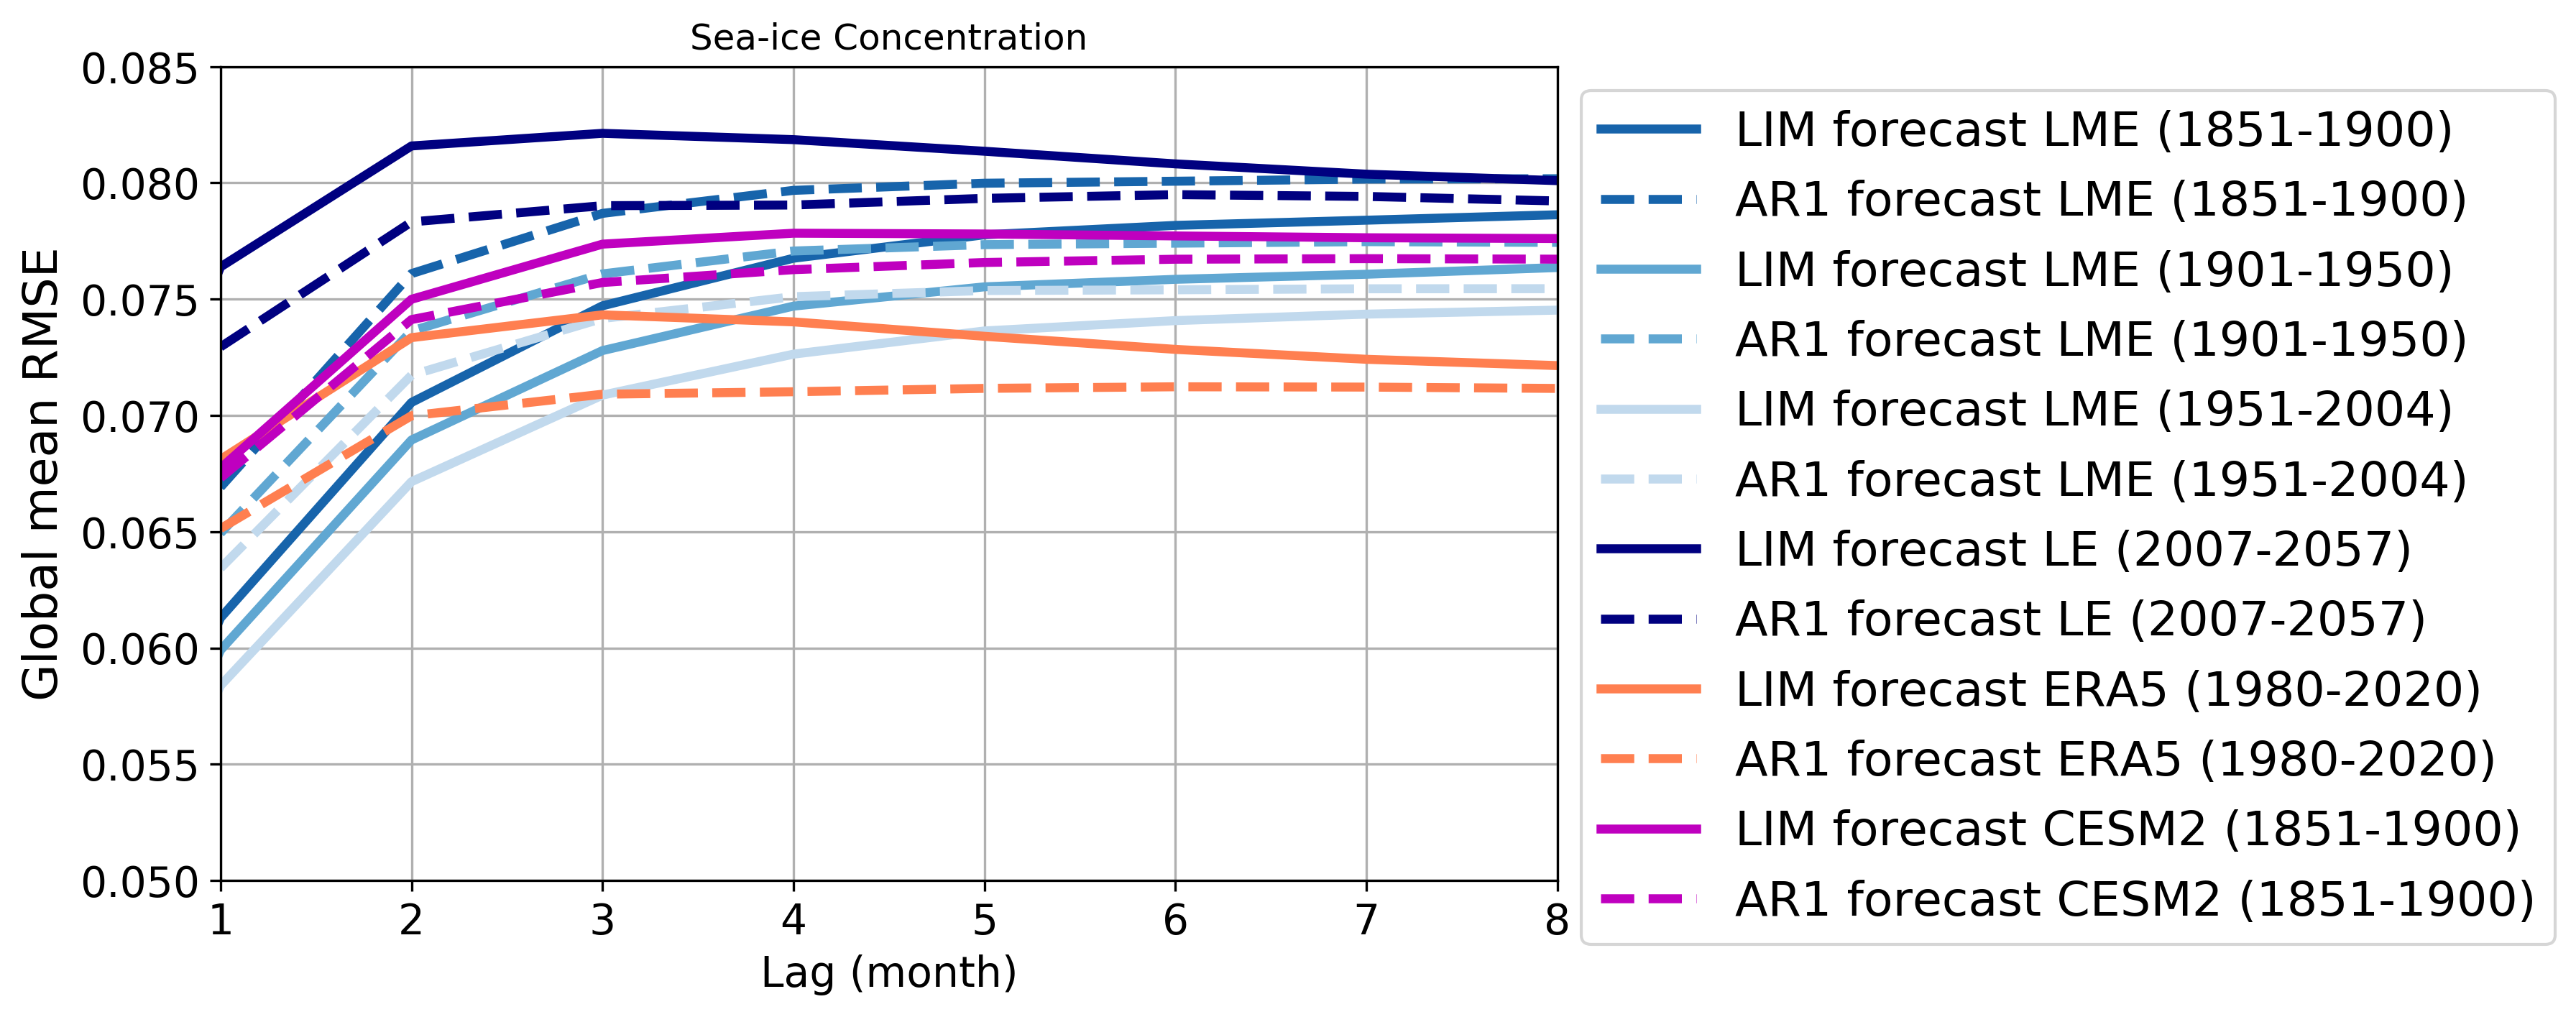

In [12]:
var = 'sic'
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(np.arange(0,9,1),forecast_validation_lags_lme1['validation_stats_lags']['sic']['gm_rmse'], 
         label='LIM forecast LME (1851-1900)', color=colors[0], linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_lme1['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
         label='AR1 forecast LME (1851-1900)', color=colors[0], linewidth=3, linestyle='--')

plt.plot(np.arange(0,9,1),forecast_validation_lags_lme2['validation_stats_lags']['sic']['gm_rmse'], 
         label='LIM forecast LME (1901-1950)', color=colors[1], linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_lme2['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
         label='AR1 forecast LME (1901-1950)', color=colors[1], linewidth=3, linestyle='--')

plt.plot(np.arange(0,9,1),forecast_validation_lags_lme3['validation_stats_lags']['sic']['gm_rmse'], 
         label='LIM forecast LME (1951-2004)', color=colors[2], linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_lme3['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
         label='AR1 forecast LME (1951-2004)', color=colors[2], linewidth=3, linestyle='--')

plt.plot(np.arange(0,9,1),forecast_validation_lags_le['validation_stats_lags']['sic']['gm_rmse'], 
         label='LIM forecast LE (2007-2057)', color='navy', linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_le['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
         label='AR1 forecast LE (2007-2057)', color='navy', linewidth=3, linestyle='--')

plt.plot(np.arange(0,9,1),forecast_validation_lags_era5['validation_stats_lags'][var]['gm_rmse'], 
         label='LIM forecast ERA5 (1980-2020)', color='coral', linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_era5['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
         label='AR1 forecast ERA5 (1980-2020)', color='coral', linewidth=3, linestyle='--')

plt.plot(np.arange(0,9,1),forecast_validation_lags_cesm2_hist1['validation_stats_lags'][var]['gm_rmse'], 
         label='LIM forecast CESM2 (1851-1900)', color='m', linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_cesm2_hist1['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
         label='AR1 forecast CESM2 (1851-1900)', color='m', linewidth=3, linestyle='--')

# plt.plot(np.arange(0,9,1),forecast_validation_lags_cesm2_hist2['validation_stats_lags'][var]['gm_rmse'], 
#          label='LIM forecast CESM2 (1901-1950)', color='m', linewidth=3)
# plt.plot(np.arange(1,9,1),ar1cast_lags_cesm2_hist2['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
#          label='AR1 forecast CESM2 (1901-1950)', color='m', linewidth=3, linestyle='--')

# plt.plot(np.arange(0,9,1),forecast_validation_lags_cesm2_hist3['validation_stats_lags'][var]['gm_rmse'], 
#          label='LIM forecast CESM2 (1951-2014)', color='m', linewidth=3)
# plt.plot(np.arange(1,9,1),ar1cast_lags_cesm2_hist3['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
#          label='AR1 forecast CESM2 (1951-2014)', color='m', linewidth=3, linestyle='--')

plt.ylim(0.05,0.085)
plt.xlim(1,8)
#plt.ylim(1.75,1.95)
plt.xlabel('Lag (month)', fontsize=14)
plt.ylabel('Global mean RMSE',fontsize=16)
#ax.set_xticks(ticks=np.arange(0,13,1))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(bbox_to_anchor=[1,1],fontsize=16)
plt.title('Sea-ice Concentration')

Text(0.5,1,'Sea-ice Concentration')

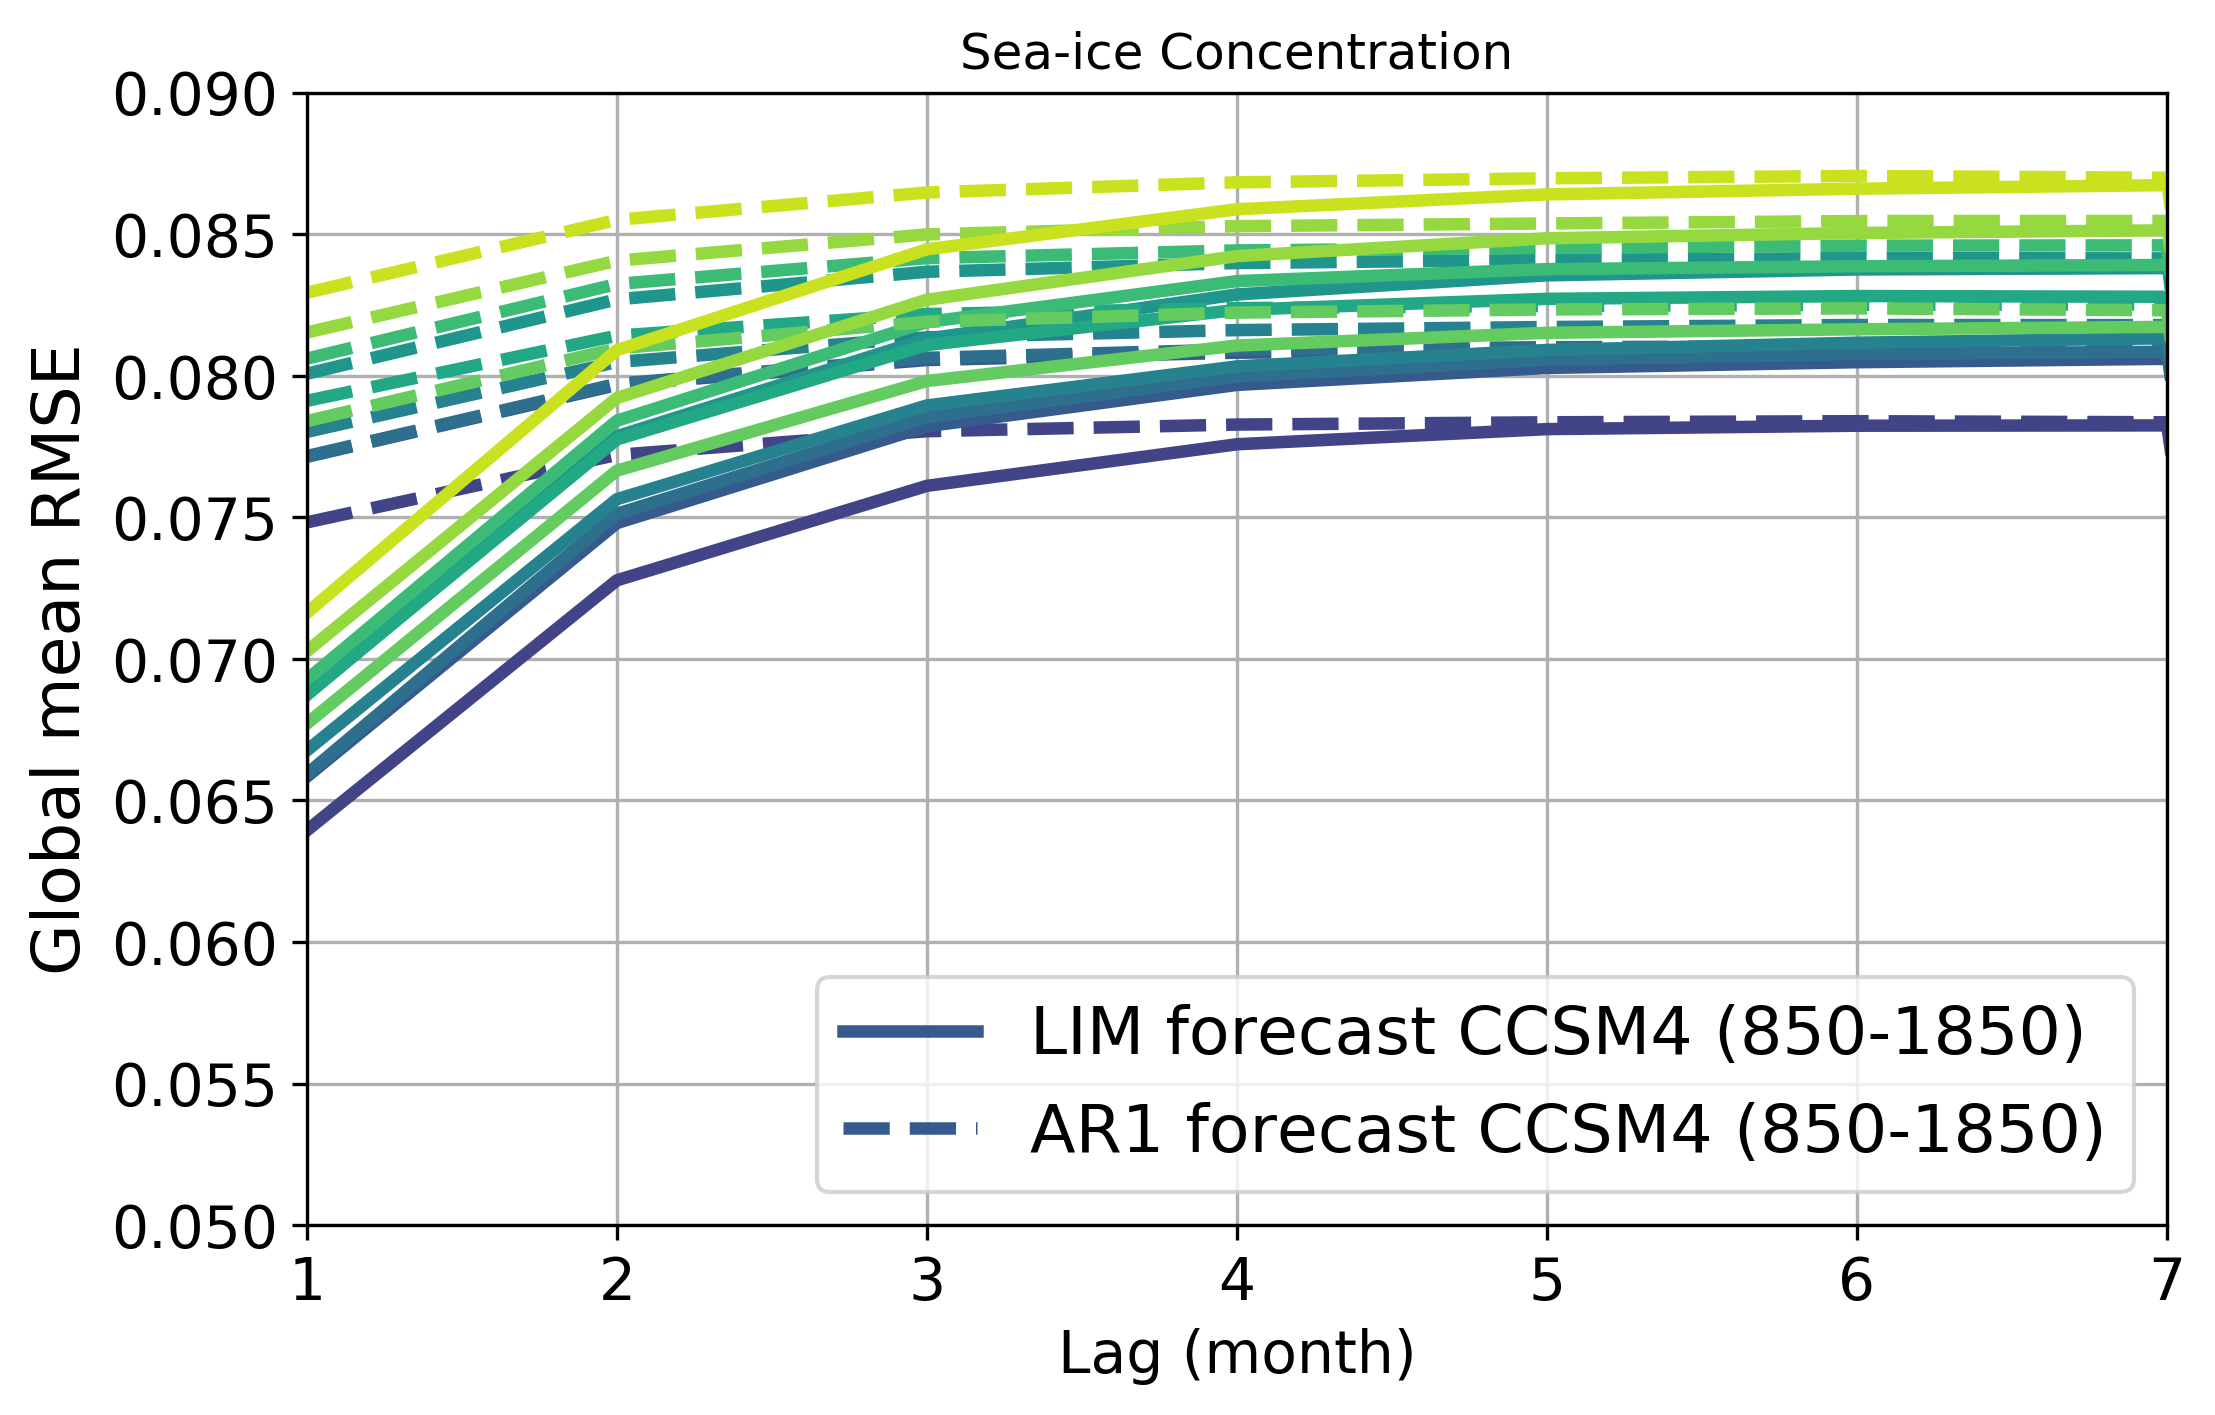

In [20]:
var = 'sic'
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')


for i, startyr in enumerate(startyrs_list):
    if i == 1: 
        plt.plot(np.arange(1,9,1),gm_rmse_ccsm4_sic[i,:], 
                 label='LIM forecast CCSM4 (850-1850)', 
                 color=colors2[i], linewidth=3)
        plt.plot(np.arange(1,9,1),gm_rmse_ar1_ccsm4_sic[i,:], 
                 label='AR1 forecast CCSM4 (850-1850)', 
                 color=colors2[i], linewidth=3, linestyle='--')
    else: 
        plt.plot(np.arange(1,9,1),gm_rmse_ccsm4_sic[i,:],  
                 color=colors2[i], linewidth=3)
        plt.plot(np.arange(1,9,1),gm_rmse_ar1_ccsm4_sic[i,:], 
                 color=colors2[i], linewidth=3, linestyle='--')

plt.ylim(0.05,0.09)
plt.xlim(1,7)
#plt.ylim(1.75,1.95)
plt.xlabel('Lag (month)', fontsize=14)
plt.ylabel('Global mean RMSE',fontsize=16)
#ax.set_xticks(ticks=np.arange(0,13,1))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc='lower right',fontsize=16)
plt.title('Sea-ice Concentration')

In [21]:
gm_rmse_mpi_sic[i,:], forecast_validation_lags_mpi[startyr]['validation_stats_lags']['sic']['gm_rmse']

(array([0.072411  , 0.08011404, 0.08201592, 0.08217133, 0.08196968,
        0.08181153, 0.08172409, 0.0816396 ]),
 array([0.05415111, 0.072411  , 0.08011404, 0.08201592, 0.08217133,
        0.08196968, 0.08181153, 0.08172409, 0.0816396 ]))

Text(0.5,1,'Sea-ice Concentration')

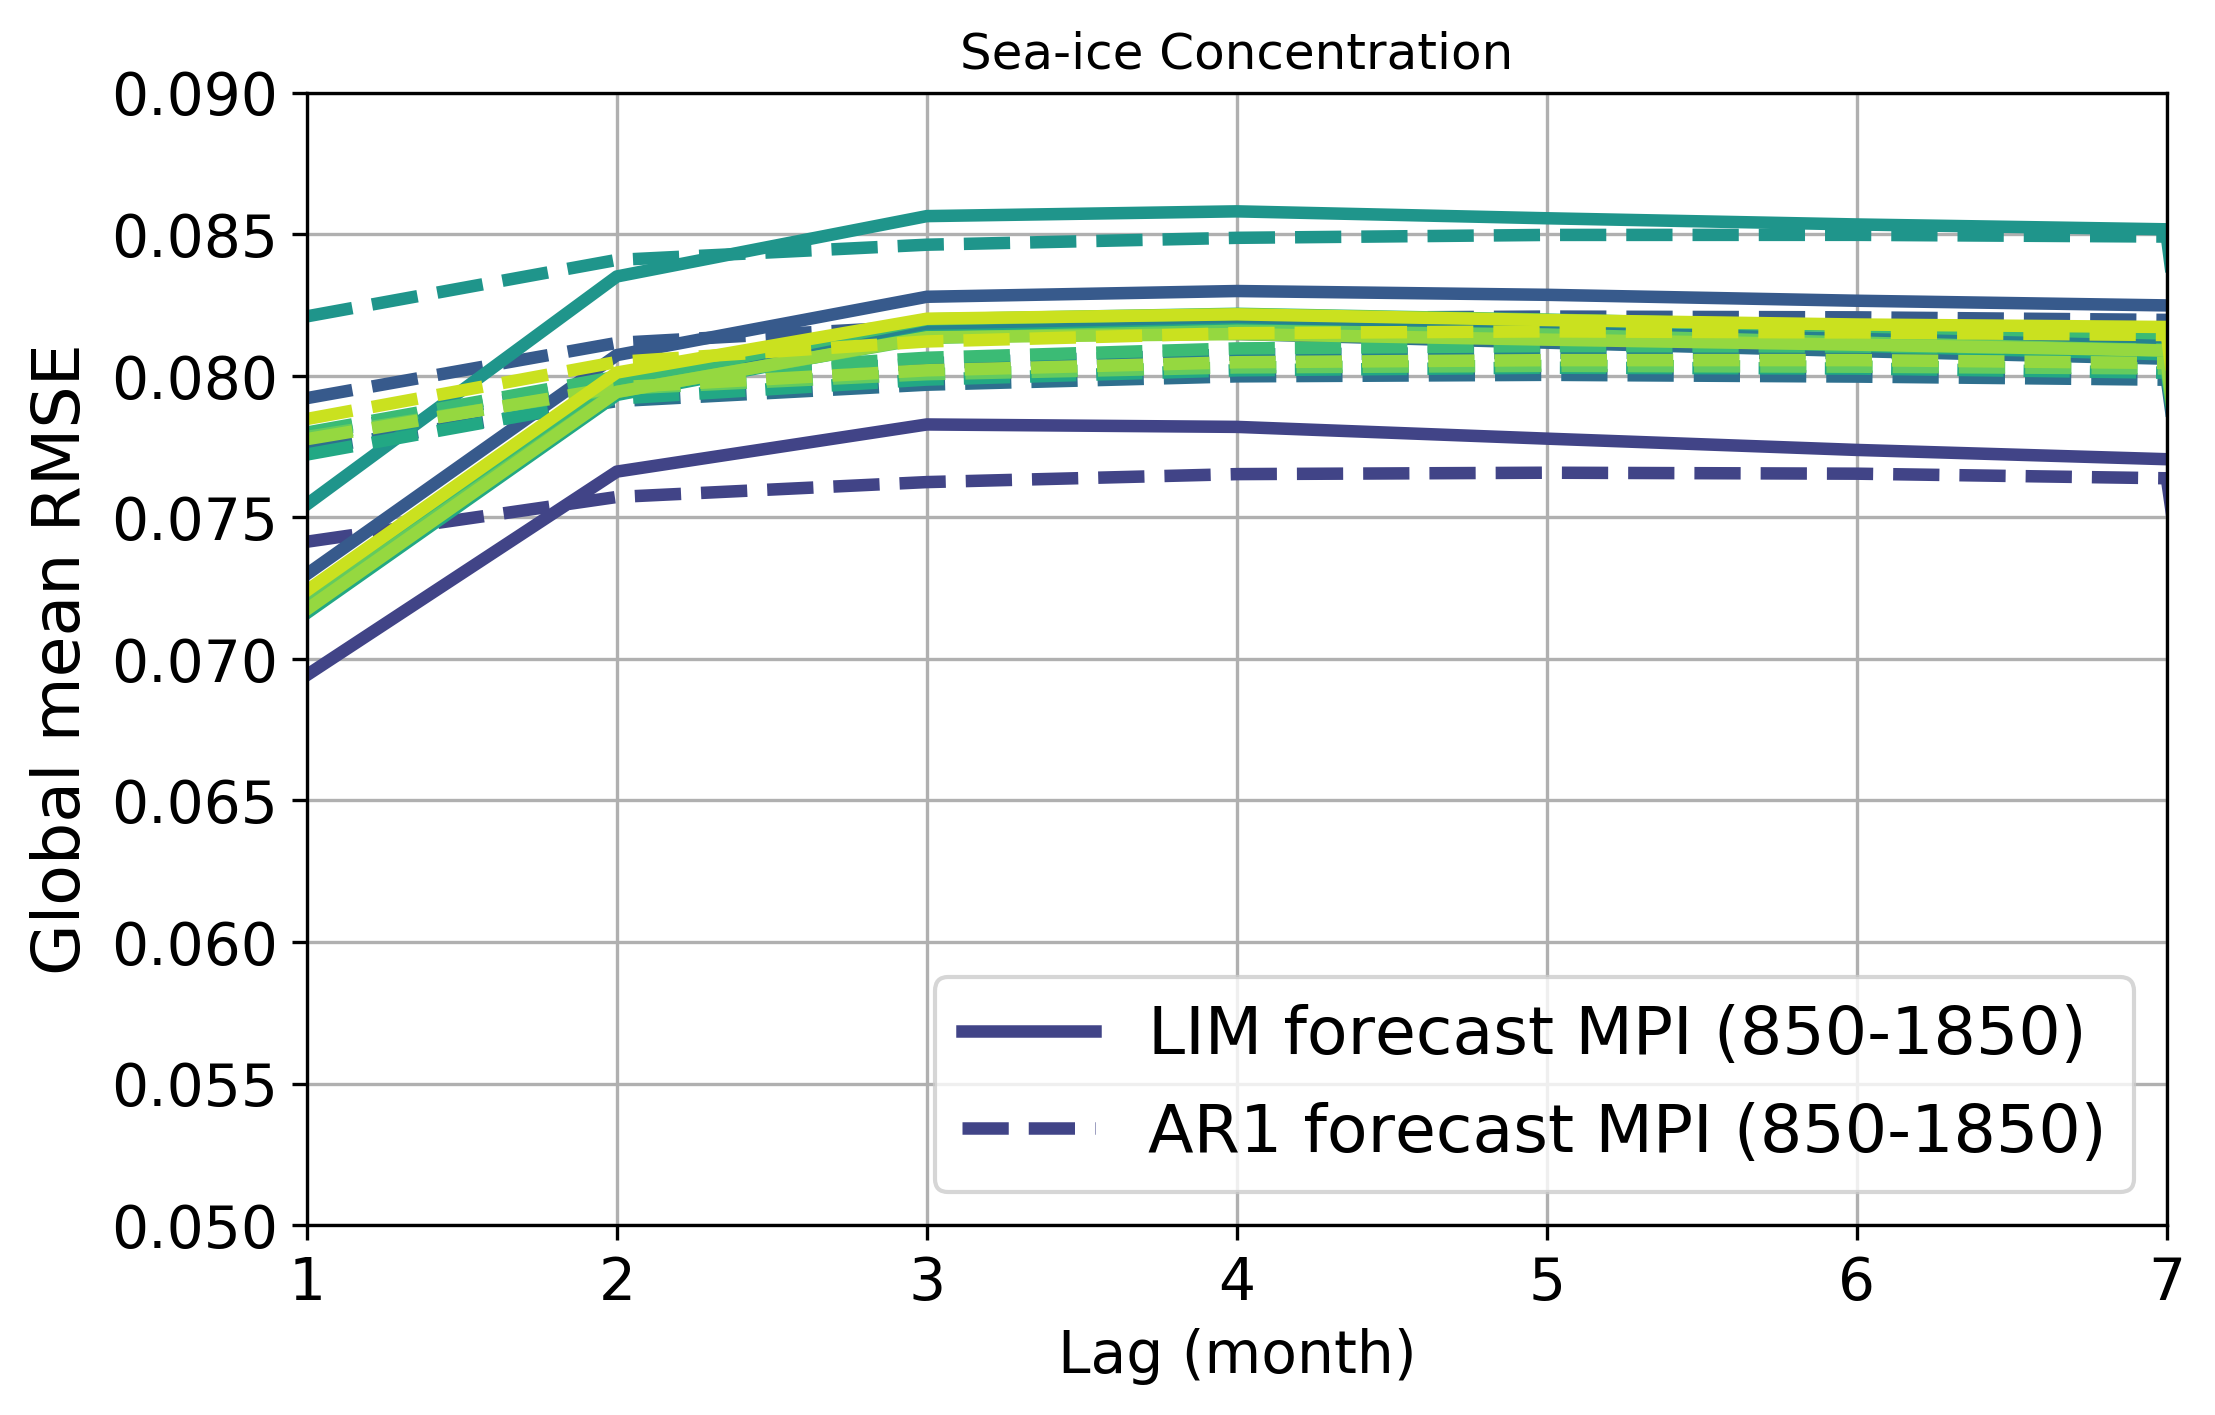

In [22]:
var = 'sic'
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

for i, startyr in enumerate(startyrs_list):
    if i == 0: 
        plt.plot(np.arange(1,9,1),gm_rmse_mpi_sic[i,:], 
                 label='LIM forecast MPI (850-1850)', 
                 color=colors2[i], linewidth=3)
        plt.plot(np.arange(1,9,1),gm_rmse_ar1_mpi_sic[i,:], 
                 label='AR1 forecast MPI (850-1850)', 
                 color=colors2[i], linewidth=3, linestyle='--')
    else: 
        plt.plot(np.arange(1,9,1),gm_rmse_mpi_sic[i,:], 
                 color=colors2[i], linewidth=3)
        plt.plot(np.arange(1,9,1),gm_rmse_ar1_mpi_sic[i,:],  
                 color=colors2[i], linewidth=3, linestyle='--')
        

plt.ylim(0.05,0.09)
plt.xlim(1,7)
#plt.ylim(1.75,1.95)
plt.xlabel('Lag (month)', fontsize=14)
plt.ylabel('Global mean RMSE',fontsize=16)
#ax.set_xticks(ticks=np.arange(0,13,1))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc ='lower right',fontsize=16)
plt.title('Sea-ice Concentration')

Text(0.5,1,'Sea-ice Concentration')

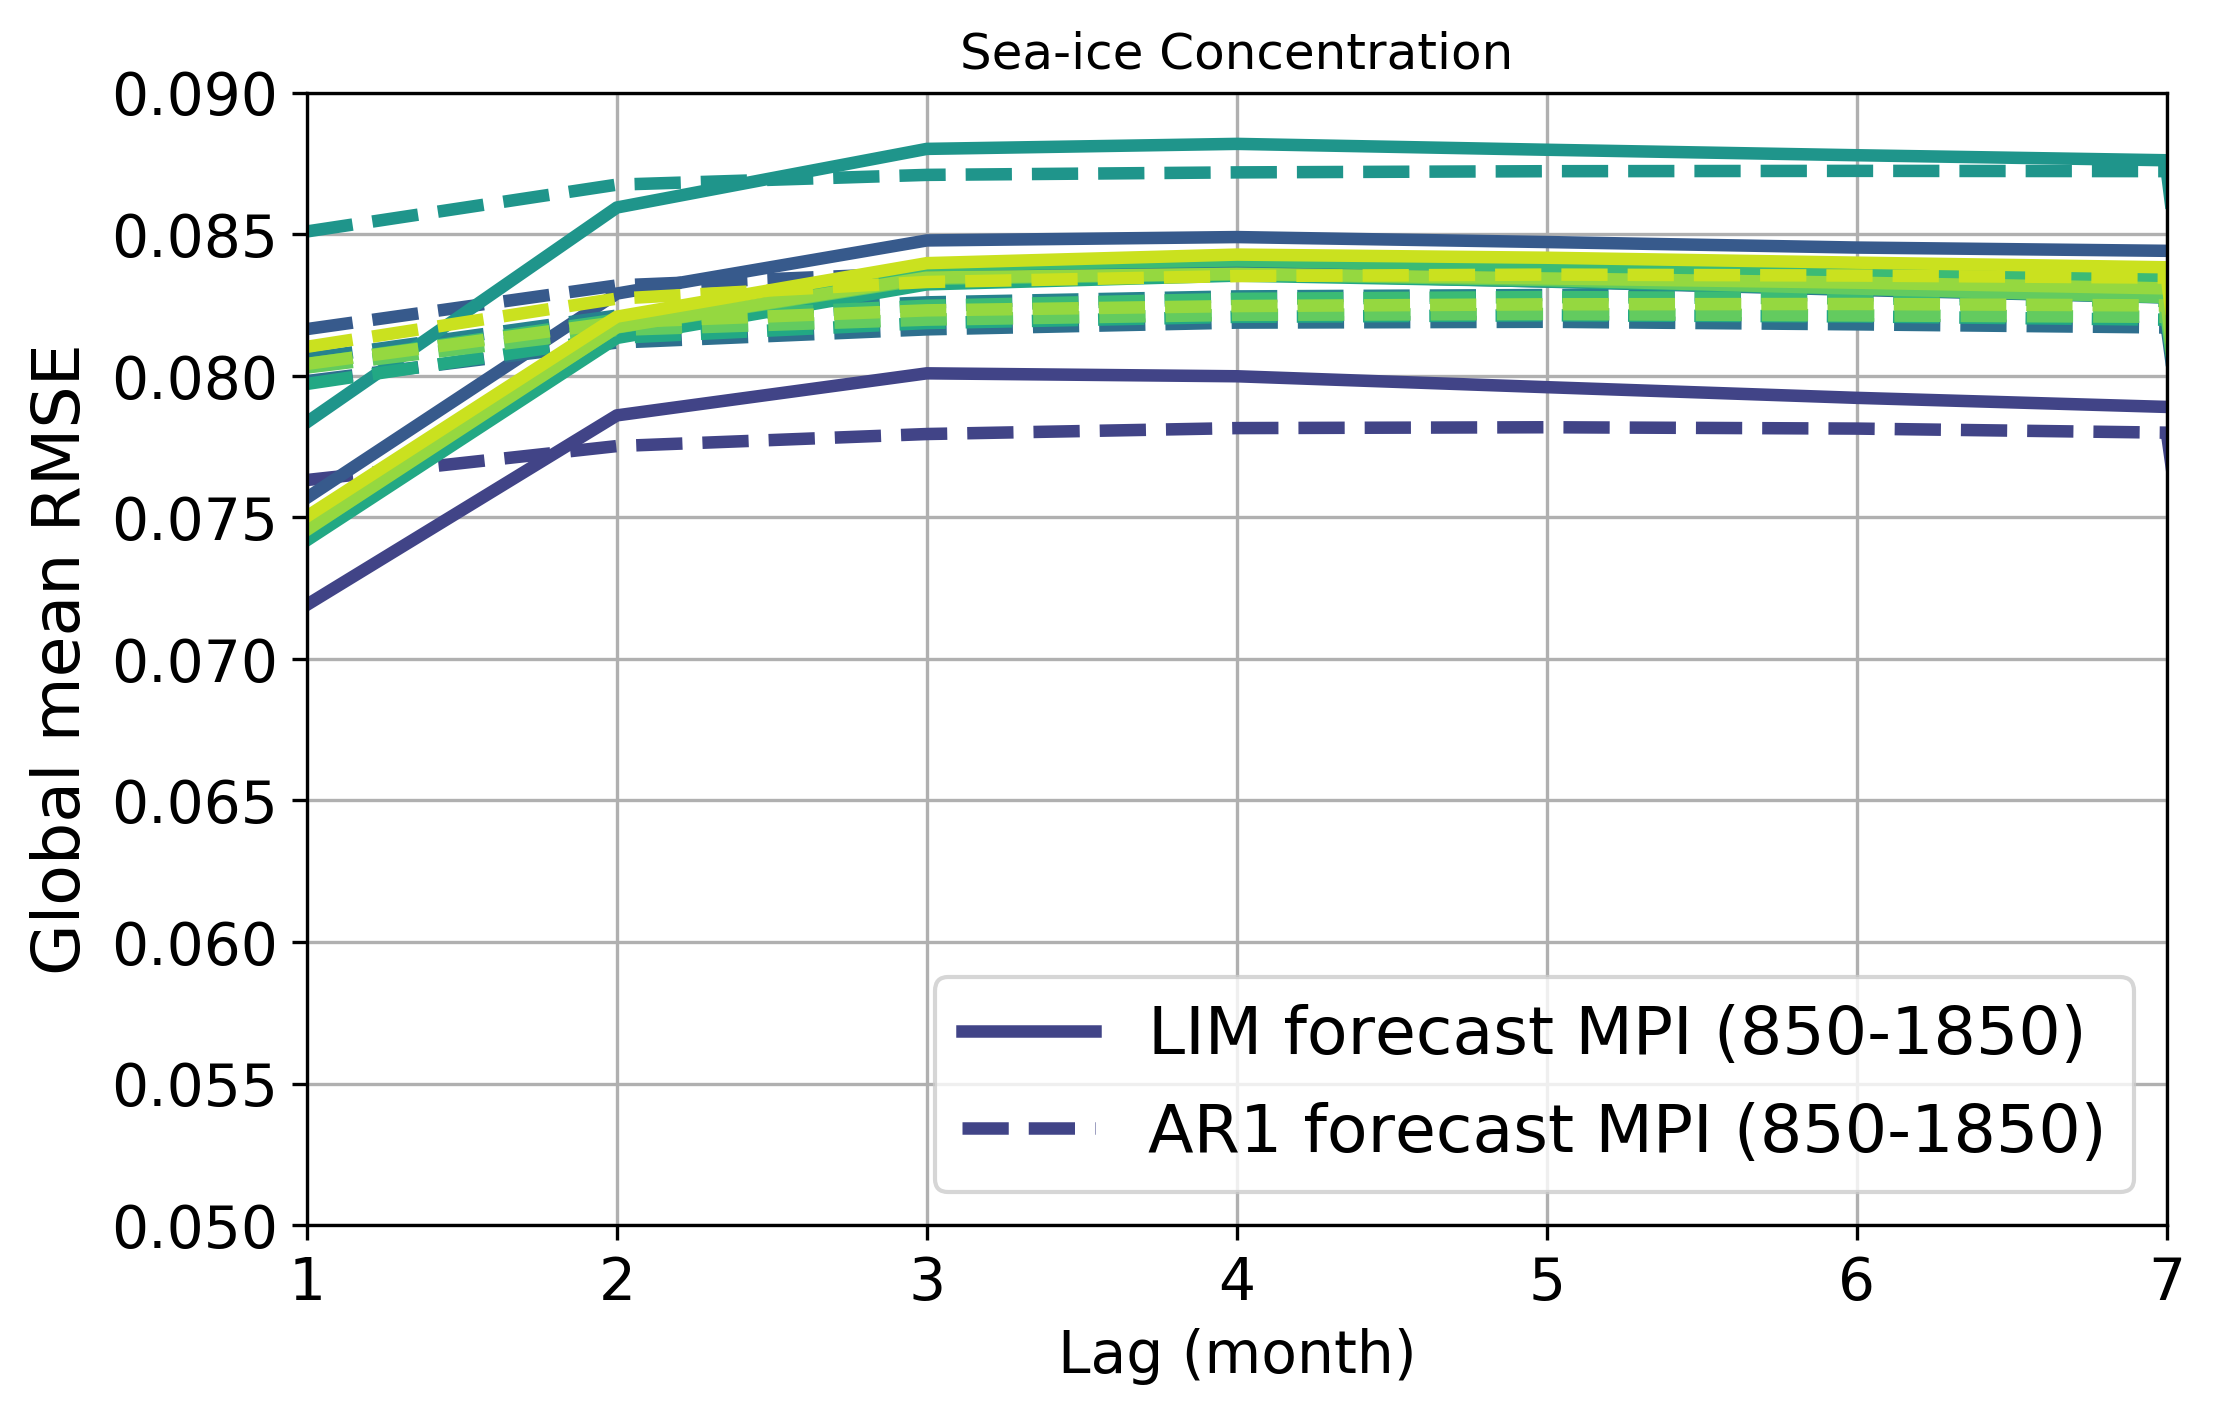

In [24]:
var = 'sic'
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

for i, startyr in enumerate(startyrs_list):
    if i == 0: 
        plt.plot(np.arange(1,9,1),gm_rmse_mpi2_sic[i,:], 
                 label='LIM forecast MPI (850-1850)', 
                 color=colors2[i], linewidth=3)
        plt.plot(np.arange(1,9,1),gm_rmse_ar1_mpi2_sic[i,:], 
                 label='AR1 forecast MPI (850-1850)', 
                 color=colors2[i], linewidth=3, linestyle='--')
    else: 
        plt.plot(np.arange(1,9,1),gm_rmse_mpi2_sic[i,:], 
                 color=colors2[i], linewidth=3)
        plt.plot(np.arange(1,9,1),gm_rmse_ar1_mpi2_sic[i,:],  
                 color=colors2[i], linewidth=3, linestyle='--')
        

plt.ylim(0.05,0.09)
plt.xlim(1,7)
#plt.ylim(1.75,1.95)
plt.xlabel('Lag (month)', fontsize=14)
plt.ylabel('Global mean RMSE',fontsize=16)
#ax.set_xticks(ticks=np.arange(0,13,1))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc ='lower right',fontsize=16)
plt.title('Sea-ice Concentration')

## Load total Arctic sea ice area: 

In [29]:
filename = 'Total_Arctic_SIA_CESMlme_MPIhist_SAT_ERA5_CESMle_CESM2.pkl'
tot_sia = pickle.load( open( filename, "rb" ) )

In [30]:
filename = 'Total_Arctic_SIE_CESMlme_MPIhist_SAT_ERA5_CESMle_CESM2.pkl'
tot_sie = pickle.load( open( filename, "rb" ) )

In [31]:
tot_sia.keys()

dict_keys(['CESM_LME_851_1850', 'CESM_LME_1851_2005', 'CESM2_Hist_1850_2014', 'MPI_Hist_1850_2014', 'Satellite_1980_2016', 'ERA5_1980_2020', 'CESM_LE_2006_2100'])

In [33]:
cesm_lme_sia_std = np.std(tot_sia['CESM_LME_851_1850'][0:800*12])

cesm_lme1_sia_std = np.std(tot_sia['CESM_LME_1851_2005'][12:50*12])
cesm_lme2_sia_std = np.std(tot_sia['CESM_LME_1851_2005'][51*12:100*12])
cesm_lme3_sia_std = np.std(tot_sia['CESM_LME_1851_2005'][101*12:154*12])

cesm2_hist1_sia_std = np.std(tot_sia['CESM2_Hist_1850_2014'][12:50*12])
cesm2_hist2_sia_std = np.std(tot_sia['CESM2_Hist_1850_2014'][51*12:100*12])
cesm2_hist3_sia_std = np.std(tot_sia['CESM2_Hist_1850_2014'][101*12:164*12])

cesm_le_sia_std = np.std(tot_sia['CESM_LE_2006_2100'][12:51*12])

era5_sia_std = np.std(tot_sia['ERA5_1980_2020'])

In [32]:
cesm_lme_sie_std = np.std(tot_sie['CESM_LME_851_1850'][0:800*12])

cesm_lme1_sie_std = np.std(tot_sie['CESM_LME_1851_2005'][12:50*12])
cesm_lme2_sie_std = np.std(tot_sie['CESM_LME_1851_2005'][51*12:100*12])
cesm_lme3_sie_std = np.std(tot_sie['CESM_LME_1851_2005'][101*12:154*12])

cesm2_hist1_sie_std = np.std(tot_sie['CESM2_Hist_1850_2014'][12:50*12])
cesm2_hist2_sie_std = np.std(tot_sie['CESM2_Hist_1850_2014'][51*12:100*12])
cesm2_hist3_sie_std = np.std(tot_sie['CESM2_Hist_1850_2014'][101*12:164*12])

cesm_le_sie_std = np.std(tot_sie['CESM_LE_2006_2100'][12:51*12])

era5_sie_std = np.std(tot_sie['ERA5_1980_2020'])

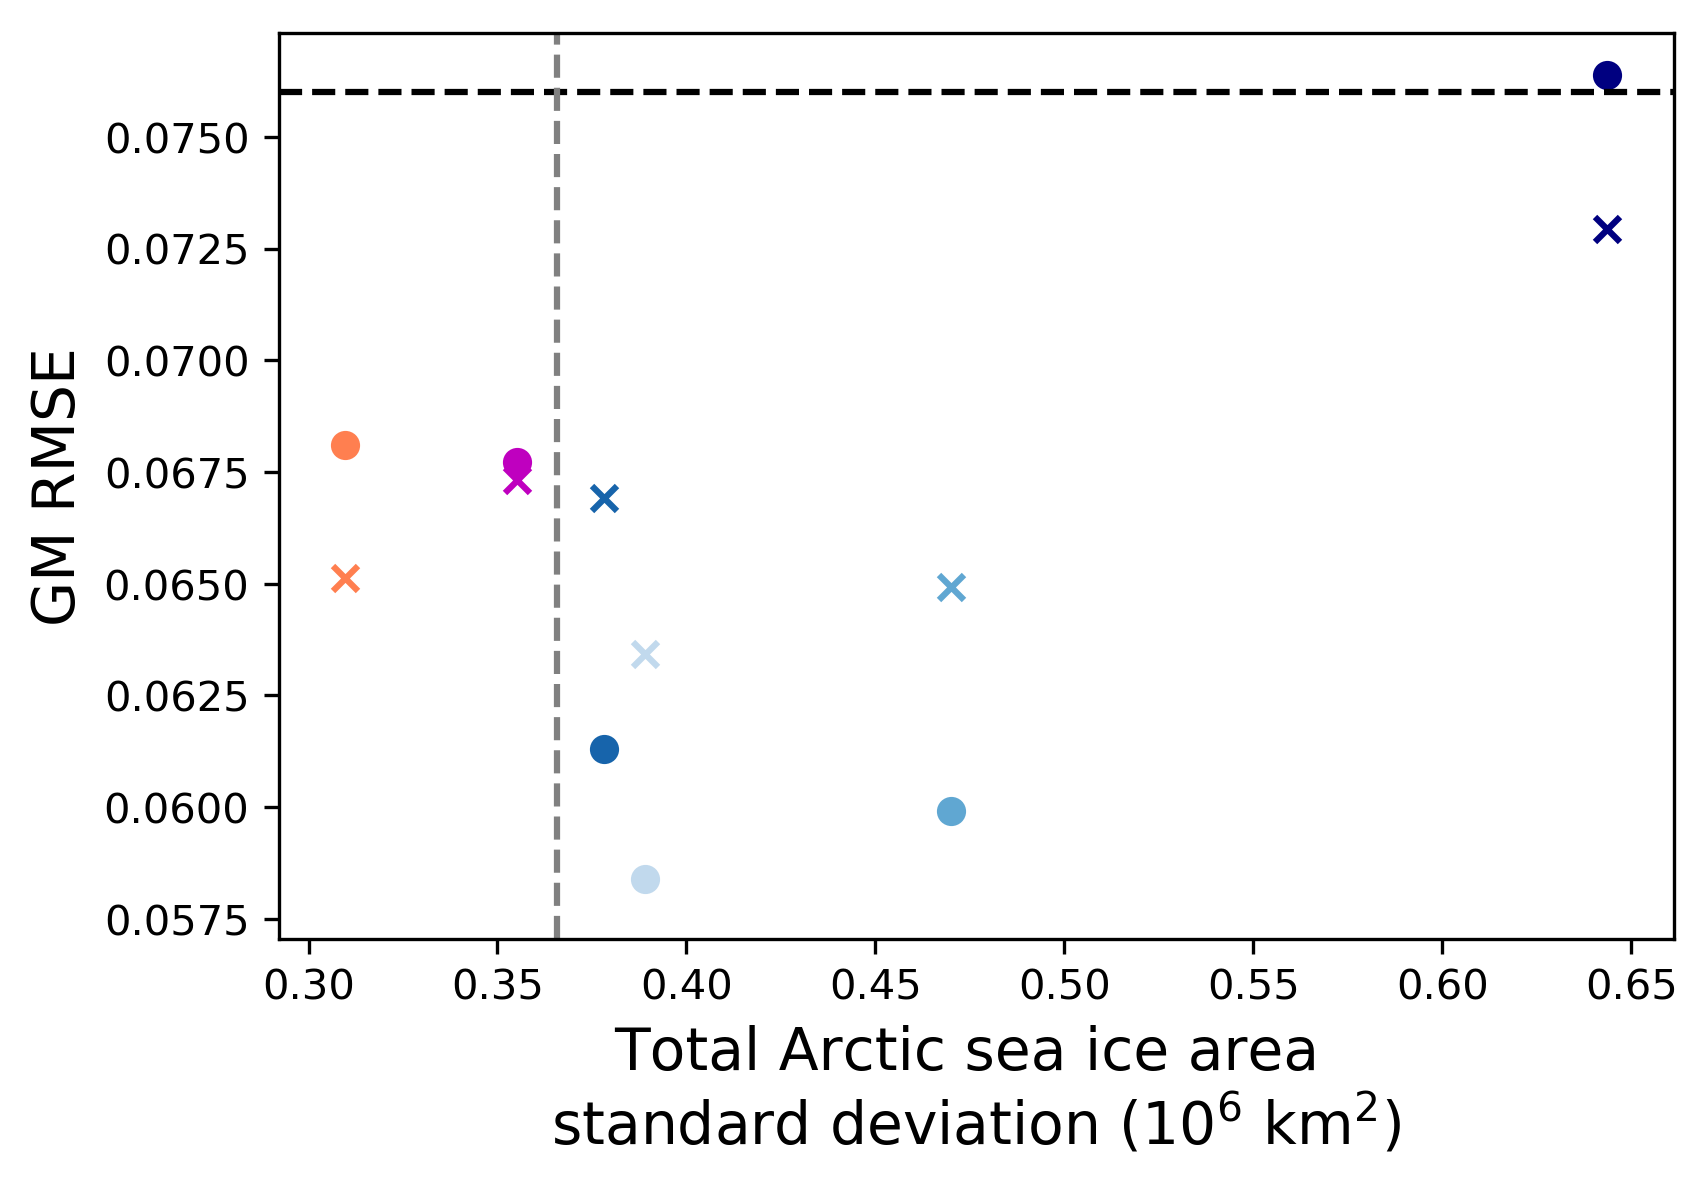

In [35]:
plt.scatter(cesm_lme1_sia_std,forecast_validation_lags_lme1['validation_stats_lags']['sic']['gm_rmse'][1], 
            color=colors[0])
plt.scatter(cesm_lme2_sia_std,forecast_validation_lags_lme2['validation_stats_lags']['sic']['gm_rmse'][1],
            color=colors[1])
plt.scatter(cesm_lme3_sia_std,forecast_validation_lags_lme3['validation_stats_lags']['sic']['gm_rmse'][1],
            color=colors[2])

plt.scatter(cesm_le_sia_std,forecast_validation_lags_le['validation_stats_lags']['sic']['gm_rmse'][1], 
            color='navy')
plt.scatter(era5_sia_std,forecast_validation_lags_era5['validation_stats_lags']['sic']['gm_rmse'][1], 
            color='coral')
plt.scatter(cesm2_hist1_sia_std,forecast_validation_lags_cesm2_hist1['validation_stats_lags']['sic']['gm_rmse'][1], 
            color='m')

plt.scatter(cesm_lme1_sia_std,ar1cast_lags_lme1['validation_stats_ar1_lags']['sic']['gm_rmse'][0], 
            color=colors[0], marker='x')
plt.scatter(cesm_lme2_sia_std,ar1cast_lags_lme2['validation_stats_ar1_lags']['sic']['gm_rmse'][0],
            color=colors[1], marker='x')
plt.scatter(cesm_lme3_sia_std,ar1cast_lags_lme3['validation_stats_ar1_lags']['sic']['gm_rmse'][0],
            color=colors[2], marker='x')

plt.scatter(cesm_le_sia_std,ar1cast_lags_le['validation_stats_ar1_lags']['sic']['gm_rmse'][0], 
            color='navy', marker='x')
plt.scatter(era5_sia_std,ar1cast_lags_era5['validation_stats_ar1_lags']['sic']['gm_rmse'][0], 
            color='coral', marker='x')
plt.scatter(cesm2_hist1_sia_std,ar1cast_lags_cesm2_hist1['validation_stats_ar1_lags']['sic']['gm_rmse'][0], 
            color='m', marker='x')

plt.xlabel('Total Arctic sea ice area \nstandard deviation (10$^6$ km$^2$)', fontsize=14)
plt.ylabel('GM RMSE', fontsize=14)

plt.axhline(0.076, color='k', linestyle='--')
plt.axvline(cesm_lme_sia_std, color='gray', linestyle='--')

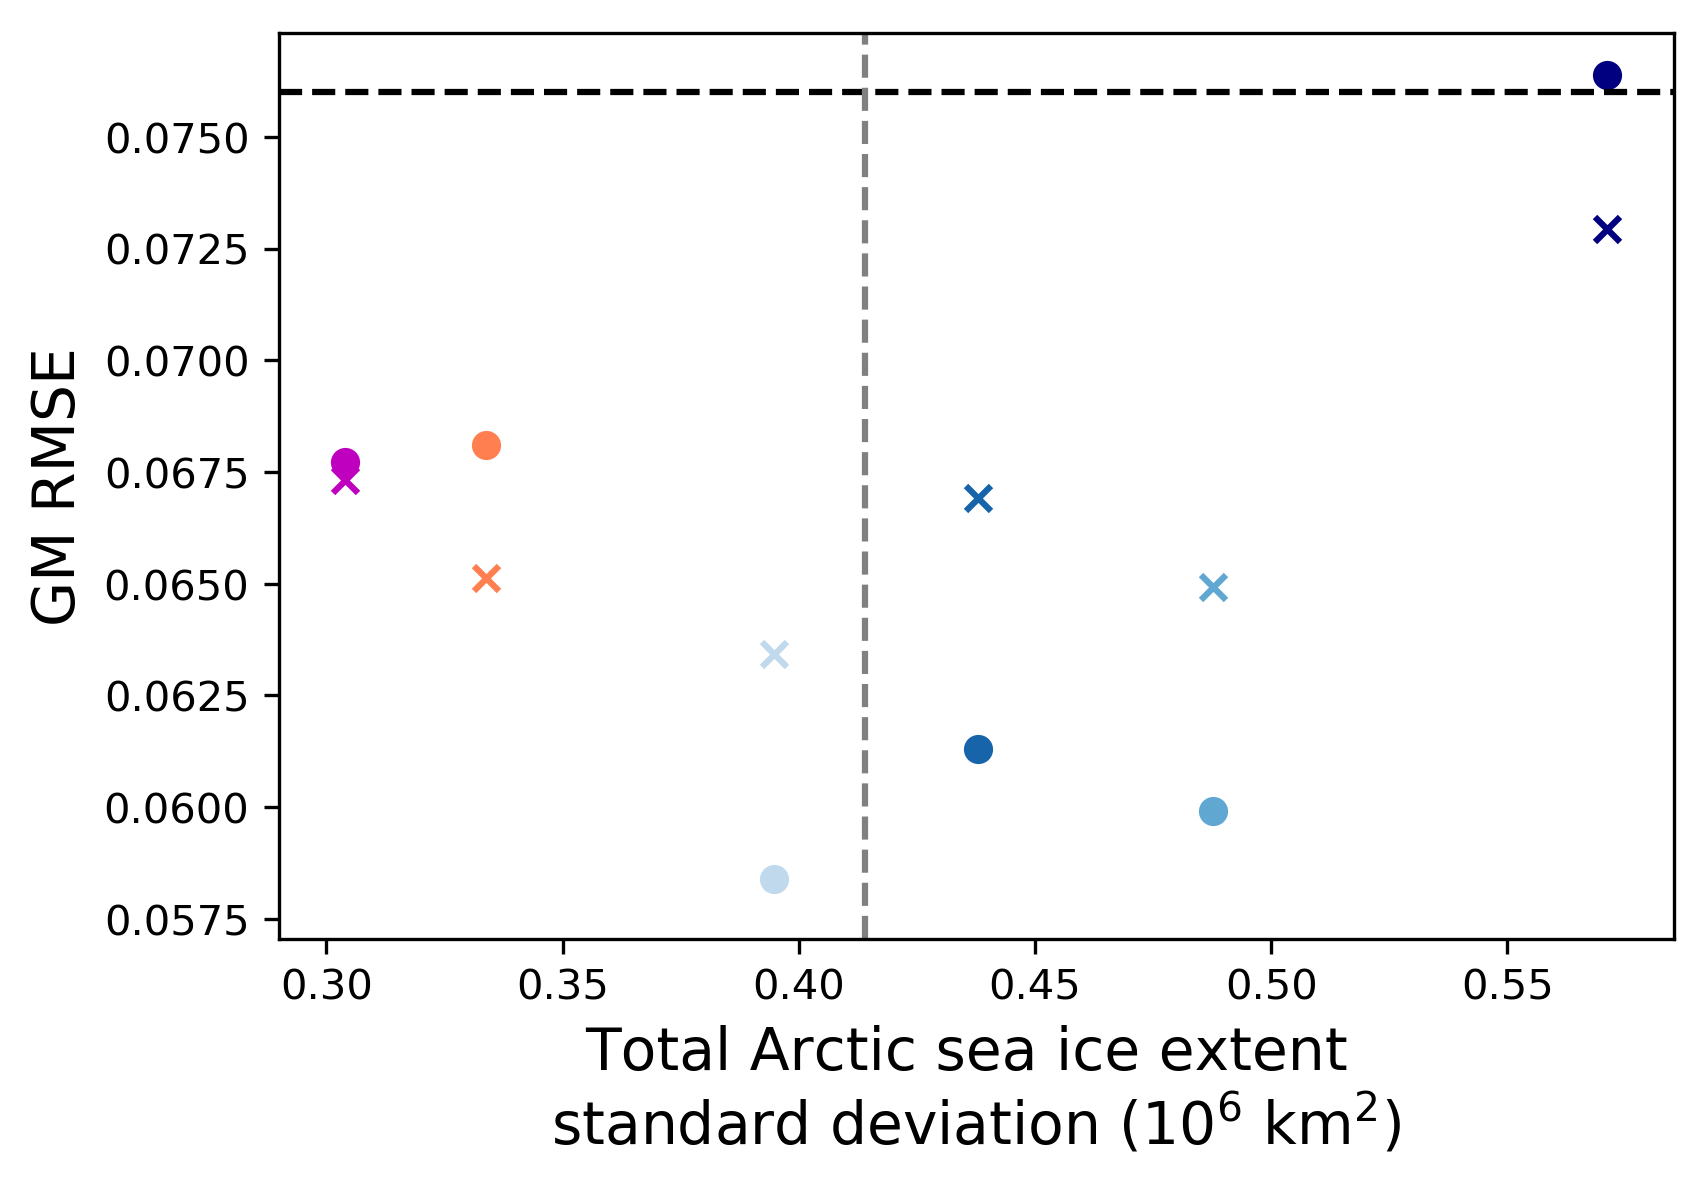

In [36]:
plt.scatter(cesm_lme1_sie_std,forecast_validation_lags_lme1['validation_stats_lags']['sic']['gm_rmse'][1], 
            color=colors[0])
plt.scatter(cesm_lme2_sie_std,forecast_validation_lags_lme2['validation_stats_lags']['sic']['gm_rmse'][1],
            color=colors[1])
plt.scatter(cesm_lme3_sie_std,forecast_validation_lags_lme3['validation_stats_lags']['sic']['gm_rmse'][1],
            color=colors[2])

plt.scatter(cesm_le_sie_std,forecast_validation_lags_le['validation_stats_lags']['sic']['gm_rmse'][1], 
            color='navy')
plt.scatter(era5_sie_std,forecast_validation_lags_era5['validation_stats_lags']['sic']['gm_rmse'][1], 
            color='coral')
plt.scatter(cesm2_hist1_sie_std,forecast_validation_lags_cesm2_hist1['validation_stats_lags']['sic']['gm_rmse'][1], 
            color='m')

plt.scatter(cesm_lme1_sie_std,ar1cast_lags_lme1['validation_stats_ar1_lags']['sic']['gm_rmse'][0], 
            color=colors[0], marker='x')
plt.scatter(cesm_lme2_sie_std,ar1cast_lags_lme2['validation_stats_ar1_lags']['sic']['gm_rmse'][0],
            color=colors[1], marker='x')
plt.scatter(cesm_lme3_sie_std,ar1cast_lags_lme3['validation_stats_ar1_lags']['sic']['gm_rmse'][0],
            color=colors[2], marker='x')

plt.scatter(cesm_le_sie_std,ar1cast_lags_le['validation_stats_ar1_lags']['sic']['gm_rmse'][0], 
            color='navy', marker='x')
plt.scatter(era5_sie_std,ar1cast_lags_era5['validation_stats_ar1_lags']['sic']['gm_rmse'][0], 
            color='coral', marker='x')
plt.scatter(cesm2_hist1_sie_std,ar1cast_lags_cesm2_hist1['validation_stats_ar1_lags']['sic']['gm_rmse'][0], 
            color='m', marker='x')

plt.xlabel('Total Arctic sea ice extent \nstandard deviation (10$^6$ km$^2$)', fontsize=14)
plt.ylabel('GM RMSE', fontsize=14)

plt.axhline(0.076, color='k', linestyle='--')
plt.axvline(cesm_lme_sie_std, color='gray', linestyle='--')

In [39]:
cesm_lme_sia_range = np.max(tot_sia['CESM_LME_851_1850'][0:800*12]) - np.min(tot_sia['CESM_LME_851_1850'][0:800*12])

cesm_lme1_sia_range = np.max(tot_sia['CESM_LME_1851_2005'][12:50*12]) - np.min(tot_sia['CESM_LME_1851_2005'][12:50*12])
cesm_lme2_sia_range = np.max(tot_sia['CESM_LME_1851_2005'][51*12:100*12]) - np.min(tot_sia['CESM_LME_1851_2005'][51*12:100*12])
cesm_lme3_sia_range = np.max(tot_sia['CESM_LME_1851_2005'][101*12:154*12]) - np.min(tot_sia['CESM_LME_1851_2005'][101*12:154*12])

cesm_le_sia_range = np.max(tot_sia['CESM_LE_2006_2100'][12:51*12]) - np.min(tot_sia['CESM_LE_2006_2100'][12:51*12])

era5_sia_range = np.max(tot_sia['ERA5_1980_2020']) - np.min(tot_sia['ERA5_1980_2020'])

In [40]:
cesm_lme_sie_range = np.max(tot_sie['CESM_LME_851_1850'][0:800*12]) - np.min(tot_sie['CESM_LME_851_1850'][0:800*12])

cesm_lme1_sie_range = np.max(tot_sie['CESM_LME_1851_2005'][12:50*12]) - np.min(tot_sie['CESM_LME_1851_2005'][12:50*12])
cesm_lme2_sie_range = np.max(tot_sie['CESM_LME_1851_2005'][51*12:100*12]) - np.min(tot_sie['CESM_LME_1851_2005'][51*12:100*12])
cesm_lme3_sie_range = np.max(tot_sie['CESM_LME_1851_2005'][101*12:154*12]) - np.min(tot_sie['CESM_LME_1851_2005'][101*12:154*12])

cesm2_hist1_sie_range = np.max(tot_sie['CESM2_Hist_1850_2014'][12:50*12]) - np.min(tot_sie['CESM2_Hist_1850_2014'][12:50*12])
cesm2_hist2_sie_range = np.max(tot_sie['CESM2_Hist_1850_2014'][51*12:100*12]) - np.min(tot_sie['CESM2_Hist_1850_2014'][51*12:100*12])
cesm2_hist3_sie_range = np.max(tot_sie['CESM2_Hist_1850_2014'][101*12:154*12]) - np.min(tot_sie['CESM2_Hist_1850_2014'][101*12:154*12])

cesm_le_sie_range = np.max(tot_sie['CESM_LE_2006_2100'][12:51*12]) - np.min(tot_sie['CESM_LE_2006_2100'][12:51*12])

era5_sie_range = np.max(tot_sie['ERA5_1980_2020']) - np.min(tot_sie['ERA5_1980_2020'])

In [41]:
np.max(tot_sia['CESM_LME_851_1850']) - np.min(tot_sia['CESM_LME_851_1850']), cesm_lme_sia_range

(3.763538066084247, 3.763538066084247)

NameError: name 'cesm2_hist1_sia_range' is not defined

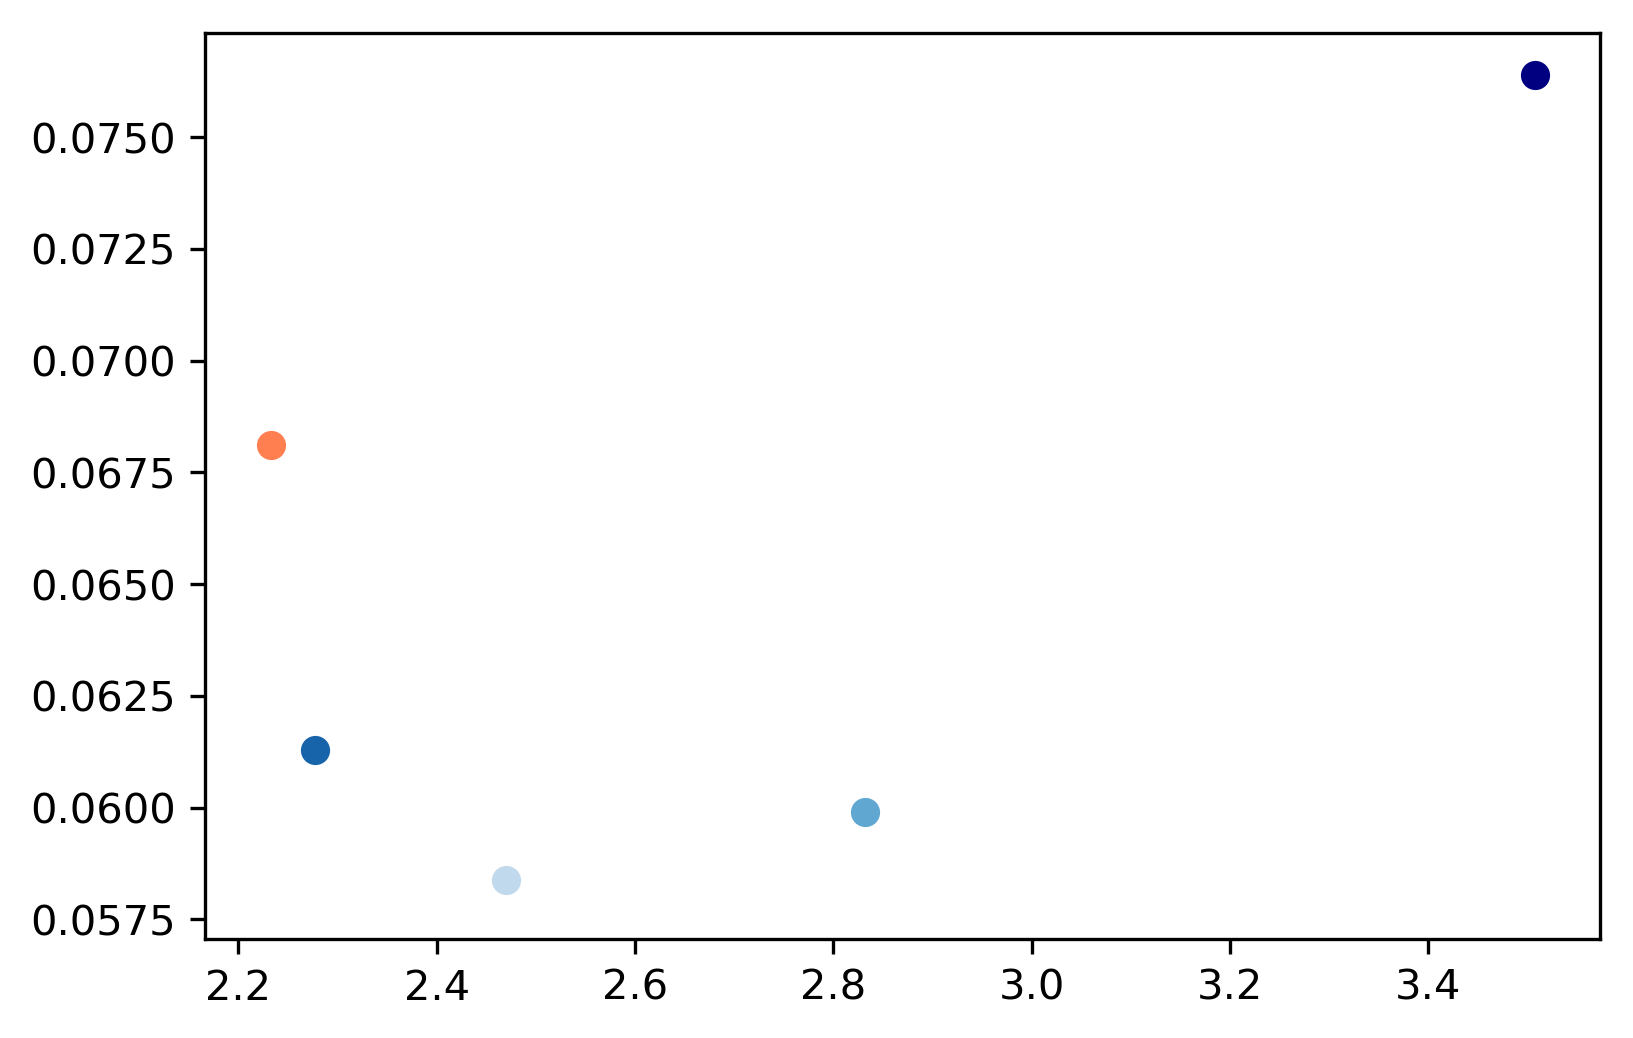

In [42]:
plt.scatter(cesm_lme1_sia_range,forecast_validation_lags_lme1['validation_stats_lags']['sic']['gm_rmse'][1], 
            color=colors[0])
plt.scatter(cesm_lme2_sia_range,forecast_validation_lags_lme2['validation_stats_lags']['sic']['gm_rmse'][1],
            color=colors[1])
plt.scatter(cesm_lme3_sia_range,forecast_validation_lags_lme3['validation_stats_lags']['sic']['gm_rmse'][1],
            color=colors[2])

plt.scatter(cesm_le_sia_range,forecast_validation_lags_le['validation_stats_lags']['sic']['gm_rmse'][1], 
            color='navy')
plt.scatter(era5_sia_range,forecast_validation_lags_era5['validation_stats_lags']['sic']['gm_rmse'][1], 
            color='coral')

plt.scatter(cesm_lme1_sia_range,ar1cast_lags_lme1['validation_stats_ar1_lags']['sic']['gm_rmse'][0], 
            color=colors[0], marker='x')
plt.scatter(cesm_lme2_sia_range,ar1cast_lags_lme2['validation_stats_ar1_lags']['sic']['gm_rmse'][0],
            color=colors[1], marker='x')
plt.scatter(cesm_lme3_sia_range,ar1cast_lags_lme3['validation_stats_ar1_lags']['sic']['gm_rmse'][0],
            color=colors[2], marker='x')

plt.scatter(cesm_le_sia_range,ar1cast_lags_le['validation_stats_ar1_lags']['sic']['gm_rmse'][0], 
            color='navy', marker='x')
plt.scatter(era5_sia_range,ar1cast_lags_era5['validation_stats_ar1_lags']['sic']['gm_rmse'][0], 
            color='coral', marker='x')

plt.xlabel('Range of total Arctic sea ice area', fontsize=14)
plt.ylabel('GM RMSE', fontsize=14)

plt.axhline(0.076, color='k', linestyle='--')
plt.axvline(cesm_lme_sia_range, color='gray', linestyle='--')

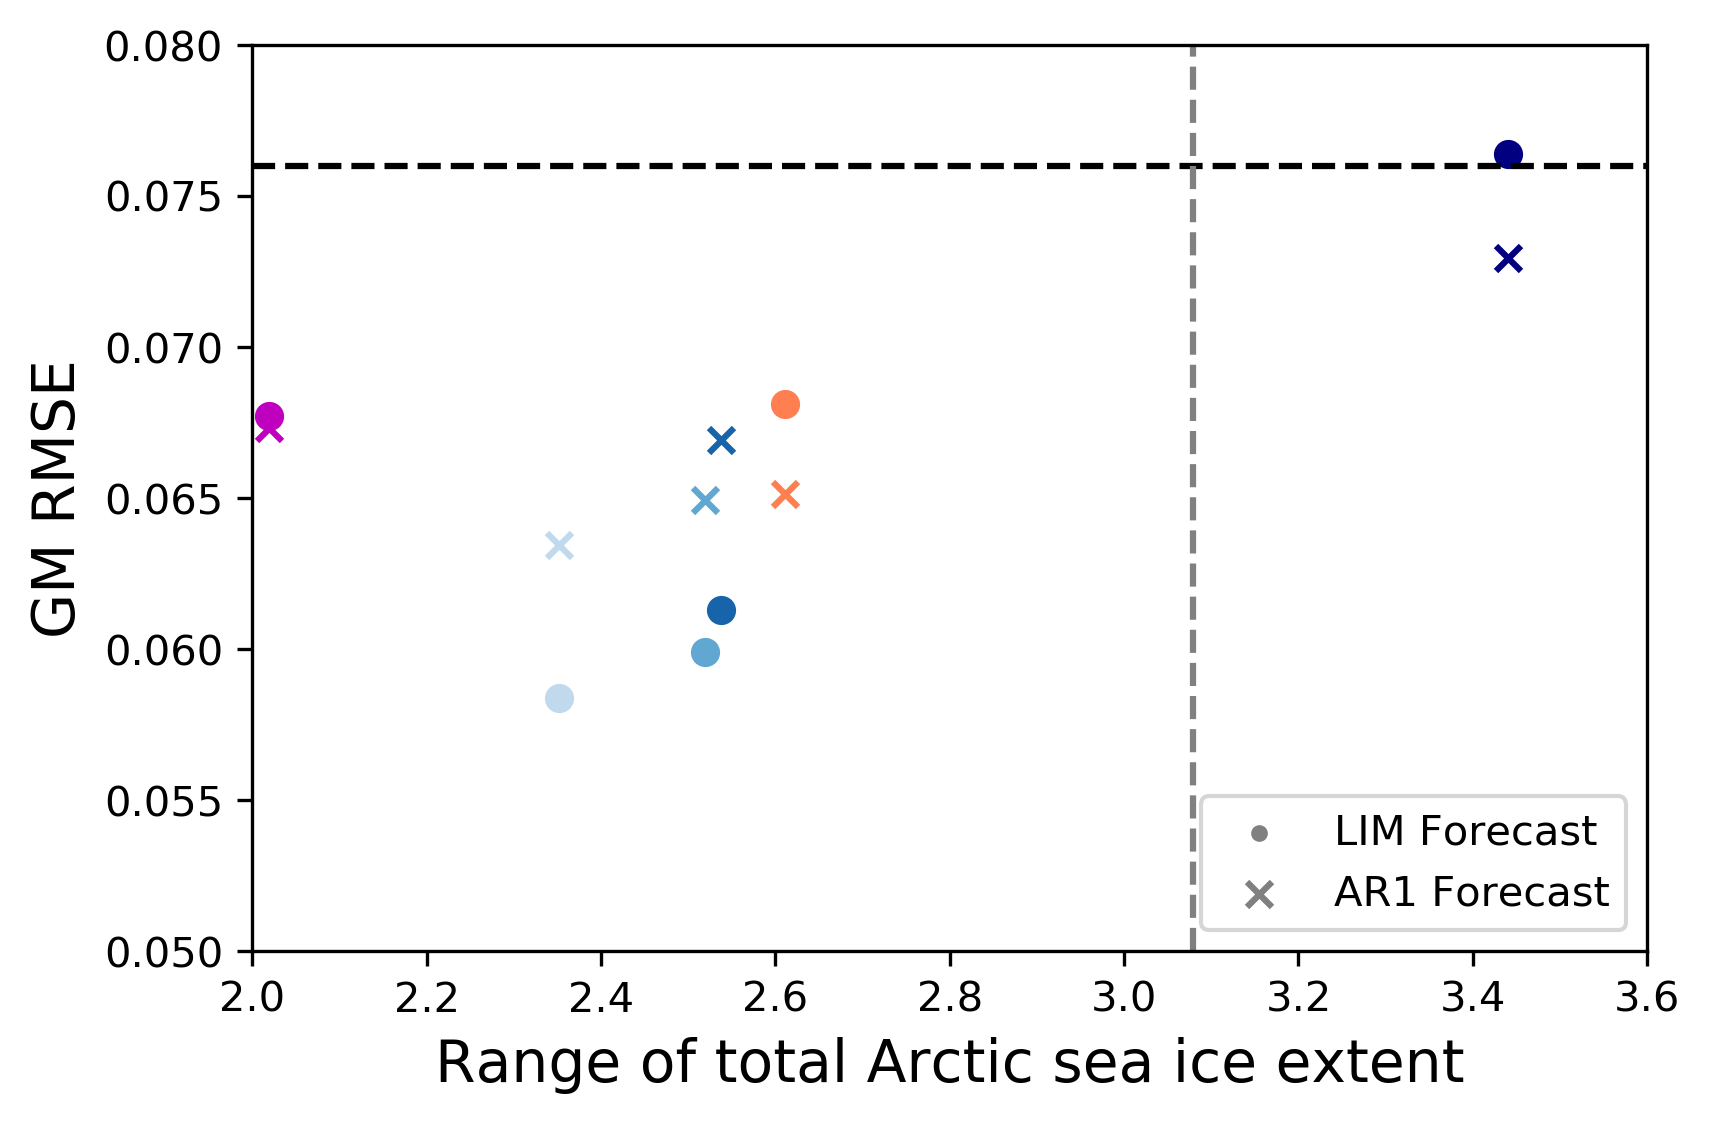

In [43]:
plt.scatter(cesm_lme1_sie_range,forecast_validation_lags_lme1['validation_stats_lags']['sic']['gm_rmse'][1], 
            color=colors[0])
plt.scatter(cesm_lme2_sie_range,forecast_validation_lags_lme2['validation_stats_lags']['sic']['gm_rmse'][1],
            color=colors[1])
plt.scatter(cesm_lme3_sie_range,forecast_validation_lags_lme3['validation_stats_lags']['sic']['gm_rmse'][1],
            color=colors[2])

plt.scatter(cesm_le_sie_range,forecast_validation_lags_le['validation_stats_lags']['sic']['gm_rmse'][1], 
            color='navy')
plt.scatter(era5_sie_range,forecast_validation_lags_era5['validation_stats_lags']['sic']['gm_rmse'][1], 
            color='coral')
plt.scatter(cesm2_hist1_sie_range,forecast_validation_lags_cesm2_hist1['validation_stats_lags']['sic']['gm_rmse'][1], 
            color='m')

plt.scatter(cesm_lme1_sie_range,ar1cast_lags_lme1['validation_stats_ar1_lags']['sic']['gm_rmse'][0], 
            color=colors[0], marker='x')
plt.scatter(cesm_lme2_sie_range,ar1cast_lags_lme2['validation_stats_ar1_lags']['sic']['gm_rmse'][0],
            color=colors[1], marker='x')
plt.scatter(cesm_lme3_sie_range,ar1cast_lags_lme3['validation_stats_ar1_lags']['sic']['gm_rmse'][0],
            color=colors[2], marker='x')

plt.scatter(cesm_le_sie_range,ar1cast_lags_le['validation_stats_ar1_lags']['sic']['gm_rmse'][0], 
            color='navy', marker='x')
plt.scatter(era5_sie_range,ar1cast_lags_era5['validation_stats_ar1_lags']['sic']['gm_rmse'][0], 
            color='coral', marker='x')
plt.scatter(cesm2_hist1_sie_range,ar1cast_lags_cesm2_hist1['validation_stats_ar1_lags']['sic']['gm_rmse'][0], 
            color='m', marker='x')

plt.scatter(-0.5,-0.5, color='gray', marker='.', label='LIM Forecast')
plt.scatter(-0.5,-0.5, color='gray', marker='x', label='AR1 Forecast')

plt.xlabel('Range of total Arctic sea ice extent', fontsize=14)
plt.ylabel('GM RMSE', fontsize=14)

plt.xlim(2,3.6)
plt.ylim(0.05,0.080)
plt.legend(loc = 'lower right')

plt.axhline(0.076, color='k', linestyle='--')
plt.axvline(cesm_lme_sie_range, color='gray', linestyle='--')

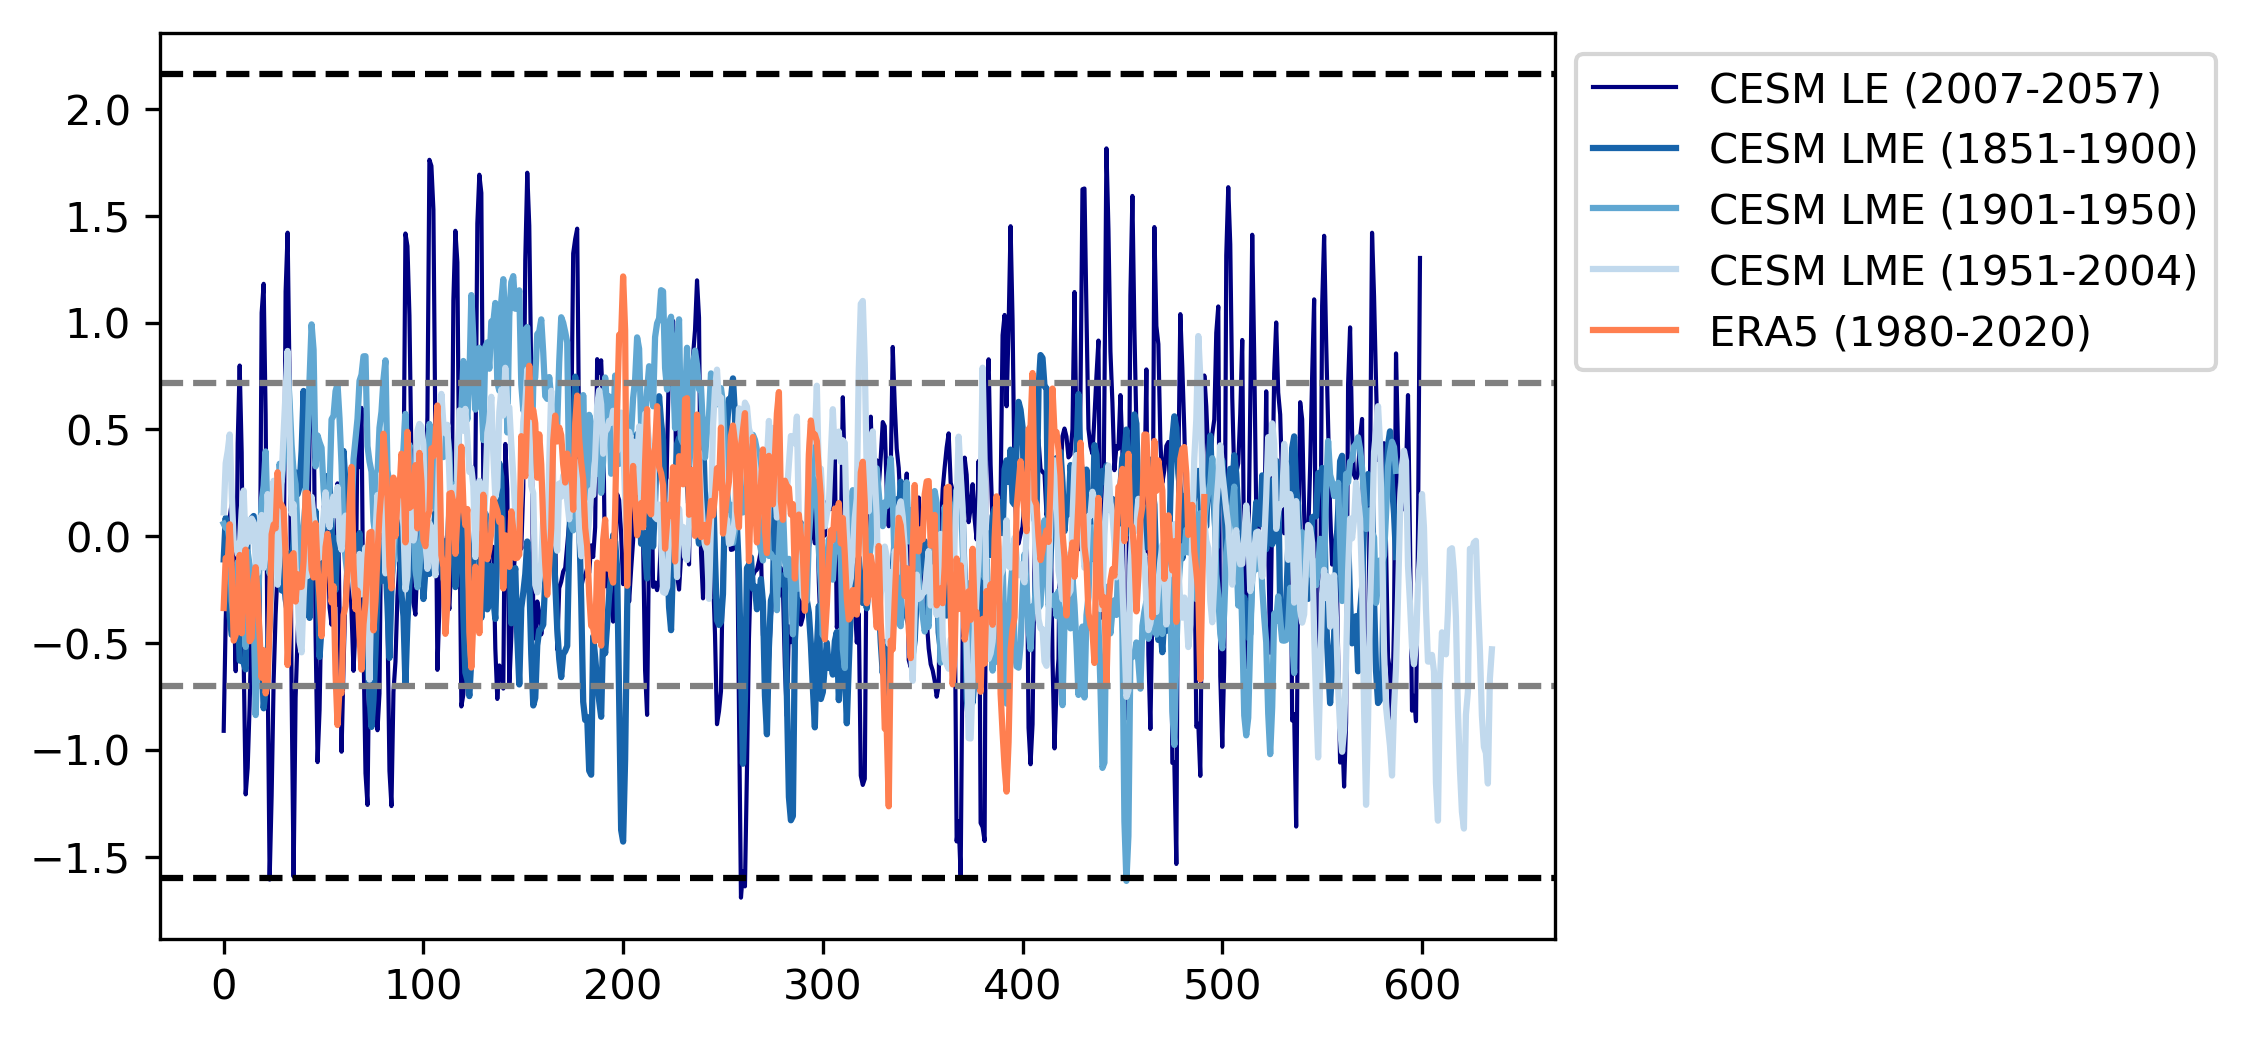

In [60]:
#plt.plot(tot_sia['CESM_LME_851_1850'][0:800*12], label = 'CESM LME (850-1650)', color='k', linewidth=1)

plt.plot(tot_sia['CESM_LE_2006_2100'][12:51*12], label = 'CESM LE (2007-2057)', color='navy', linewidth=1)

plt.plot(tot_sia['CESM_LME_1851_2005'][12:50*12],label = 'CESM LME (1851-1900)', color=colors[0])
plt.plot(tot_sia['CESM_LME_1851_2005'][51*12:100*12],label = 'CESM LME (1901-1950)', color=colors[1])
plt.plot(tot_sia['CESM_LME_1851_2005'][101*12:154*12],label = 'CESM LME (1951-2004)', color=colors[2])

plt.plot(tot_sia['ERA5_1980_2020'],label = 'ERA5 (1980-2020)', color='coral')

plt.legend(bbox_to_anchor=[1,1])
plt.axhline(np.nanmax(tot_sia['CESM_LME_851_1850'][0:800*12]),color='k',linestyle='--')
plt.axhline(np.nanmin(tot_sia['CESM_LME_851_1850'][0:800*12]),color='k',linestyle='--')

plt.axhline(np.percentile(tot_sia['CESM_LME_851_1850'][0:800*12],97.5),color='gray',linestyle='--')
plt.axhline(np.percentile(tot_sia['CESM_LME_851_1850'][0:800*12],2.5),color='gray',linestyle='--')

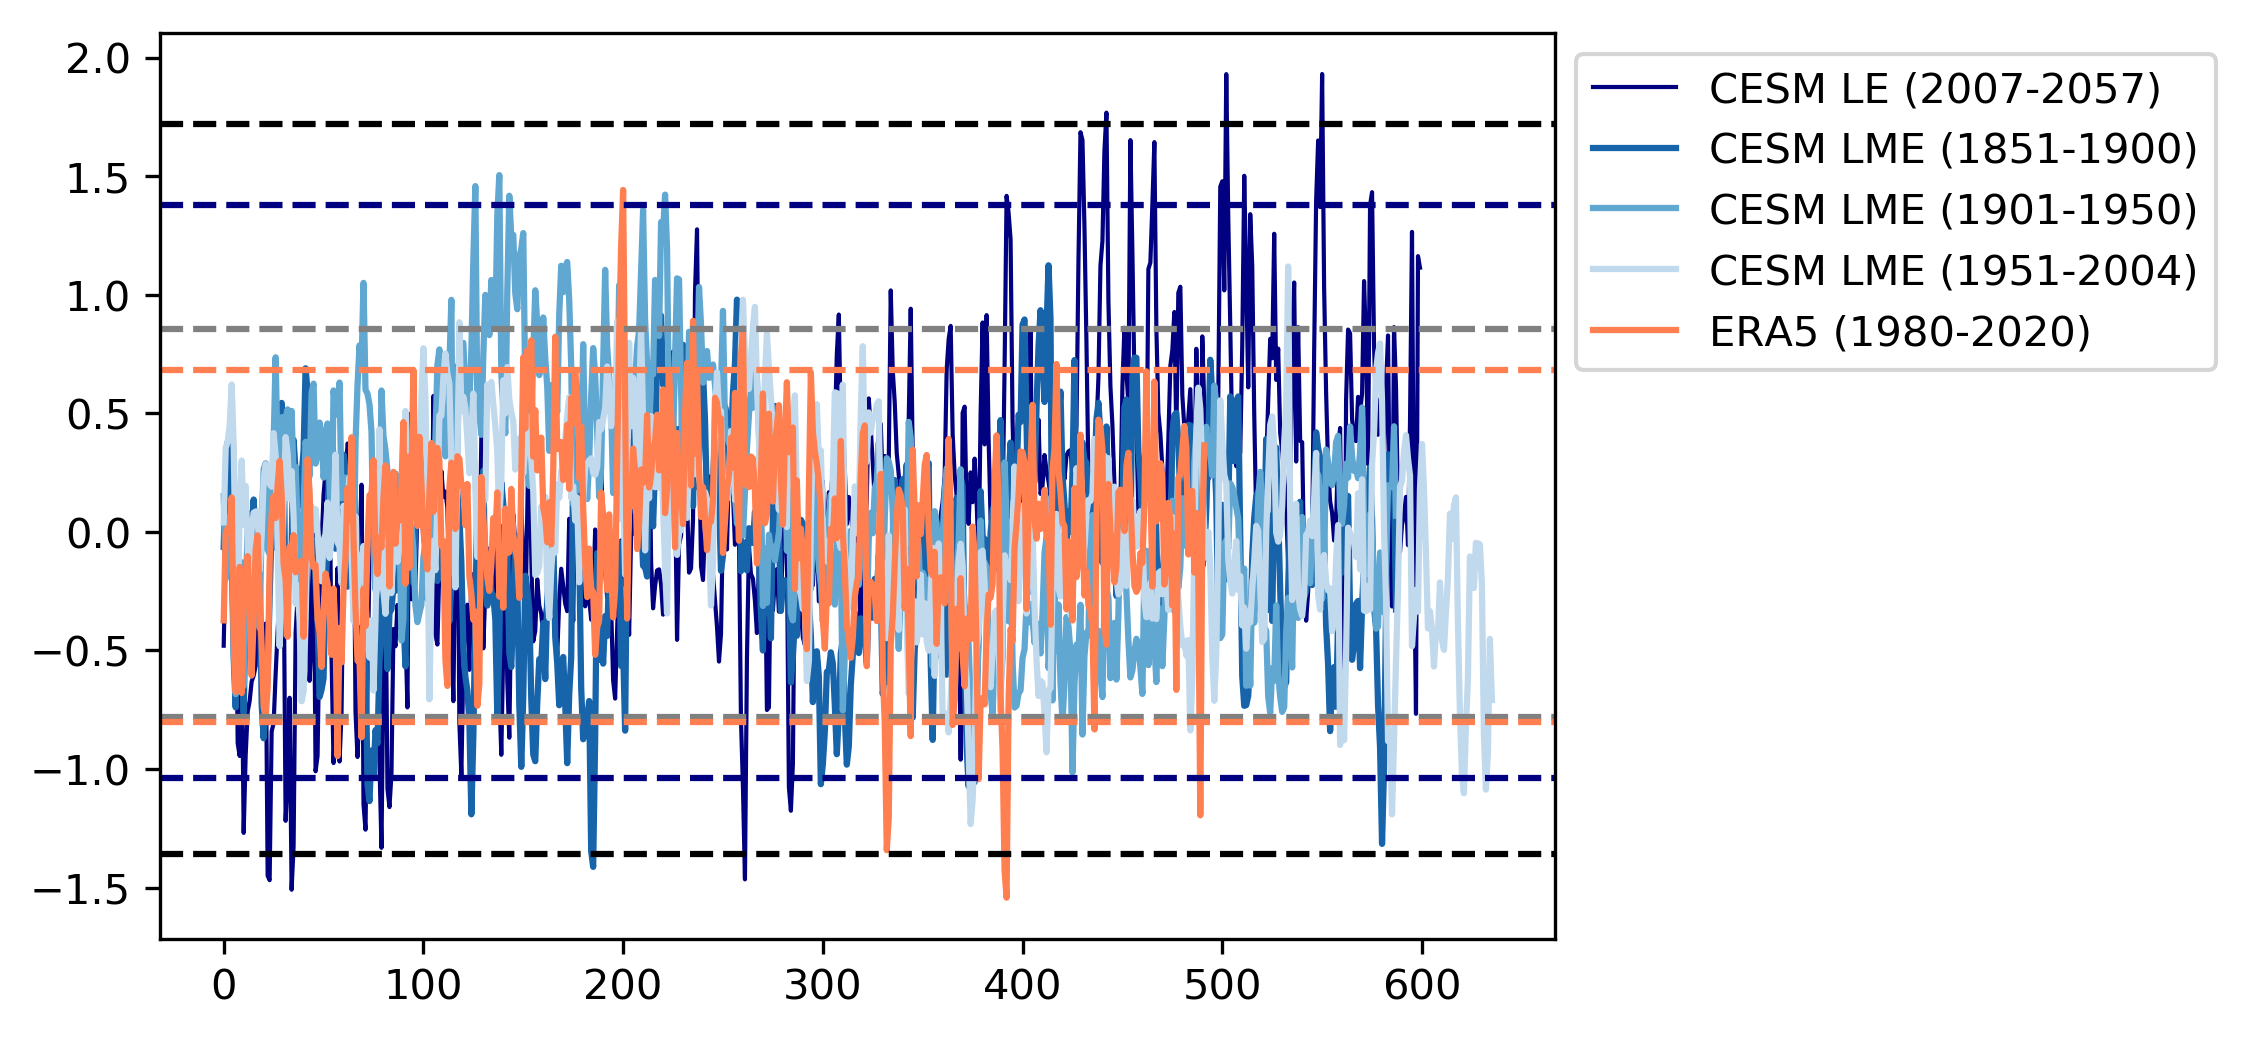

In [62]:
#plt.plot(tot_sie['CESM_LME_851_1850'][0:800*12], label = 'CESM LME (850-1650)', color='k', linewidth=1)

plt.plot(tot_sie['CESM_LE_2006_2100'][12:51*12], label = 'CESM LE (2007-2057)', color='navy', linewidth=1)

plt.plot(tot_sie['CESM_LME_1851_2005'][12:50*12],label = 'CESM LME (1851-1900)', color=colors[0])
plt.plot(tot_sie['CESM_LME_1851_2005'][51*12:100*12],label = 'CESM LME (1901-1950)', color=colors[1])
plt.plot(tot_sie['CESM_LME_1851_2005'][101*12:154*12],label = 'CESM LME (1951-2004)', color=colors[2])

plt.plot(tot_sie['ERA5_1980_2020'],label = 'ERA5 (1980-2020)', color='coral')

plt.legend(bbox_to_anchor=[1,1])
plt.axhline(np.nanmax(tot_sie['CESM_LME_851_1850'][0:800*12]),color='k',linestyle='--')
plt.axhline(np.nanmin(tot_sie['CESM_LME_851_1850'][0:800*12]),color='k',linestyle='--')

plt.axhline(np.percentile(tot_sie['CESM_LME_851_1850'][0:800*12],97.5),color='gray',linestyle='--')
plt.axhline(np.percentile(tot_sie['CESM_LME_851_1850'][0:800*12],2.5),color='gray',linestyle='--')

plt.axhline(np.percentile(tot_sie['ERA5_1980_2020'],97.5),color='coral',linestyle='--')
plt.axhline(np.percentile(tot_sie['ERA5_1980_2020'],2.5),color='coral',linestyle='--')

plt.axhline(np.percentile(tot_sie['CESM_LE_2006_2100'][12:51*12],97.5),color='navy',linestyle='--')
plt.axhline(np.percentile(tot_sie['CESM_LE_2006_2100'][12:51*12],2.5),color='navy',linestyle='--')

In [25]:
#filename = 'Spatial_correlation_sic_meanstates_CESMlme_ERA5_CESMle.pkl'
filename = 'Spatial_correlation_sic_variance_CESMlme_ERA5_CESMle_CESM2_GFDL.pkl'
scorr = pickle.load( open( filename, "rb" ) )

In [26]:
scorr.keys()

dict_keys(['scor_train_le', 'scor_train_era5', 'scor_train_sat', 'scor_lme3_sat', 'scor_le_sat', 'scor_cesm2_sat', 'scor_gfdl_sat', 'scor_train_mpi_lm', 'scor_train_mpi_lm_all', 'scor_train_ccsm4_lm', 'scor_train_ccsm4_lm_all', 'scor_train_lme1', 'scor_train_lme2', 'scor_train_lme3', 'scor_train_cesm2_hist1', 'scor_train_cesm2_hist2', 'scor_train_cesm2_hist3', 'scor_train_cesm2_hist', 'scor_train_gfdl_hist1', 'scor_train_gfdl_hist2', 'scor_train_gfdl_hist3', 'scor_train_gfdl_hist', 'scor_train_mpi_hist1', 'scor_train_mpi_hist2', 'scor_train_mpi_hist3', 'scor_train_mpi_hist'])

In [29]:
scorr['scor_gfdl_sat']

0.7306543535046578

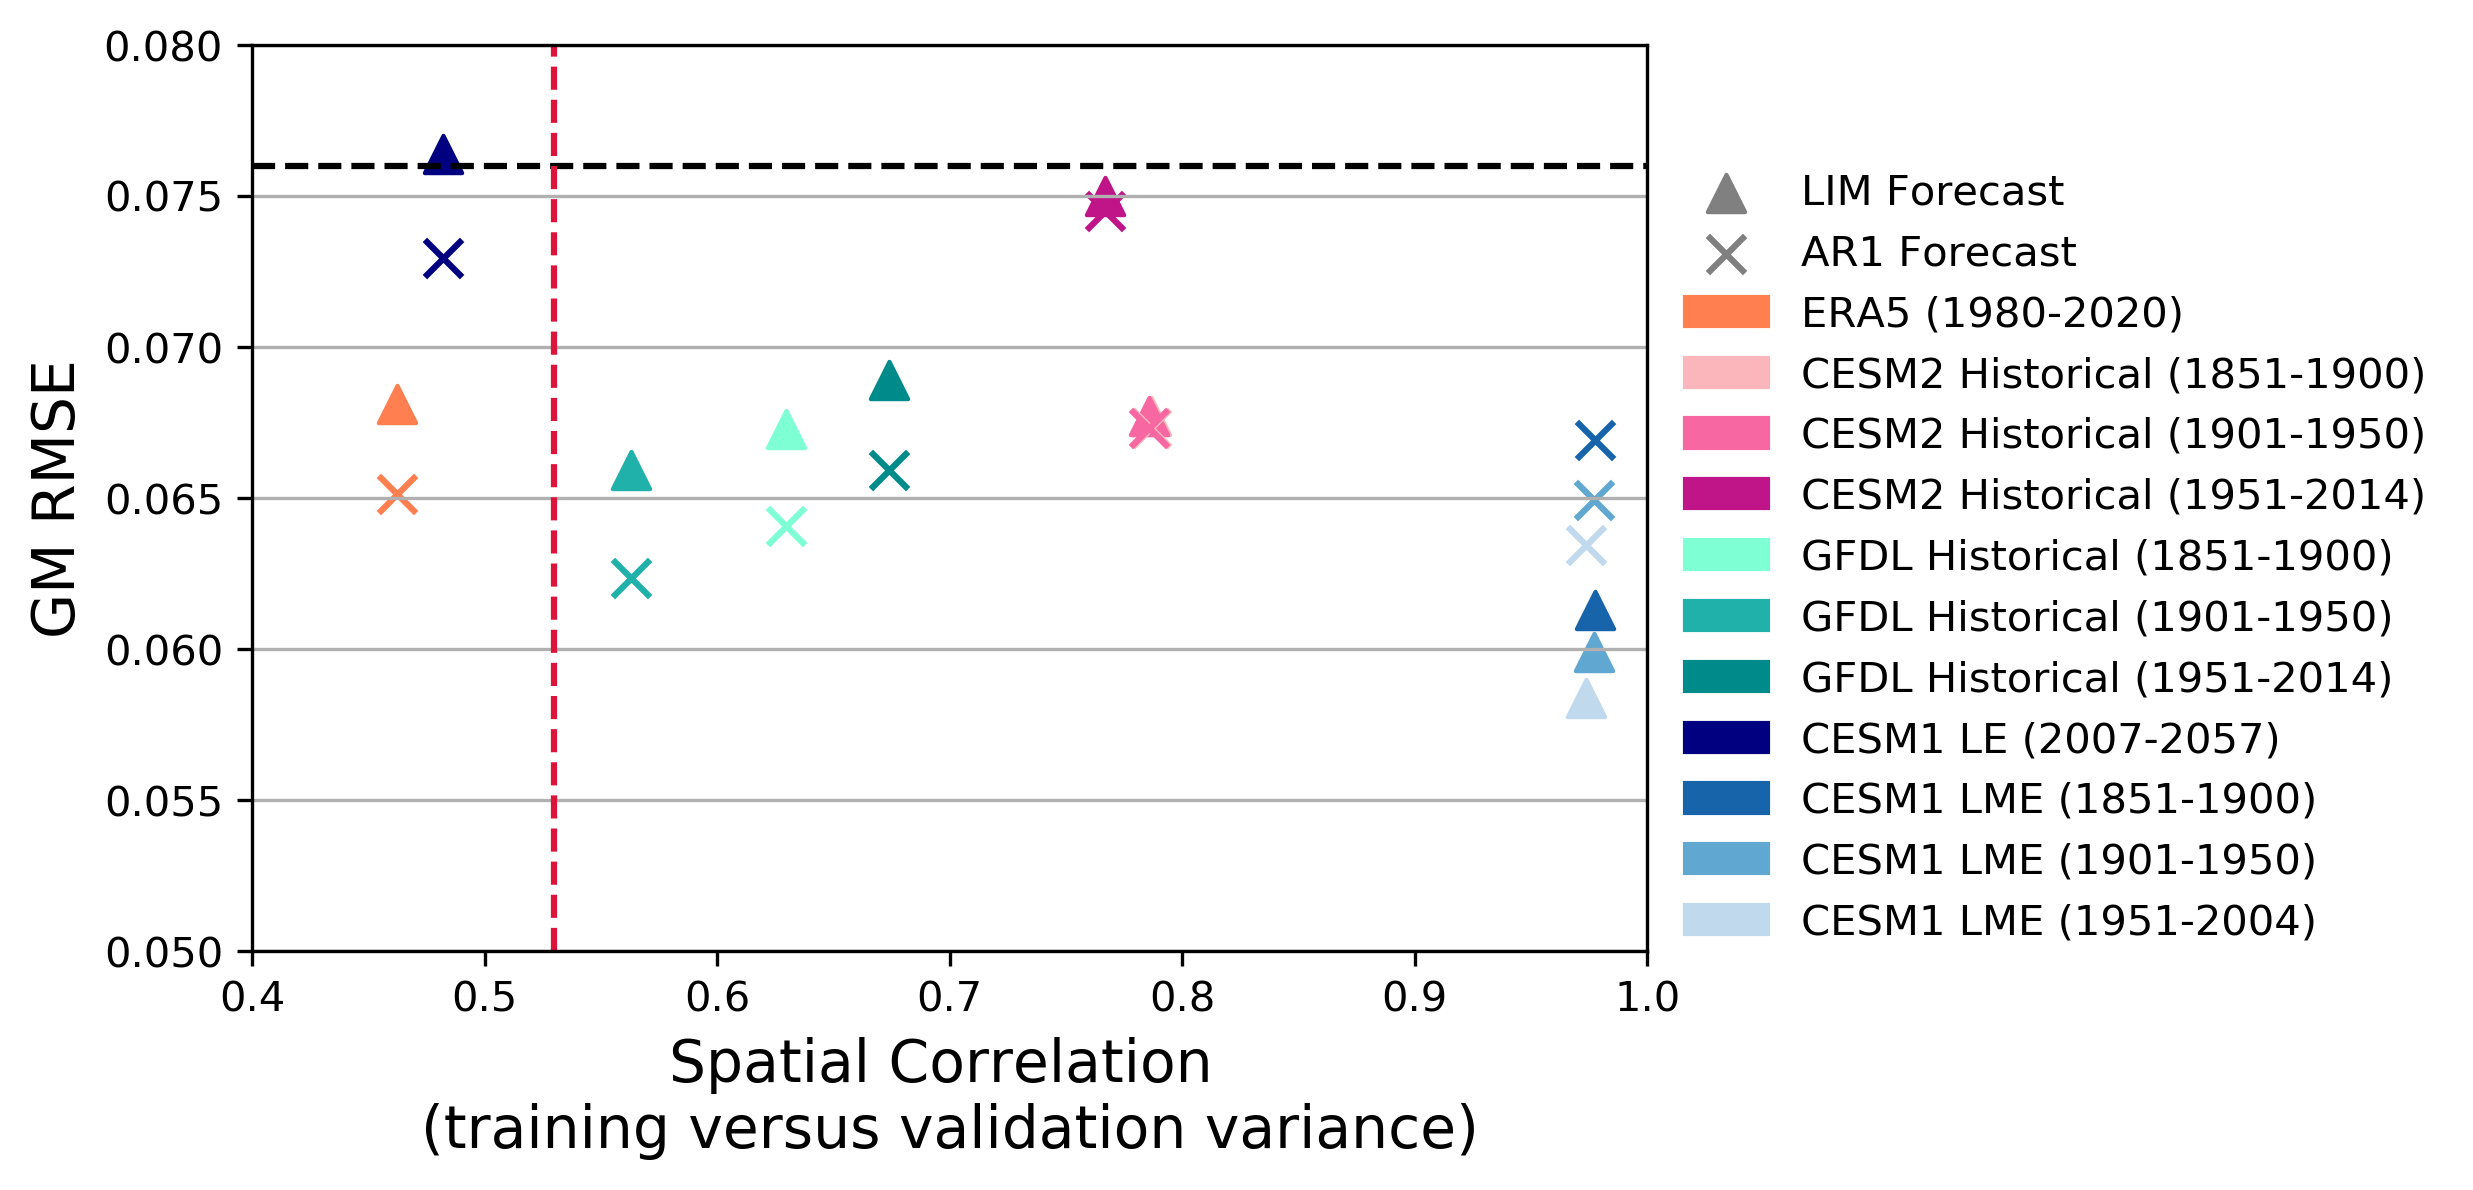

In [30]:
fig = plt.figure(figsize=(6,4))

plt.scatter(scorr['scor_train_lme1'],forecast_validation_lags_lme1['validation_stats_lags']['sic']['gm_rmse'][1], 
            color=colors[0],marker='^',s=80)
plt.scatter(scorr['scor_train_lme2'],forecast_validation_lags_lme2['validation_stats_lags']['sic']['gm_rmse'][1],
            color=colors[1],marker='^',s=80)
plt.scatter(scorr['scor_train_lme3'],forecast_validation_lags_lme3['validation_stats_lags']['sic']['gm_rmse'][1],
            color=colors[2],marker='^',s=80)

plt.scatter(scorr['scor_train_le'],forecast_validation_lags_le['validation_stats_lags']['sic']['gm_rmse'][1], 
            color='navy',marker='^',s=80)
plt.scatter(scorr['scor_train_era5'],forecast_validation_lags_era5['validation_stats_lags']['sic']['gm_rmse'][1], 
            color='coral',marker='^',s=80)
plt.scatter(scorr['scor_train_cesm2_hist1'],forecast_validation_lags_cesm2_hist1['validation_stats_lags']['sic']['gm_rmse'][1], 
            color=colors1[0],marker='^',s=80)
plt.scatter(scorr['scor_train_cesm2_hist2'],forecast_validation_lags_cesm2_hist2['validation_stats_lags']['sic']['gm_rmse'][1], 
            color=colors1[1],marker='^',s=80)
plt.scatter(scorr['scor_train_cesm2_hist3'],forecast_validation_lags_cesm2_hist3['validation_stats_lags']['sic']['gm_rmse'][1], 
            color=colors1[2],marker='^',s=80)

plt.scatter(scorr['scor_train_gfdl_hist1'],forecast_validation_lags_gfdl_hist1['validation_stats_lags']['sic']['gm_rmse'][1], 
            color='aquamarine',marker='^',s=80)
plt.scatter(scorr['scor_train_gfdl_hist2'],forecast_validation_lags_gfdl_hist2['validation_stats_lags']['sic']['gm_rmse'][1], 
            color='lightseagreen',marker='^',s=80)
plt.scatter(scorr['scor_train_gfdl_hist3'],forecast_validation_lags_gfdl_hist3['validation_stats_lags']['sic']['gm_rmse'][1], 
            color='darkcyan',marker='^',s=80)


plt.scatter(scorr['scor_train_lme1'],ar1cast_lags_lme1['validation_stats_ar1_lags']['sic']['gm_rmse'][0], 
            color=colors[0], marker='x',s=80)
plt.scatter(scorr['scor_train_lme2'],ar1cast_lags_lme2['validation_stats_ar1_lags']['sic']['gm_rmse'][0],
            color=colors[1], marker='x',s=80)
plt.scatter(scorr['scor_train_lme3'],ar1cast_lags_lme3['validation_stats_ar1_lags']['sic']['gm_rmse'][0],
            color=colors[2], marker='x',s=80)

plt.scatter(scorr['scor_train_le'],ar1cast_lags_le['validation_stats_ar1_lags']['sic']['gm_rmse'][0], 
            color='navy', marker='x',s=80)
plt.scatter(scorr['scor_train_era5'],ar1cast_lags_era5['validation_stats_ar1_lags']['sic']['gm_rmse'][0], 
            color='coral', marker='x',s=80)
plt.scatter(scorr['scor_train_cesm2_hist1'],ar1cast_lags_cesm2_hist1['validation_stats_ar1_lags']['sic']['gm_rmse'][0], 
            color=colors1[0], marker='x',s=80)
plt.scatter(scorr['scor_train_cesm2_hist2'],ar1cast_lags_cesm2_hist2['validation_stats_ar1_lags']['sic']['gm_rmse'][0], 
            color=colors1[1], marker='x',s=80)
plt.scatter(scorr['scor_train_cesm2_hist3'],ar1cast_lags_cesm2_hist3['validation_stats_ar1_lags']['sic']['gm_rmse'][0], 
            color=colors1[2], marker='x',s=80)

plt.scatter(scorr['scor_train_gfdl_hist1'],ar1cast_lags_gfdl_hist1['validation_stats_ar1_lags']['sic']['gm_rmse'][0], 
            color='aquamarine', marker='x',s=80)
plt.scatter(scorr['scor_train_gfdl_hist2'],ar1cast_lags_gfdl_hist2['validation_stats_ar1_lags']['sic']['gm_rmse'][0], 
            color='lightseagreen', marker='x',s=80)
plt.scatter(scorr['scor_train_gfdl_hist3'],ar1cast_lags_gfdl_hist3['validation_stats_ar1_lags']['sic']['gm_rmse'][0], 
            color='darkcyan', marker='x',s=80)

plt.scatter(-0.5,-0.5, color='gray', marker='^', s=80, label='LIM Forecast')
plt.scatter(-0.5,-0.5, color='gray', marker='x', s=80, label='AR1 Forecast')

x = np.arange(-0.05,-0.01,0.01)
plt.fill_betweenx(x,np.sin(x), color='coral', label='ERA5 (1980-2020)')
plt.fill_betweenx(x,np.sin(x), color=colors1[0], label='CESM2 Historical (1851-1900)')
plt.fill_betweenx(x,np.sin(x), color=colors1[1], label='CESM2 Historical (1901-1950)')
plt.fill_betweenx(x,np.sin(x), color=colors1[2], label='CESM2 Historical (1951-2014)')
plt.fill_betweenx(x,np.sin(x), color='aquamarine', label='GFDL Historical (1851-1900)')
plt.fill_betweenx(x,np.sin(x), color='lightseagreen', label='GFDL Historical (1901-1950)')
plt.fill_betweenx(x,np.sin(x), color='darkcyan', label='GFDL Historical (1951-2014)')
plt.fill_betweenx(x,np.sin(x), color='navy', label='CESM1 LE (2007-2057)')
plt.fill_betweenx(x,np.sin(x), color=colors[0], label='CESM1 LME (1851-1900)')
plt.fill_betweenx(x,np.sin(x), color=colors[1], label='CESM1 LME (1901-1950)')
plt.fill_betweenx(x,np.sin(x), color=colors[2], label='CESM1 LME (1951-2004)')

plt.xlabel('Spatial Correlation \n(training versus validation variance)', fontsize=14)
plt.ylabel('GM RMSE', fontsize=14)

plt.xlim(0.4,1.0)
plt.ylim(0.05,0.08)
plt.legend(bbox_to_anchor=[1,0.9], fontsize=10, frameon=False)
plt.grid(axis='y')

plt.axhline(0.076, color='k', linestyle='--')
plt.axvline(scorr['scor_train_sat'], color='crimson', linestyle='--')

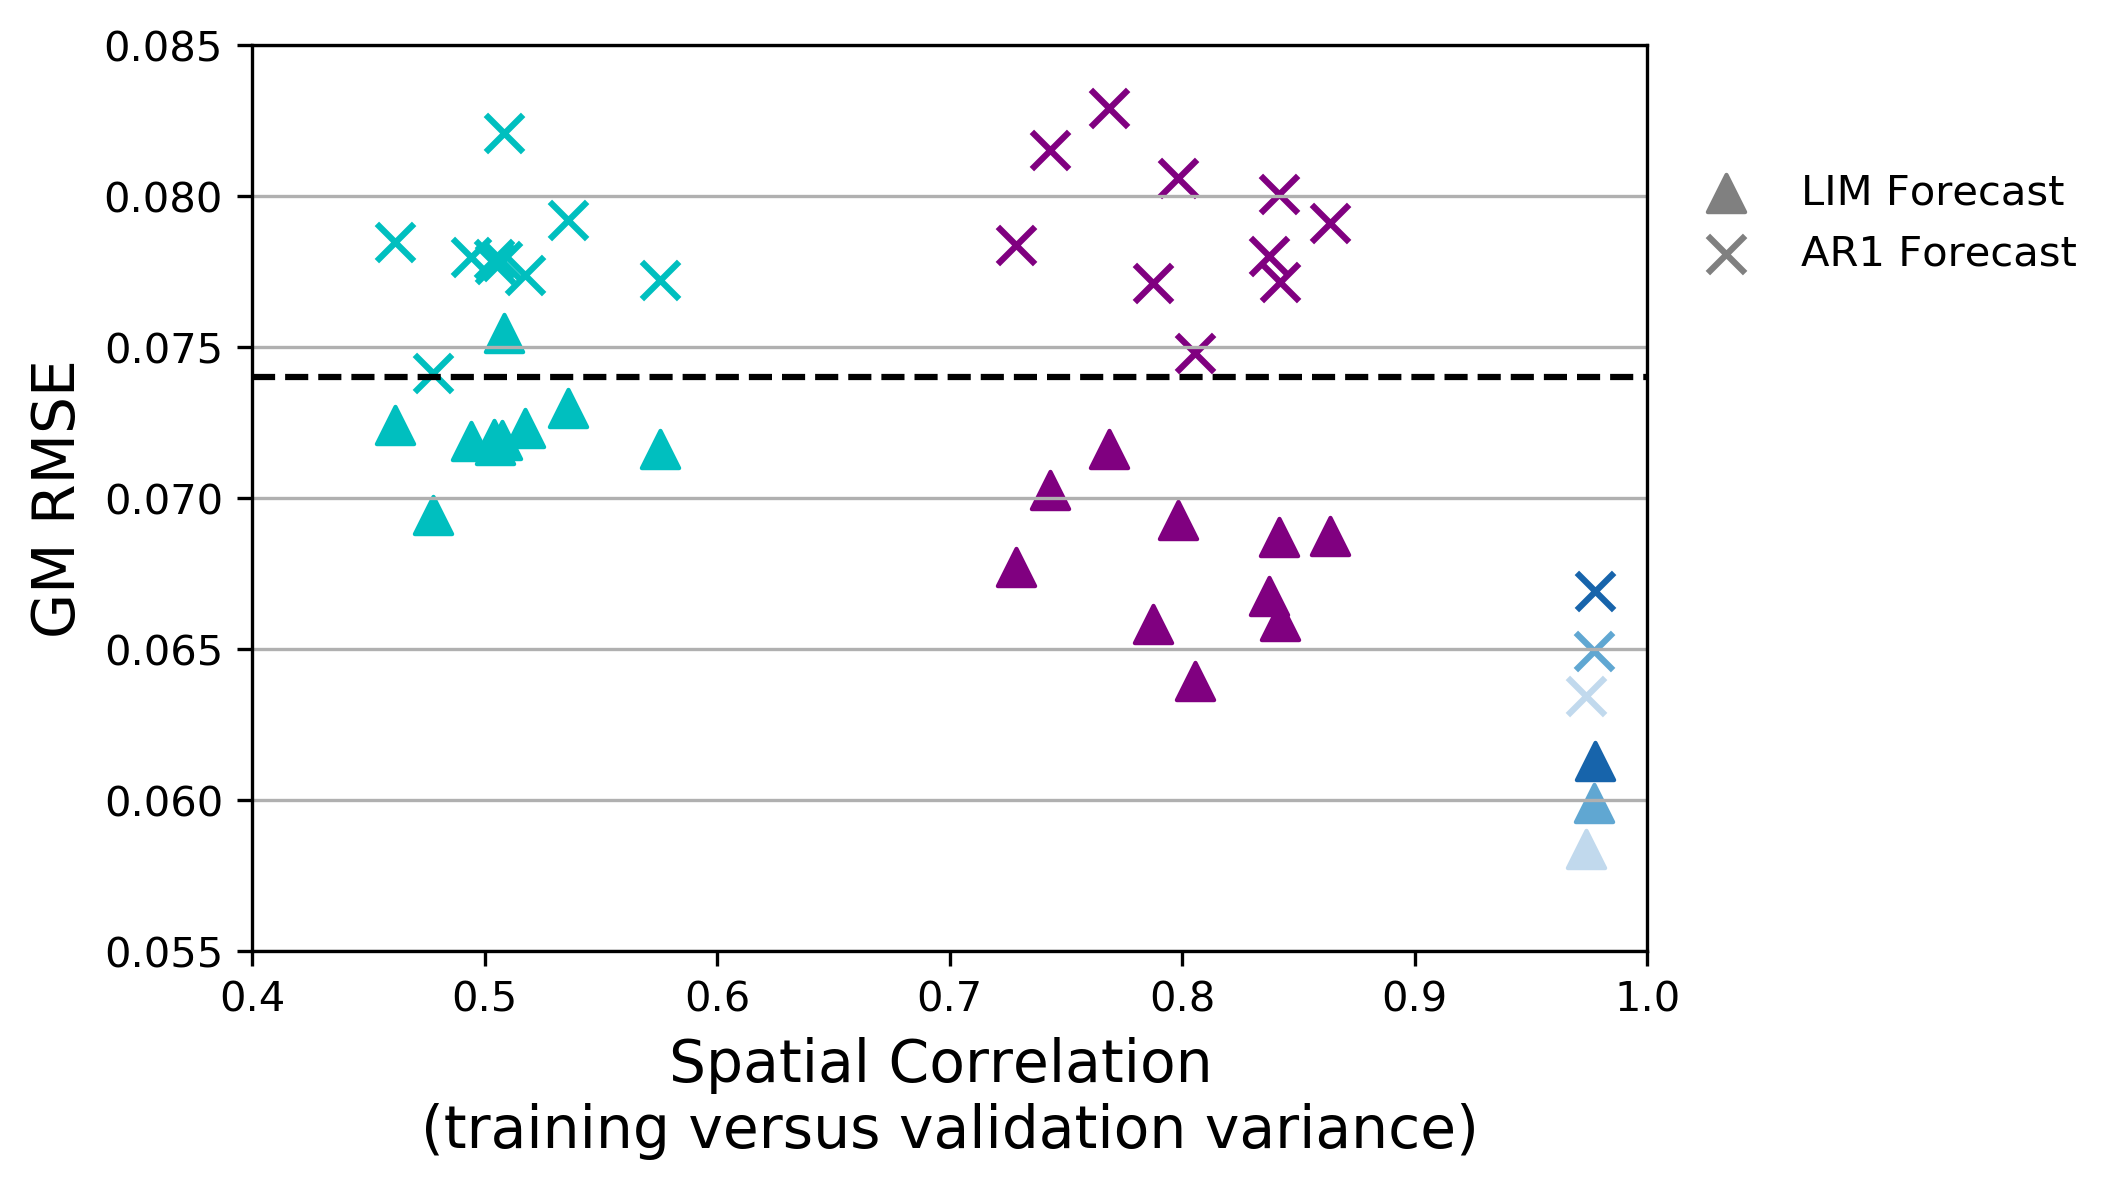

In [44]:
fig = plt.figure(figsize=(6,4))

plt.scatter(scorr['scor_train_lme1'],forecast_validation_lags_lme1['validation_stats_lags']['sic']['gm_rmse'][1], 
            color=colors[0],marker='^',s=80)
plt.scatter(scorr['scor_train_lme2'],forecast_validation_lags_lme2['validation_stats_lags']['sic']['gm_rmse'][1],
            color=colors[1],marker='^',s=80)
plt.scatter(scorr['scor_train_lme3'],forecast_validation_lags_lme3['validation_stats_lags']['sic']['gm_rmse'][1],
            color=colors[2],marker='^',s=80)

plt.scatter(scorr['scor_train_lme1'],ar1cast_lags_lme1['validation_stats_ar1_lags']['sic']['gm_rmse'][0], 
            color=colors[0], marker='x',s=80)
plt.scatter(scorr['scor_train_lme2'],ar1cast_lags_lme2['validation_stats_ar1_lags']['sic']['gm_rmse'][0],
            color=colors[1], marker='x',s=80)
plt.scatter(scorr['scor_train_lme3'],ar1cast_lags_lme3['validation_stats_ar1_lags']['sic']['gm_rmse'][0],
            color=colors[2], marker='x',s=80)

for i,startyr in enumerate(startyrs_list):
    plt.scatter(scorr['scor_train_ccsm4_lm_all'][startyr-850],gm_rmse_ccsm4_sic[i,0], 
                color='purple',marker='^',s=80)
    plt.scatter(scorr['scor_train_mpi_lm_all'][startyr-850],gm_rmse_mpi_sic[i,0], 
                color='c',marker='^',s=80)
    
    plt.scatter(scorr['scor_train_ccsm4_lm_all'][startyr-850],gm_rmse_ar1_ccsm4_sic[i,0], 
                color='purple',marker='x',s=80)
    plt.scatter(scorr['scor_train_mpi_lm_all'][startyr-850],gm_rmse_ar1_mpi_sic[i,0], 
                color='c',marker='x',s=80)

plt.scatter(-0.5,-0.5, color='gray', marker='^', s=80, label='LIM Forecast')
plt.scatter(-0.5,-0.5, color='gray', marker='x', s=80, label='AR1 Forecast')

plt.xlabel('Spatial Correlation \n(training versus validation variance)', fontsize=14)
plt.ylabel('GM RMSE', fontsize=14)

plt.xlim(0.4,1.0)
plt.ylim(0.055,0.085)
plt.legend(bbox_to_anchor=[1,0.9], fontsize=10, frameon=False)
plt.grid(axis='y')

plt.axhline(0.074, color='k', linestyle='--')


In [66]:
scorr['scor_train_cesm2_hist1'],forecast_validation_lags_cesm2_hist1['validation_stats_lags']['sic']['gm_rmse'][1]

(0.7865500312468631, 0.06773449170038198)

In [99]:
scorr.keys()

dict_keys(['scor_train_le', 'scor_train_era5', 'scor_train_sat', 'scor_train_lme1', 'scor_train_lme2', 'scor_train_lme3', 'scor_train_cesm2_hist1', 'scor_train_cesm2_hist2', 'scor_train_cesm2_hist3', 'scor_train_cesm2_hist', 'scor_train_gfdl_hist1', 'scor_train_gfdl_hist2', 'scor_train_gfdl_hist3', 'scor_train_gfdl_hist'])

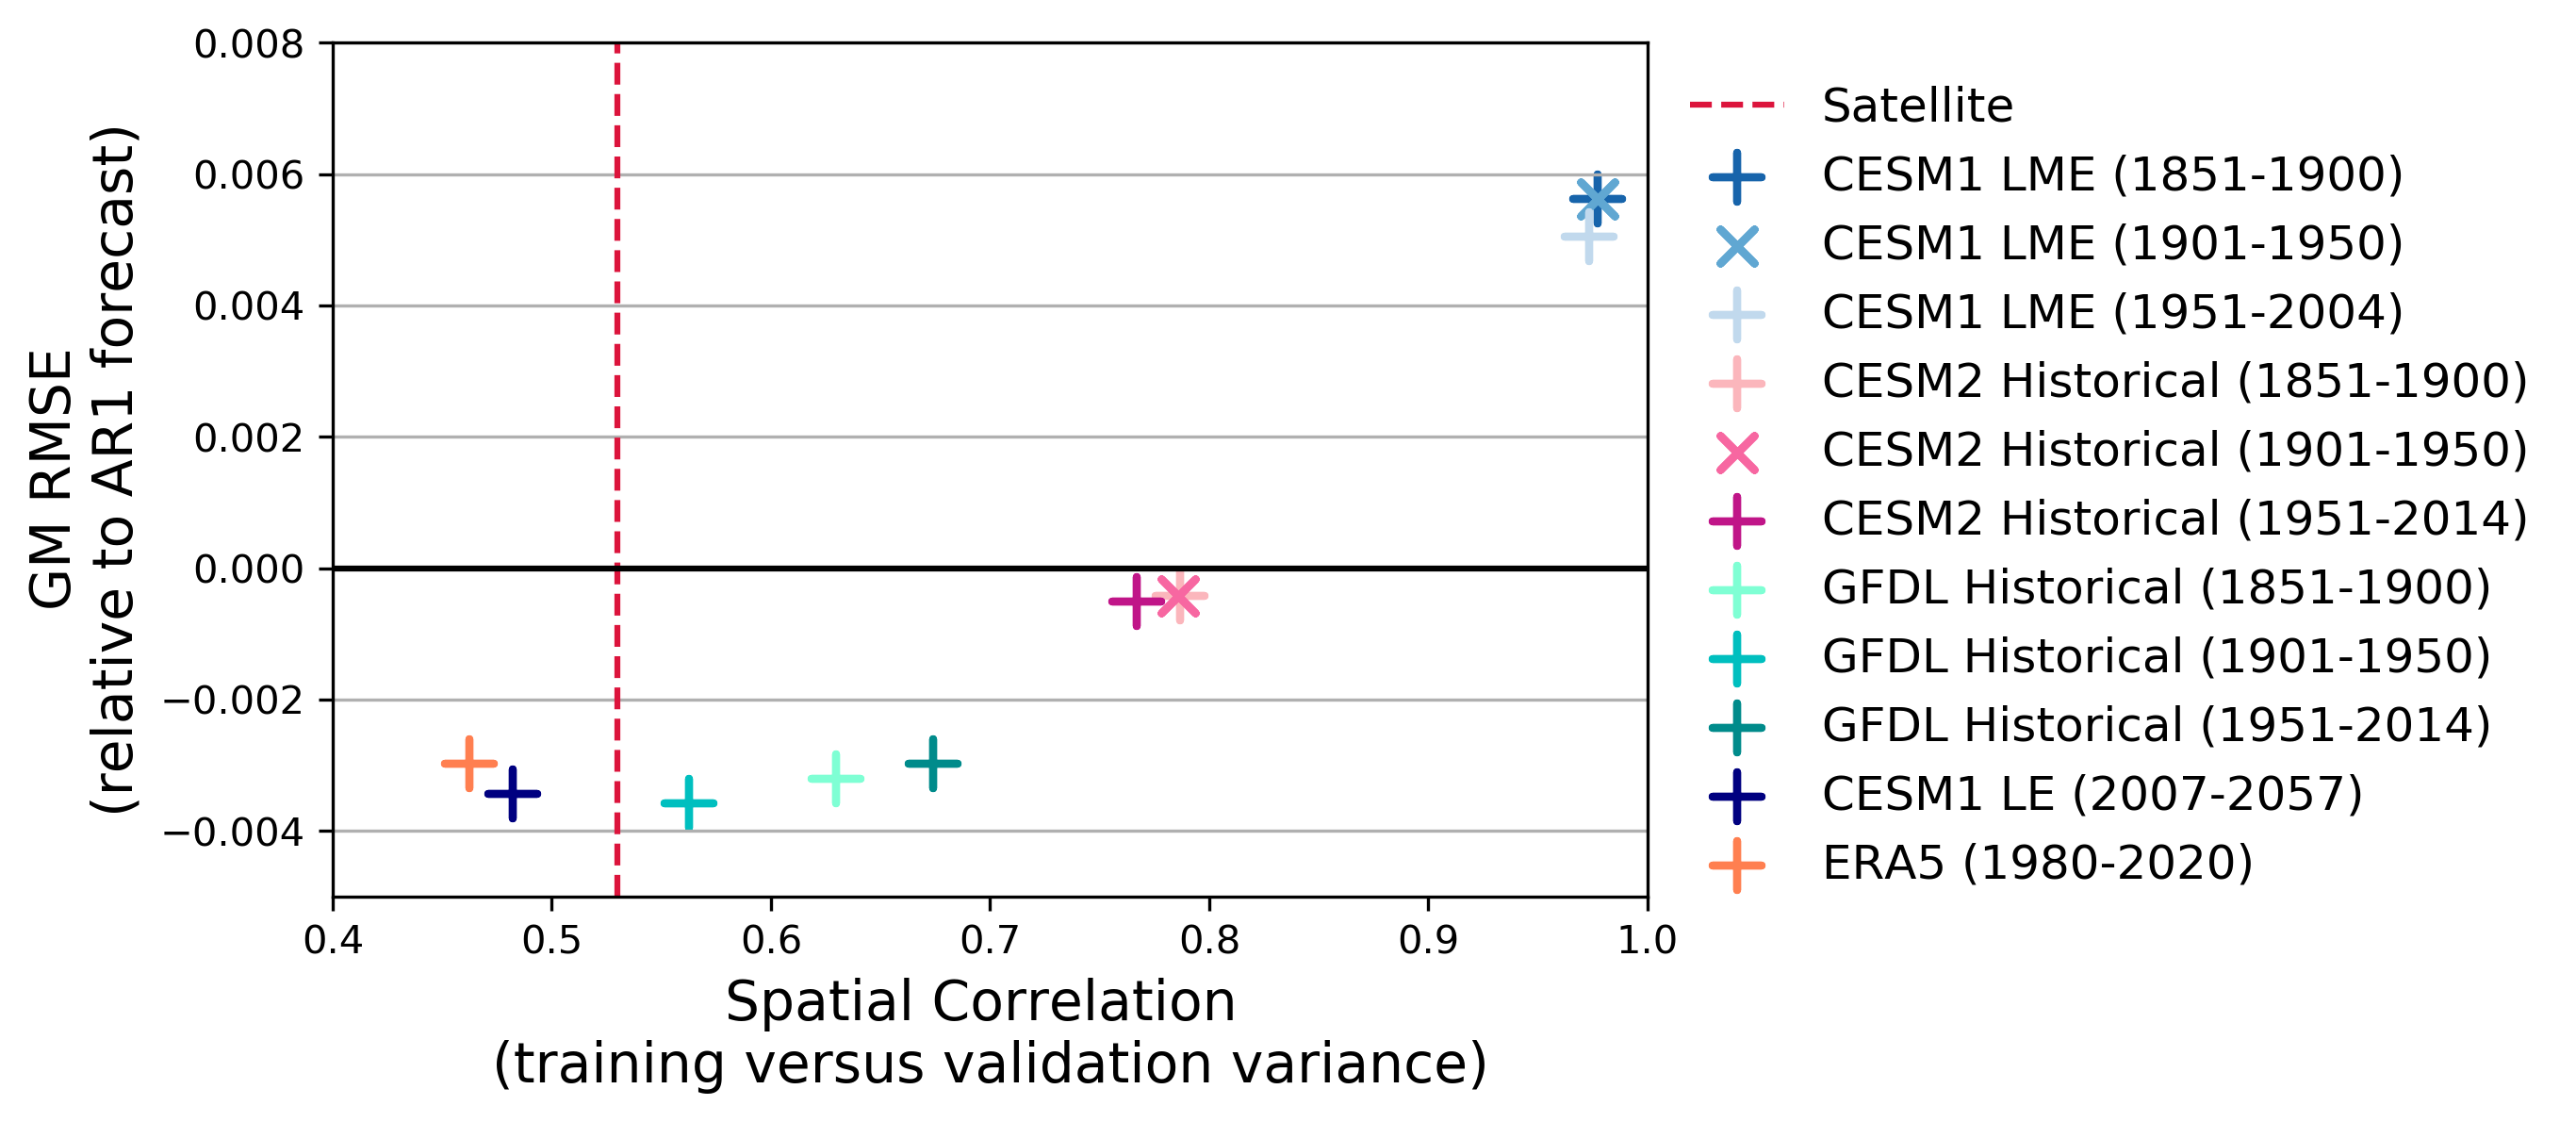

In [31]:
fig = plt.figure(figsize=(6,4))

diff_lme1 = ar1cast_lags_lme1['validation_stats_ar1_lags']['sic']['gm_rmse'][0] - forecast_validation_lags_lme1['validation_stats_lags']['sic']['gm_rmse'][1]
diff_lme2 = ar1cast_lags_lme2['validation_stats_ar1_lags']['sic']['gm_rmse'][0] - forecast_validation_lags_lme2['validation_stats_lags']['sic']['gm_rmse'][1]
diff_lme3 = ar1cast_lags_lme3['validation_stats_ar1_lags']['sic']['gm_rmse'][0] - forecast_validation_lags_lme3['validation_stats_lags']['sic']['gm_rmse'][1]

diff_le = ar1cast_lags_le['validation_stats_ar1_lags']['sic']['gm_rmse'][0] - forecast_validation_lags_le['validation_stats_lags']['sic']['gm_rmse'][1]
diff_era5 = ar1cast_lags_era5['validation_stats_ar1_lags']['sic']['gm_rmse'][0] - forecast_validation_lags_era5['validation_stats_lags']['sic']['gm_rmse'][1]

diff_cesm2_hist1 = ar1cast_lags_cesm2_hist1['validation_stats_ar1_lags']['sic']['gm_rmse'][0] - forecast_validation_lags_cesm2_hist1['validation_stats_lags']['sic']['gm_rmse'][1]
diff_cesm2_hist2 = ar1cast_lags_cesm2_hist2['validation_stats_ar1_lags']['sic']['gm_rmse'][0] - forecast_validation_lags_cesm2_hist2['validation_stats_lags']['sic']['gm_rmse'][1]
diff_cesm2_hist3 = ar1cast_lags_cesm2_hist3['validation_stats_ar1_lags']['sic']['gm_rmse'][0] - forecast_validation_lags_cesm2_hist3['validation_stats_lags']['sic']['gm_rmse'][1]

diff_gfdl_hist1 = ar1cast_lags_gfdl_hist1['validation_stats_ar1_lags']['sic']['gm_rmse'][0] - forecast_validation_lags_gfdl_hist1['validation_stats_lags']['sic']['gm_rmse'][1]
diff_gfdl_hist2 = ar1cast_lags_gfdl_hist2['validation_stats_ar1_lags']['sic']['gm_rmse'][0] - forecast_validation_lags_gfdl_hist2['validation_stats_lags']['sic']['gm_rmse'][1]
diff_gfdl_hist3 = ar1cast_lags_gfdl_hist3['validation_stats_ar1_lags']['sic']['gm_rmse'][0] - forecast_validation_lags_gfdl_hist3['validation_stats_lags']['sic']['gm_rmse'][1]

plt.scatter(scorr['scor_train_lme1'],diff_lme1, color=colors[0],marker=(4,2,0),s=150,
            linewidth=2,label='CESM1 LME (1851-1900)')
plt.scatter(scorr['scor_train_lme2'],diff_lme1,color=colors[1],marker=(4,2,45),s=150,
            linewidth=2,label='CESM1 LME (1901-1950)')
plt.scatter(scorr['scor_train_lme3'],diff_lme3,color=colors[2],marker=(4,2,0),s=150,
            linewidth=2,label='CESM1 LME (1951-2004)')

plt.scatter(scorr['scor_train_cesm2_hist1'],diff_cesm2_hist1,color=colors1[0],marker=(4,2,0),s=150,
            linewidth=2,label='CESM2 Historical (1851-1900)')
plt.scatter(scorr['scor_train_cesm2_hist2'],diff_cesm2_hist2, color=colors1[1],marker=(4,2,45),s=150,
            linewidth=2,label='CESM2 Historical (1901-1950)')
plt.scatter(scorr['scor_train_cesm2_hist3'],diff_cesm2_hist3, color=colors1[2],marker=(4,2,0),s=150,
            linewidth=2,label='CESM2 Historical (1951-2014)')

plt.scatter(scorr['scor_train_gfdl_hist1'],diff_gfdl_hist1,color='aquamarine',marker=(4,2,0),s=150,
            linewidth=2,label='GFDL Historical (1851-1900)')
plt.scatter(scorr['scor_train_gfdl_hist2'],diff_gfdl_hist2, color='c',marker=(4,2,0),s=150,
            linewidth=2,label='GFDL Historical (1901-1950)')
plt.scatter(scorr['scor_train_gfdl_hist3'],diff_gfdl_hist3, color='darkcyan',marker=(4,2,0),s=150,
            linewidth=2,label='GFDL Historical (1951-2014)')

plt.scatter(scorr['scor_train_le'],diff_le, color='navy',marker=(4,2,0),s=150,
            linewidth=2,label='CESM1 LE (2007-2057)')
plt.scatter(scorr['scor_train_era5'],diff_era5, color='coral',marker=(4,2,0),s=150, 
            linewidth=2,label='ERA5 (1980-2020)')

plt.axvline(scorr['scor_train_sat'], color='crimson', linestyle='--', label='Satellite')

plt.xlabel('Spatial Correlation \n(training versus validation variance)', fontsize=14)
plt.ylabel('GM RMSE \n(relative to AR1 forecast)', fontsize=14)

plt.xlim(0.4,1.0)
plt.ylim(-0.005,0.008)
plt.legend(bbox_to_anchor=[1,1], fontsize=12, frameon=False)
plt.grid(axis='y')

plt.axhline(0,color='k')

In [32]:
diff_lme1 = ar1cast_lags_lme1['validation_stats_ar1_lags']['sic']['gm_rmse'][0] - forecast_validation_lags_lme1['validation_stats_lags']['sic']['gm_rmse'][1]
diff_lme2 = ar1cast_lags_lme2['validation_stats_ar1_lags']['sic']['gm_rmse'][0] - forecast_validation_lags_lme2['validation_stats_lags']['sic']['gm_rmse'][1]
diff_lme3 = ar1cast_lags_lme3['validation_stats_ar1_lags']['sic']['gm_rmse'][0] - forecast_validation_lags_lme3['validation_stats_lags']['sic']['gm_rmse'][1]

diff_le = ar1cast_lags_le['validation_stats_ar1_lags']['sic']['gm_rmse'][0] - forecast_validation_lags_le['validation_stats_lags']['sic']['gm_rmse'][1]
diff_era5 = ar1cast_lags_era5['validation_stats_ar1_lags']['sic']['gm_rmse'][0] - forecast_validation_lags_era5['validation_stats_lags']['sic']['gm_rmse'][1]

diff_cesm2_hist1 = ar1cast_lags_cesm2_hist1['validation_stats_ar1_lags']['sic']['gm_rmse'][0] - forecast_validation_lags_cesm2_hist1['validation_stats_lags']['sic']['gm_rmse'][1]
diff_cesm2_hist2 = ar1cast_lags_cesm2_hist2['validation_stats_ar1_lags']['sic']['gm_rmse'][0] - forecast_validation_lags_cesm2_hist2['validation_stats_lags']['sic']['gm_rmse'][1]
diff_cesm2_hist3 = ar1cast_lags_cesm2_hist3['validation_stats_ar1_lags']['sic']['gm_rmse'][0] - forecast_validation_lags_cesm2_hist3['validation_stats_lags']['sic']['gm_rmse'][1]

diff_gfdl_hist1 = ar1cast_lags_gfdl_hist1['validation_stats_ar1_lags']['sic']['gm_rmse'][0] - forecast_validation_lags_gfdl_hist1['validation_stats_lags']['sic']['gm_rmse'][1]
diff_gfdl_hist2 = ar1cast_lags_gfdl_hist2['validation_stats_ar1_lags']['sic']['gm_rmse'][0] - forecast_validation_lags_gfdl_hist2['validation_stats_lags']['sic']['gm_rmse'][1]
diff_gfdl_hist3 = ar1cast_lags_gfdl_hist3['validation_stats_ar1_lags']['sic']['gm_rmse'][0] - forecast_validation_lags_gfdl_hist3['validation_stats_lags']['sic']['gm_rmse'][1]

diff_ccsm4 = np.zeros(len(startyrs_list))
diff_mpi = np.zeros(len(startyrs_list))
for i,startyr in enumerate(startyrs_list):
    diff_ccsm4[i] = gm_rmse_ar1_ccsm4_sic[i,0] - gm_rmse_ccsm4_sic[i,0] 
    diff_mpi[i] = gm_rmse_ar1_mpi_sic[i,0] - gm_rmse_mpi_sic[i,0] 

In [59]:
scorr['scor_train_ccsm4_lm1']

0.8149750187197436

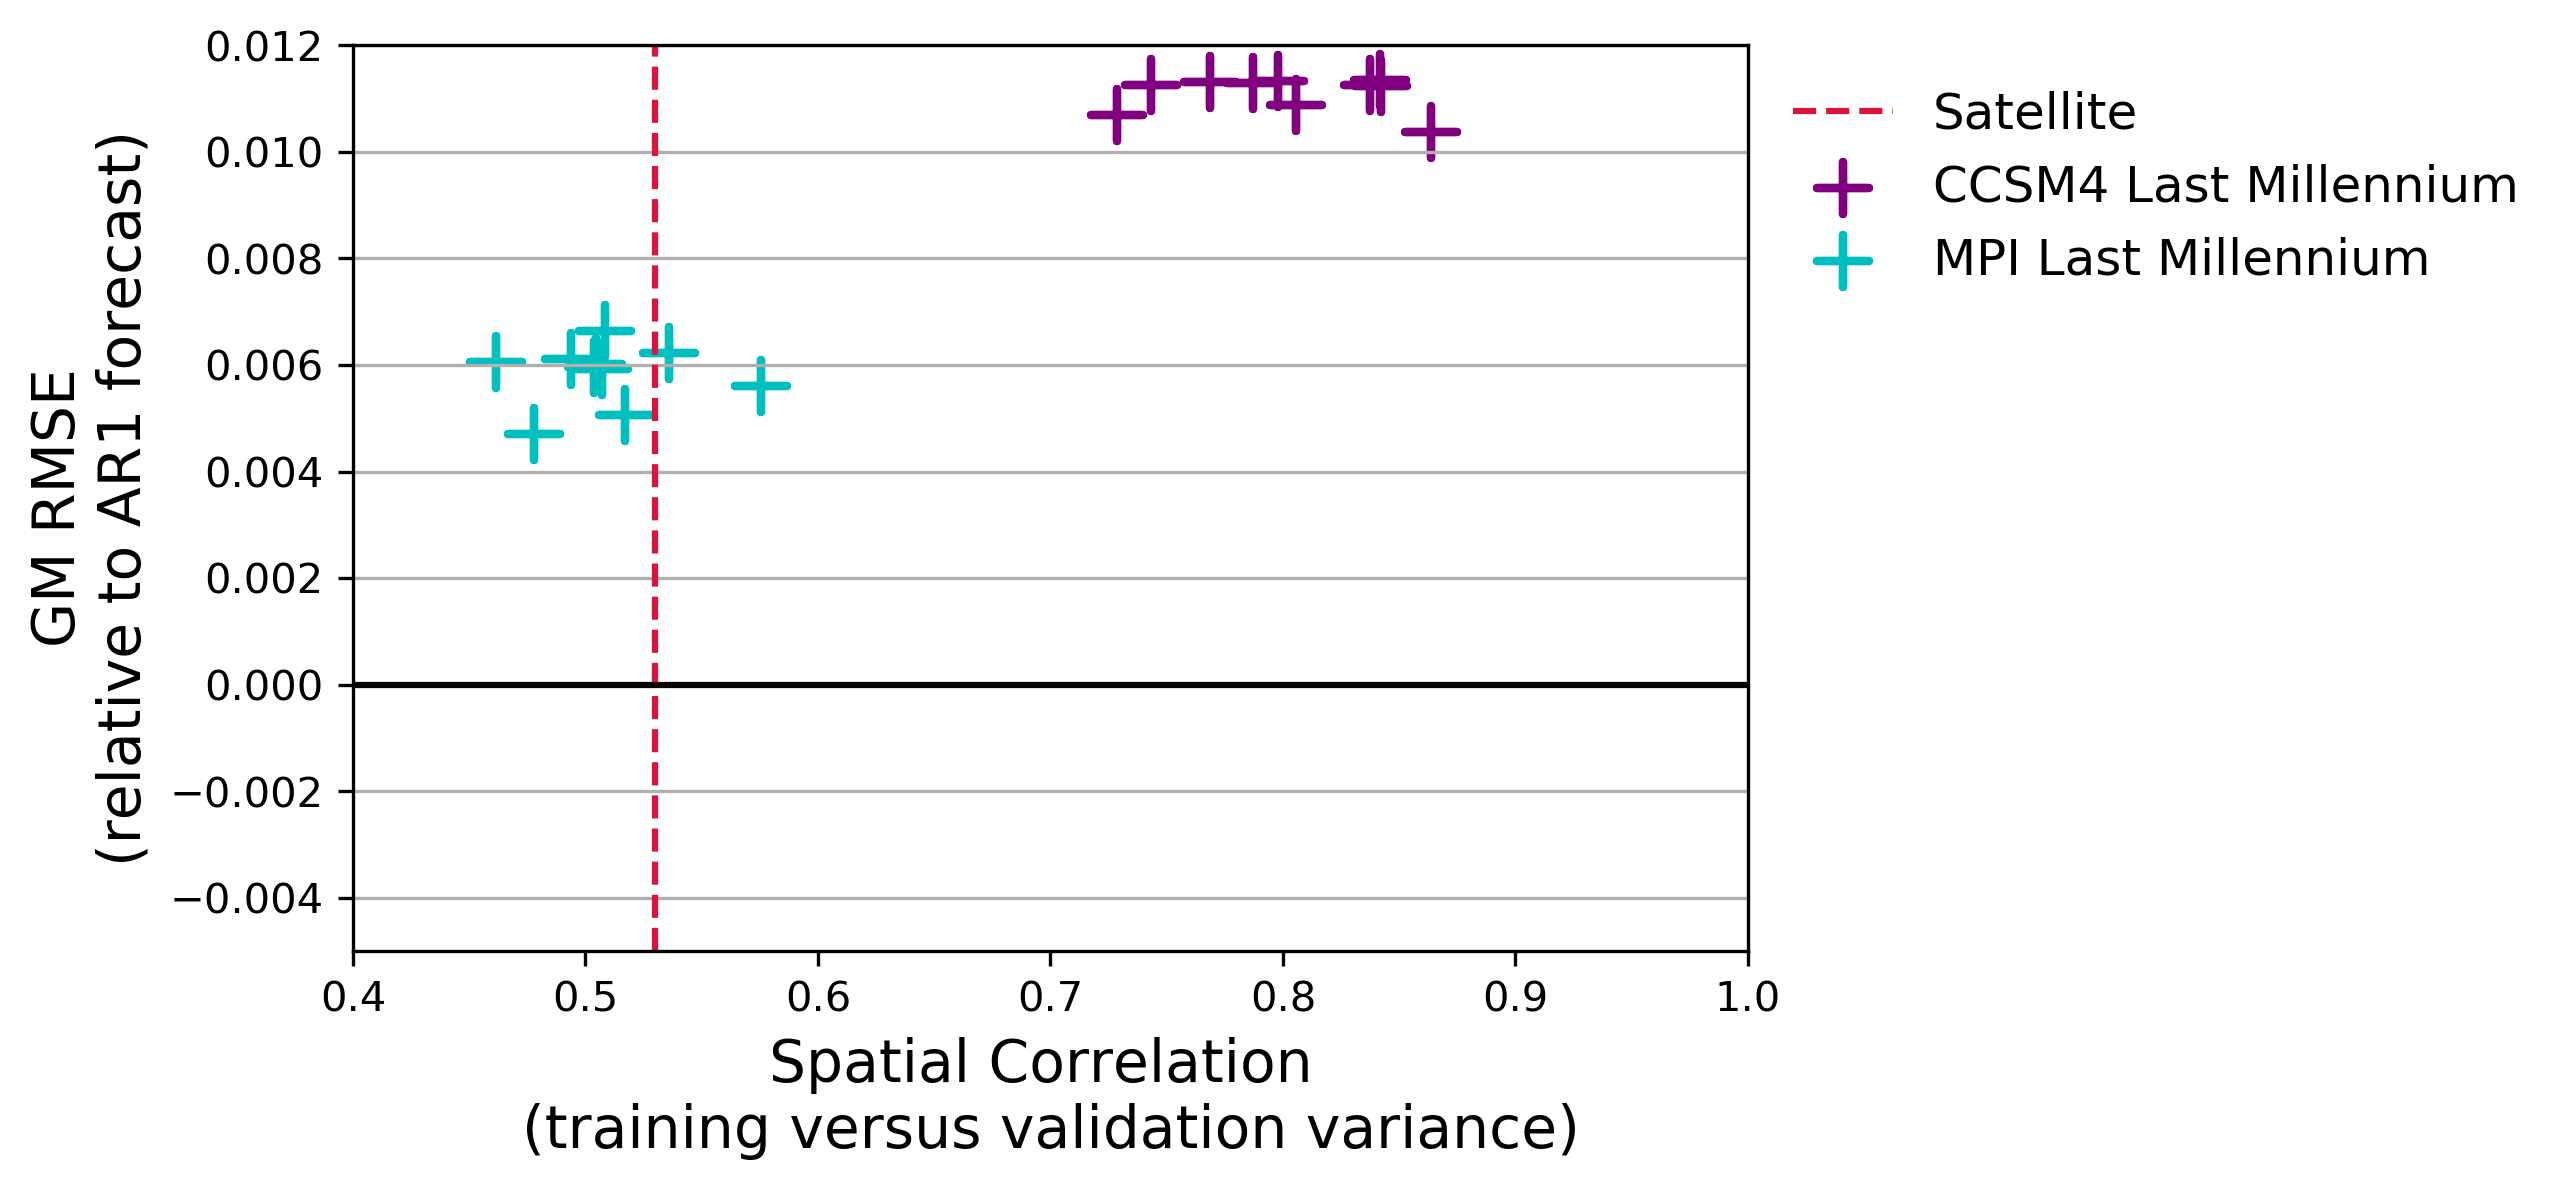

In [33]:
fig = plt.figure(figsize=(6,4))

for i,startyr in enumerate(startyrs_list):
    if i ==0:
        plt.scatter(scorr['scor_train_ccsm4_lm_all'][startyr-850],diff_ccsm4[i], color='purple',marker=(4,2,0),s=150, 
                    linewidth=2, label='CCSM4 Last Millennium')
        plt.scatter(scorr['scor_train_mpi_lm_all'][startyr-850],diff_mpi[i], color='c',marker=(4,2,0),s=150, 
                    linewidth=2, label='MPI Last Millennium')
    else: 
        plt.scatter(scorr['scor_train_ccsm4_lm_all'][startyr-850],diff_ccsm4[i], color='purple',marker=(4,2,0),s=150, 
                    linewidth=2)
        plt.scatter(scorr['scor_train_mpi_lm_all'][startyr-850],diff_mpi[i], color='c',marker=(4,2,0),s=150, 
                    linewidth=2)

plt.axvline(scorr['scor_train_sat'], color='crimson', linestyle='--', label='Satellite')

plt.xlabel('Spatial Correlation \n(training versus validation variance)', fontsize=14)
plt.ylabel('GM RMSE \n(relative to AR1 forecast)', fontsize=14)

plt.xlim(0.4,1.0)
plt.ylim(-0.005,0.012)
plt.legend(bbox_to_anchor=[1,1], fontsize=12, frameon=False)
plt.grid(axis='y')

plt.axhline(0,color='k')

In [34]:
lg = 1

diff_lme1 = ar1cast_lags_lme1['validation_stats_ar1_lags']['sic']['gm_rmse'][lg-1] - forecast_validation_lags_lme1['validation_stats_lags']['sic']['gm_rmse'][lg]
diff_lme2 = ar1cast_lags_lme2['validation_stats_ar1_lags']['sic']['gm_rmse'][lg-1] - forecast_validation_lags_lme2['validation_stats_lags']['sic']['gm_rmse'][lg]
diff_lme3 = ar1cast_lags_lme3['validation_stats_ar1_lags']['sic']['gm_rmse'][lg-1] - forecast_validation_lags_lme3['validation_stats_lags']['sic']['gm_rmse'][lg]

diff_le = ar1cast_lags_le['validation_stats_ar1_lags']['sic']['gm_rmse'][lg-1] - forecast_validation_lags_le['validation_stats_lags']['sic']['gm_rmse'][lg]
diff_era5 = ar1cast_lags_era5['validation_stats_ar1_lags']['sic']['gm_rmse'][lg-1] - forecast_validation_lags_era5['validation_stats_lags']['sic']['gm_rmse'][lg]

diff_cesm2_hist1 = ar1cast_lags_cesm2_hist1['validation_stats_ar1_lags']['sic']['gm_rmse'][lg-1] - forecast_validation_lags_cesm2_hist1['validation_stats_lags']['sic']['gm_rmse'][lg]
diff_cesm2_hist2 = ar1cast_lags_cesm2_hist2['validation_stats_ar1_lags']['sic']['gm_rmse'][lg-1] - forecast_validation_lags_cesm2_hist2['validation_stats_lags']['sic']['gm_rmse'][lg]
diff_cesm2_hist3 = ar1cast_lags_cesm2_hist3['validation_stats_ar1_lags']['sic']['gm_rmse'][lg-1] - forecast_validation_lags_cesm2_hist3['validation_stats_lags']['sic']['gm_rmse'][lg]

diff_gfdl_hist1 = ar1cast_lags_gfdl_hist1['validation_stats_ar1_lags']['sic']['gm_rmse'][lg-1] - forecast_validation_lags_gfdl_hist1['validation_stats_lags']['sic']['gm_rmse'][lg]
diff_gfdl_hist2 = ar1cast_lags_gfdl_hist2['validation_stats_ar1_lags']['sic']['gm_rmse'][lg-1] - forecast_validation_lags_gfdl_hist2['validation_stats_lags']['sic']['gm_rmse'][lg]
diff_gfdl_hist3 = ar1cast_lags_gfdl_hist3['validation_stats_ar1_lags']['sic']['gm_rmse'][lg-1] - forecast_validation_lags_gfdl_hist3['validation_stats_lags']['sic']['gm_rmse'][lg]

diff_ccsm4 = np.zeros(len(startyrs_list))
diff_mpi = np.zeros(len(startyrs_list))
for i,startyr in enumerate(startyrs_list):
    diff_ccsm4[i] = gm_rmse_ar1_ccsm4_sic[i,lg-1] - gm_rmse_ccsm4_sic[i,lg-1] 
    diff_mpi[i] = gm_rmse_ar1_mpi_sic[i,lg-1] - gm_rmse_mpi_sic[i,lg-1] 

Text(0.5,1,'Lag 1')

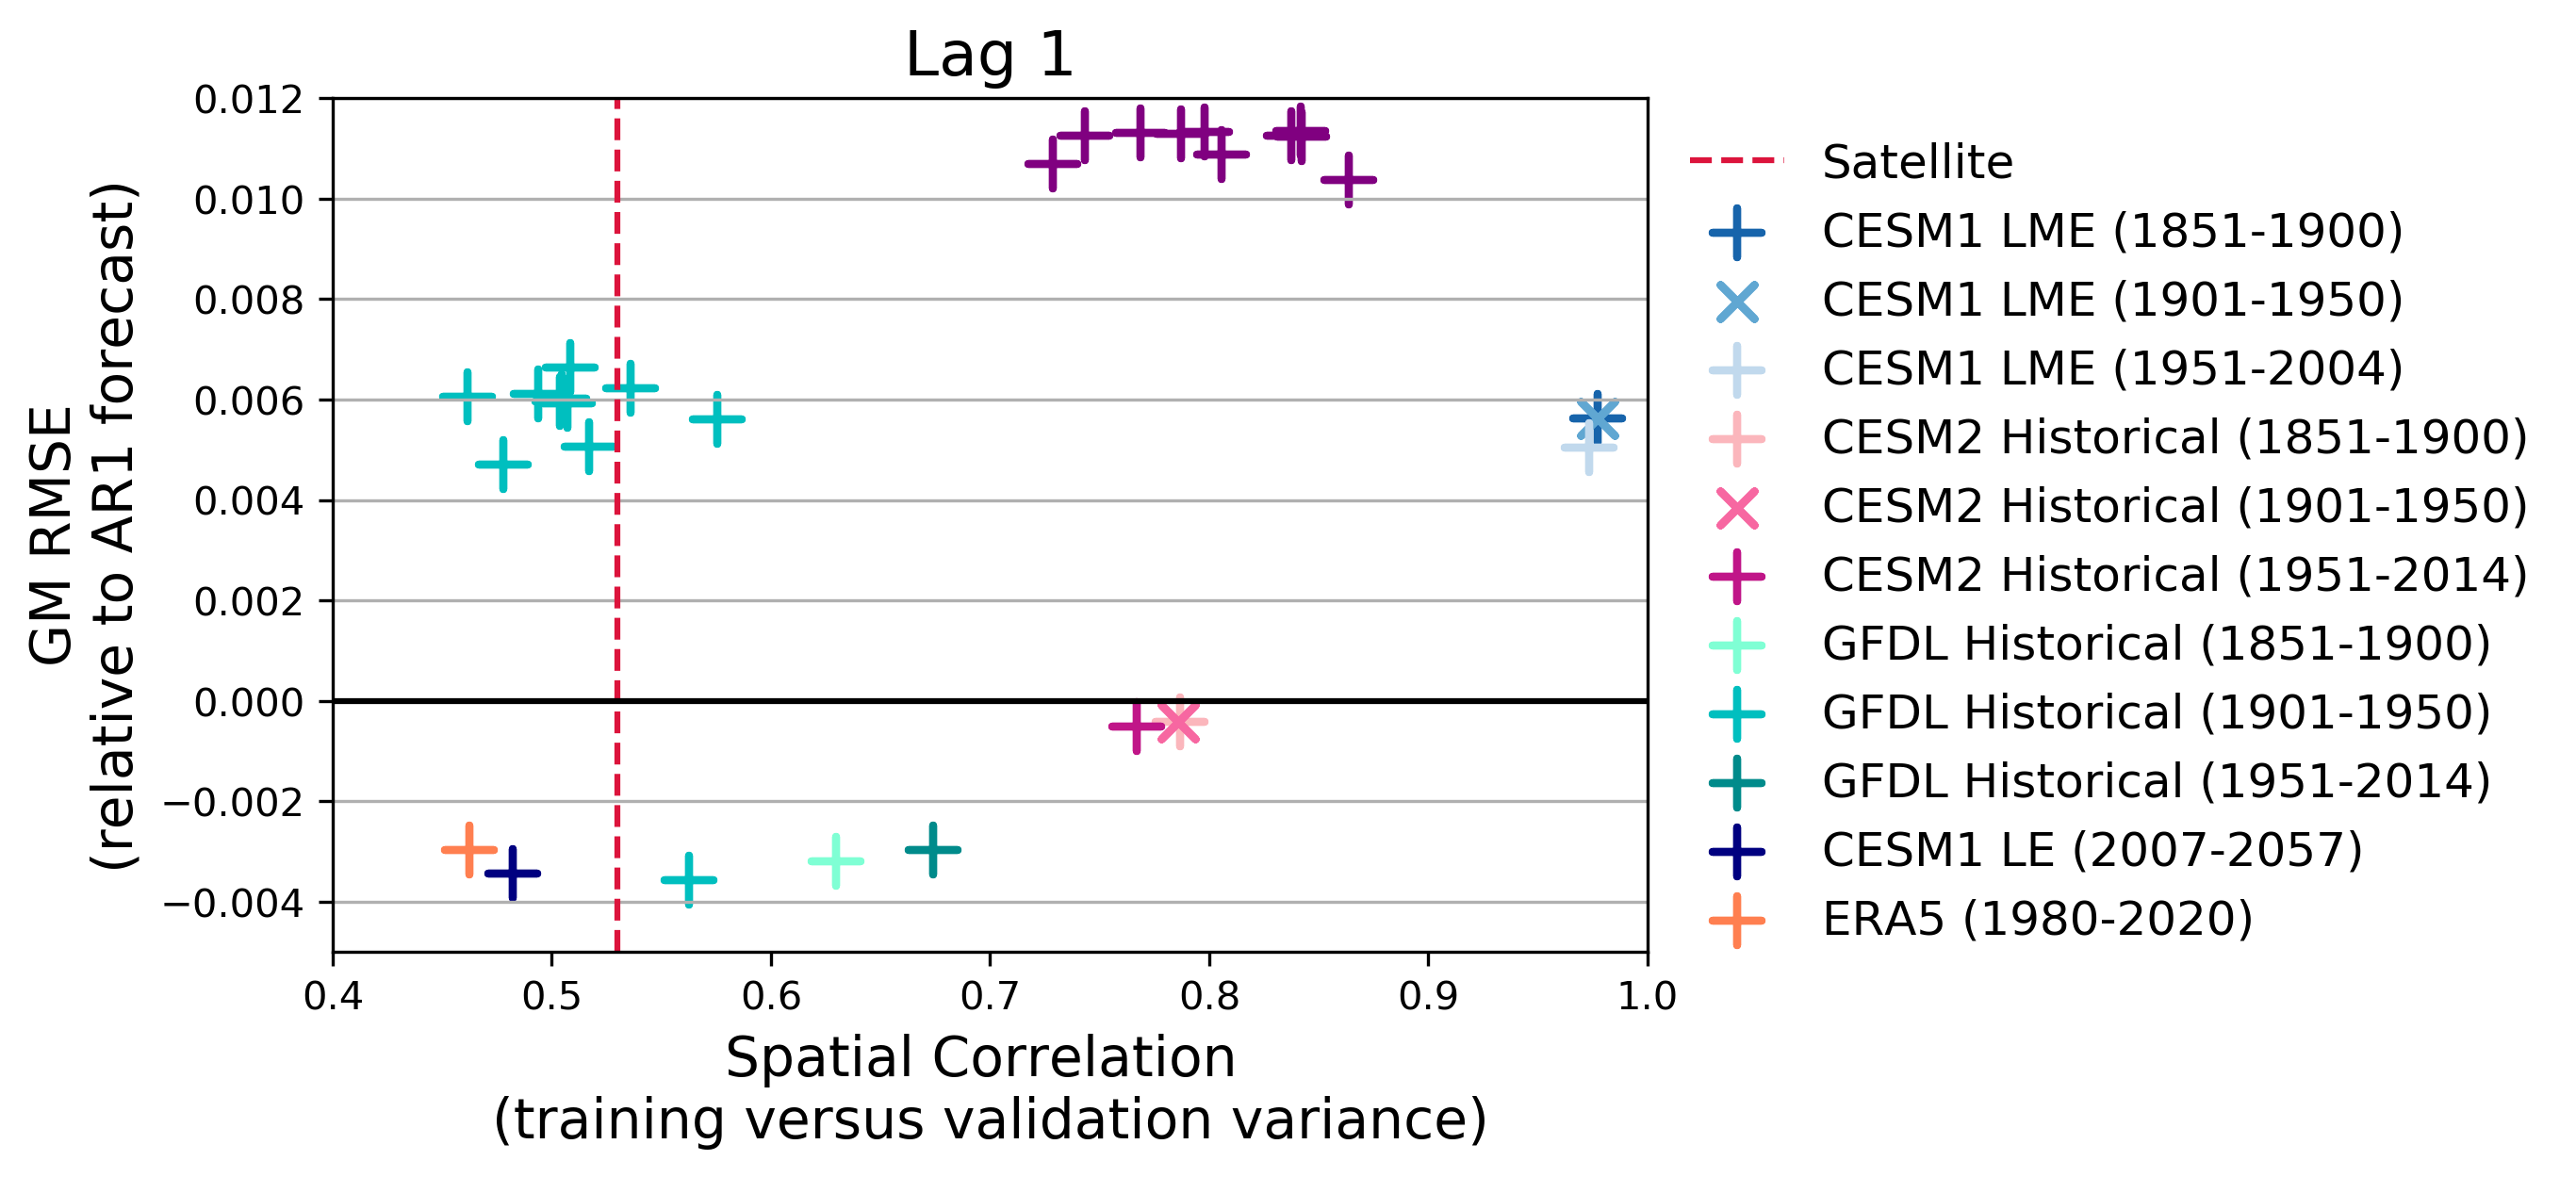

In [35]:
fig = plt.figure(figsize=(6,4))

plt.scatter(scorr['scor_train_lme1'],diff_lme1, color=colors[0],marker=(4,2,0),s=150,
            linewidth=2,label='CESM1 LME (1851-1900)')
plt.scatter(scorr['scor_train_lme2'],diff_lme1,color=colors[1],marker=(4,2,45),s=150,
            linewidth=2,label='CESM1 LME (1901-1950)')
plt.scatter(scorr['scor_train_lme3'],diff_lme3,color=colors[2],marker=(4,2,0),s=150,
            linewidth=2,label='CESM1 LME (1951-2004)')

plt.scatter(scorr['scor_train_cesm2_hist1'],diff_cesm2_hist1,color=colors1[0],marker=(4,2,0),s=150,
            linewidth=2,label='CESM2 Historical (1851-1900)')
plt.scatter(scorr['scor_train_cesm2_hist2'],diff_cesm2_hist2, color=colors1[1],marker=(4,2,45),s=150,
            linewidth=2,label='CESM2 Historical (1901-1950)')
plt.scatter(scorr['scor_train_cesm2_hist3'],diff_cesm2_hist3, color=colors1[2],marker=(4,2,0),s=150,
            linewidth=2,label='CESM2 Historical (1951-2014)')

plt.scatter(scorr['scor_train_gfdl_hist1'],diff_gfdl_hist1,color='aquamarine',marker=(4,2,0),s=150,
            linewidth=2,label='GFDL Historical (1851-1900)')
plt.scatter(scorr['scor_train_gfdl_hist2'],diff_gfdl_hist2, color='c',marker=(4,2,0),s=150,
            linewidth=2,label='GFDL Historical (1901-1950)')
plt.scatter(scorr['scor_train_gfdl_hist3'],diff_gfdl_hist3, color='darkcyan',marker=(4,2,0),s=150,
            linewidth=2,label='GFDL Historical (1951-2014)')

plt.scatter(scorr['scor_train_le'],diff_le, color='navy',marker=(4,2,0),s=150,
            linewidth=2,label='CESM1 LE (2007-2057)')
plt.scatter(scorr['scor_train_era5'],diff_era5, color='coral',marker=(4,2,0),s=150, 
            linewidth=2,label='ERA5 (1980-2020)')

for i,startyr in enumerate(startyrs_list):
    plt.scatter(scorr['scor_train_ccsm4_lm_all'][startyr-850],diff_ccsm4[i], color='purple',marker=(4,2,0),s=150, 
                linewidth=2)
    plt.scatter(scorr['scor_train_mpi_lm_all'][startyr-850],diff_mpi[i], color='c',marker=(4,2,0),s=150, 
                linewidth=2)

plt.axvline(scorr['scor_train_sat'], color='crimson', linestyle='--', label='Satellite')

plt.xlabel('Spatial Correlation \n(training versus validation variance)', fontsize=14)
plt.ylabel('GM RMSE \n(relative to AR1 forecast)', fontsize=14)

plt.xlim(0.4,1.0)
plt.ylim(-0.005,0.012)
plt.legend(bbox_to_anchor=[1,1], fontsize=12, frameon=False)
plt.grid(axis='y')

plt.axhline(0,color='k')
plt.title('Lag '+str(lg), fontsize=16)

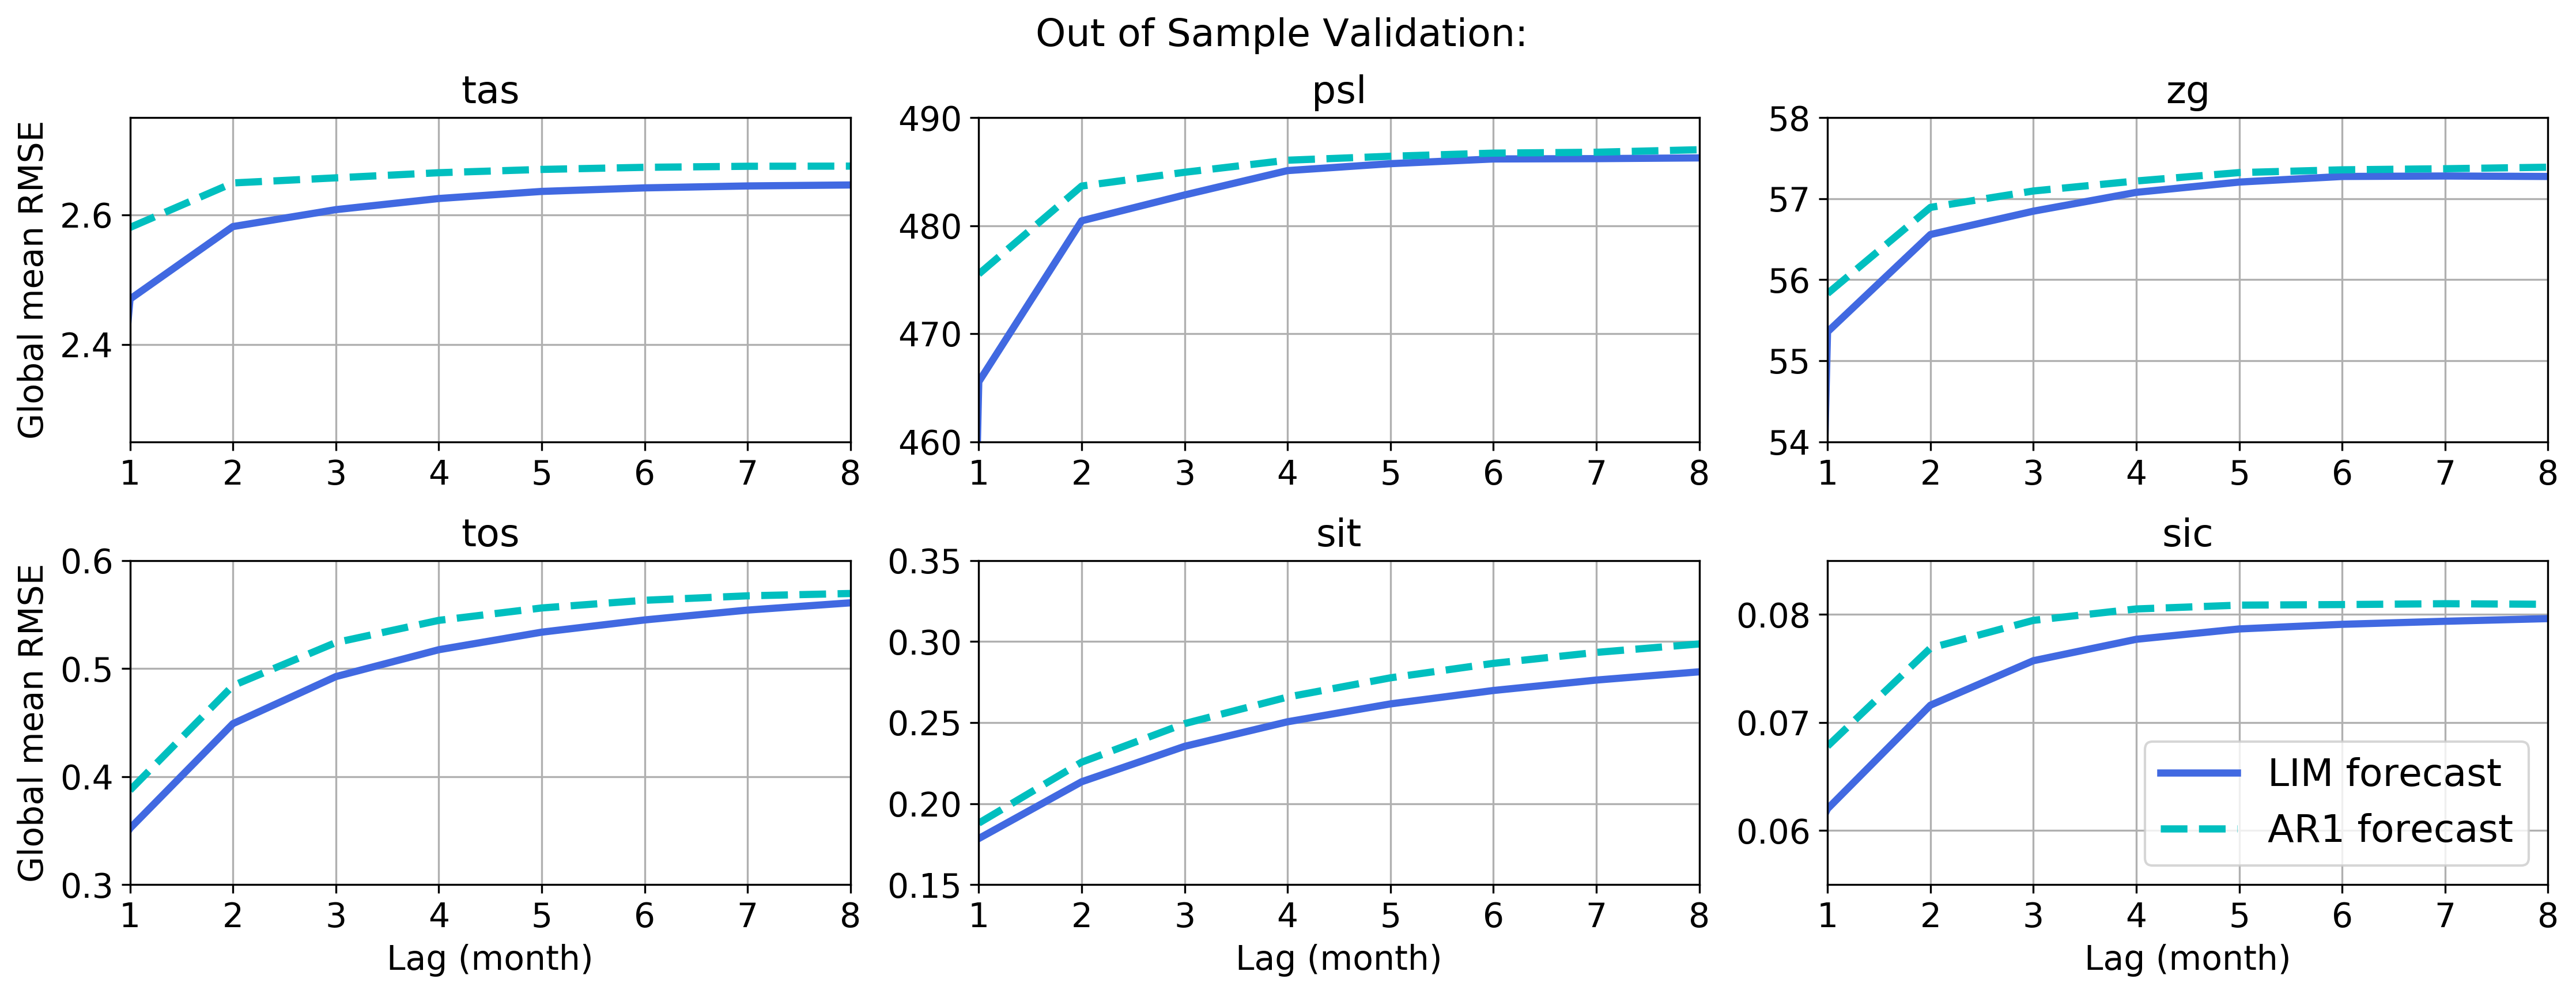

In [14]:
vmin = [2.25,460,54,0.3,0.15, 0.055]
vmax = [2.75,490,58,0.6,0.35, 0.085]

fig,axs = plt.subplots(2,3,figsize=(15,6))
ax = axs.flatten()

for i,var in enumerate(exp_setup_lme['limvars']):
    ax[i].grid(axis='both')

    ax[i].plot(np.arange(0,9,1),forecast_validation_lags_lme['validation_stats_lags'][var]['gm_rmse'], 
             label='LIM forecast', color='royalblue', linewidth=3)
    ax[i].plot(np.arange(1,9,1),ar1cast_lags_lme['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
             label='AR1 forecast', color='c', linewidth=3, linestyle='--')
    ax[i].set_xlim(1,8)
    ax[i].set_ylim(vmin[i],vmax[i])
    ax[i].set_title(var, fontsize=16)
    ax[i].tick_params(axis='both', which='major', labelsize=14)

# plt.ylim(0.05,0.085
ax[5].set_xlabel('Lag (month)', fontsize=14)
ax[3].set_xlabel('Lag (month)', fontsize=14)
ax[4].set_xlabel('Lag (month)', fontsize=14)

# plt.ylabel('Global mean RMSE',fontsize=16)
ax[0].set_ylabel('Global mean RMSE', fontsize=14)
ax[3].set_ylabel('Global mean RMSE', fontsize=14)

ax[5].legend(loc='lower right',fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.suptitle('Out of Sample Validation: ', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## LE 2007--2082 performance: 

Text(0.5,1,'Sea-ice Concentration')

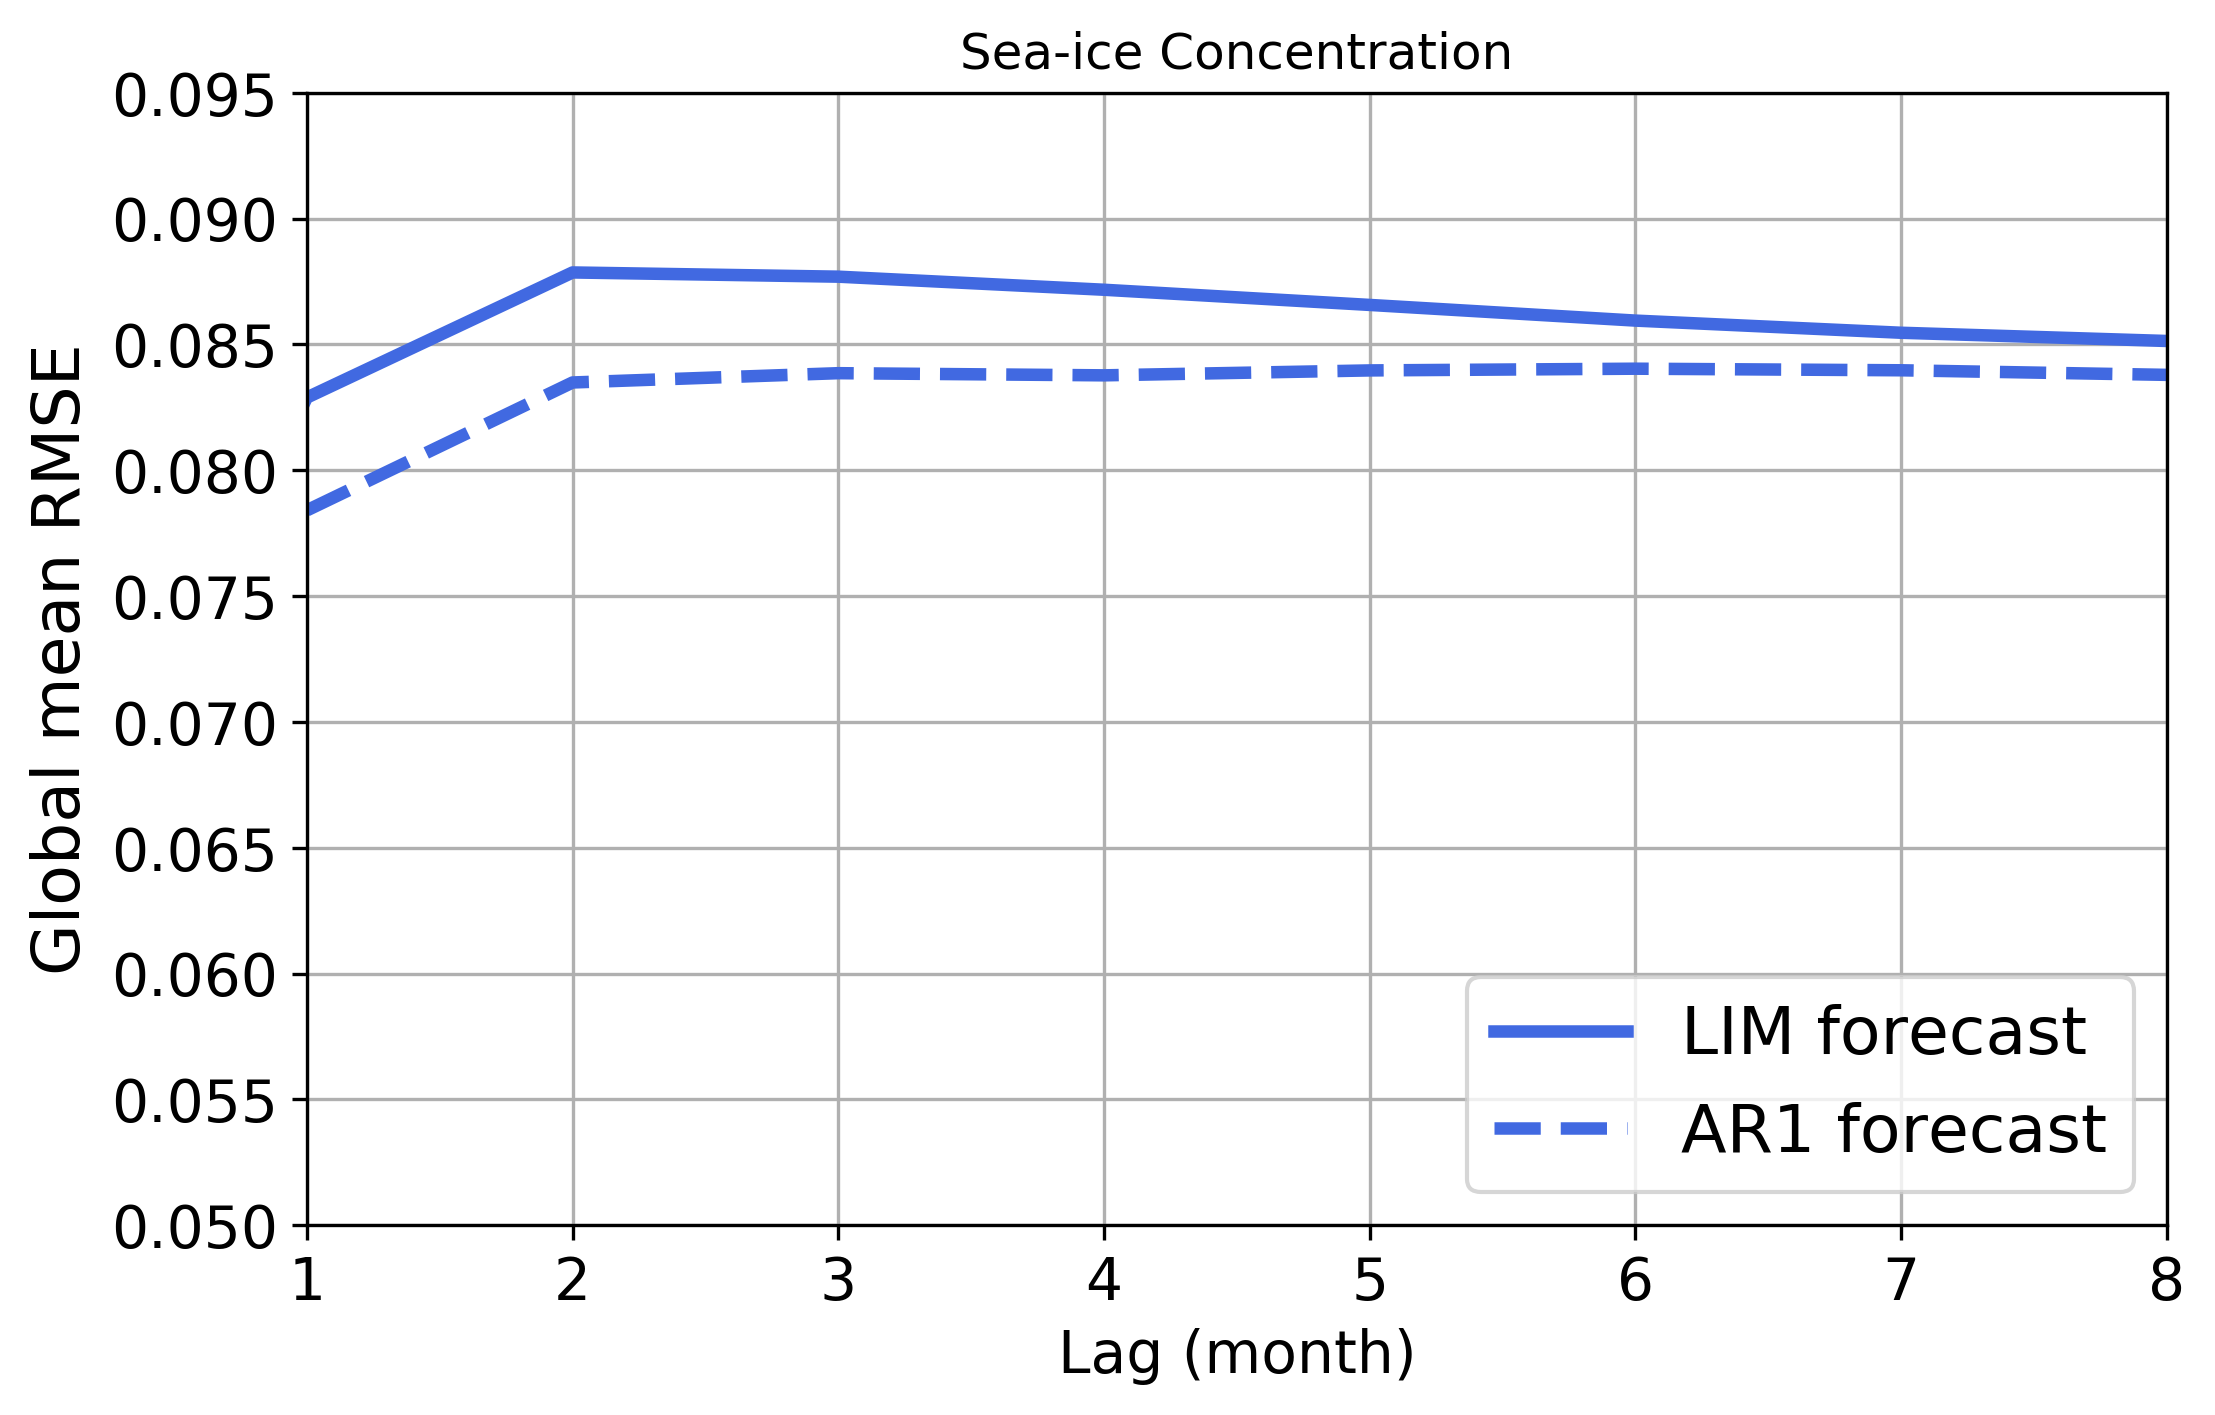

In [16]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(np.arange(0,9,1),forecast_validation_lags_le['validation_stats_lags']['sic']['gm_rmse'], 
         label='LIM forecast', color='royalblue', linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_le['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
         label='AR1 forecast', color='royalblue', linewidth=3, linestyle='--')

plt.ylim(0.05,0.095)
plt.xlim(1,8)
plt.xlabel('Lag (month)', fontsize=14)
plt.ylabel('Global mean RMSE',fontsize=16)
#ax.set_xticks(ticks=np.arange(0,13,1))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc='lower right',fontsize=16)
plt.title('Sea-ice Concentration')

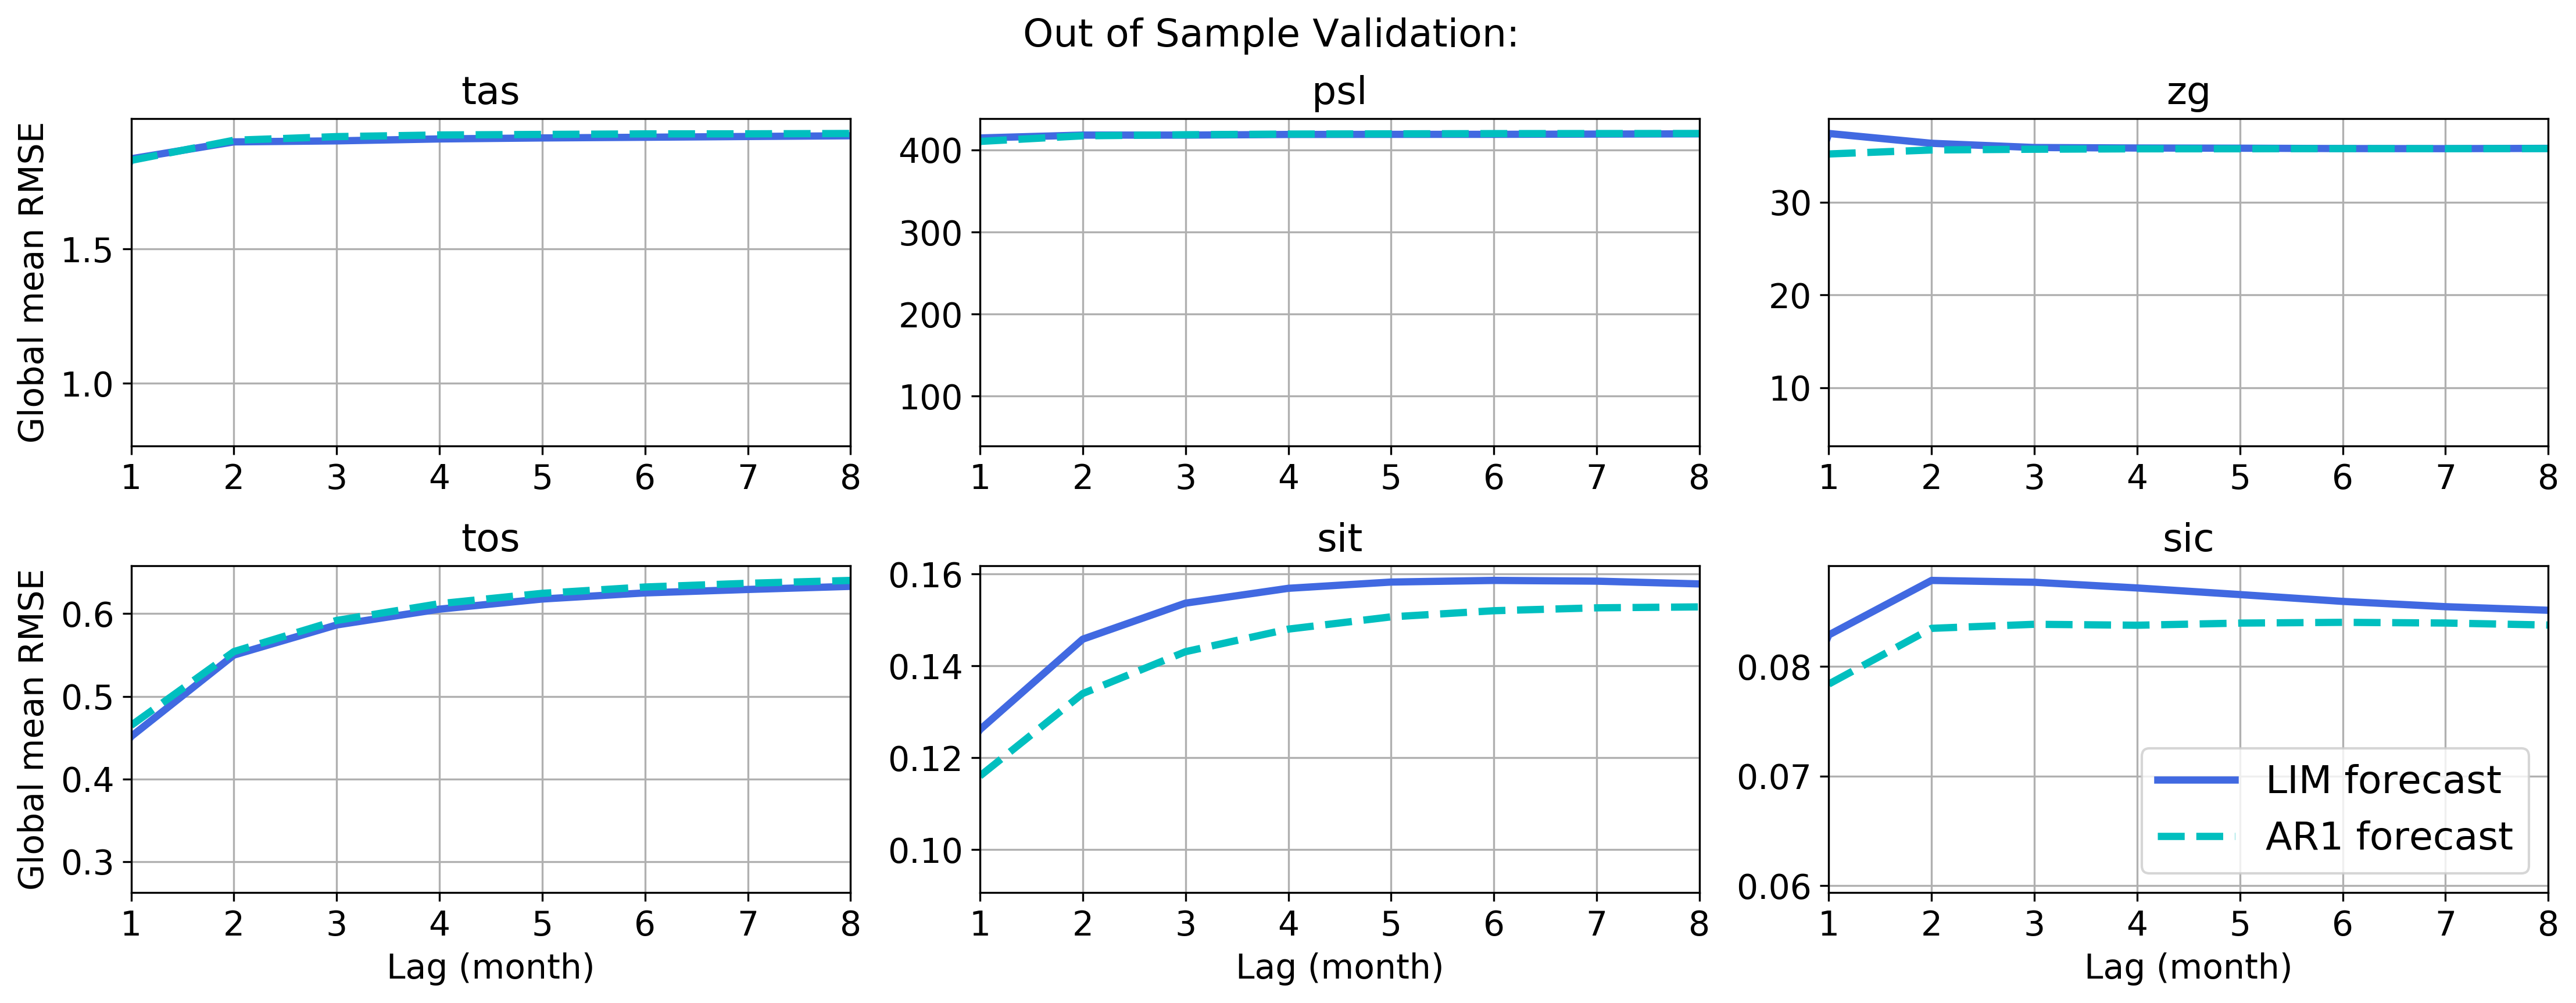

In [18]:
# vmin = [2.25,460,54,0.3,0.15, 0.055]
# vmax = [2.75,490,58,0.6,0.35, 0.085]

fig,axs = plt.subplots(2,3,figsize=(15,6))
ax = axs.flatten()

for i,var in enumerate(exp_setup_lme['limvars']):
    ax[i].grid(axis='both')

    ax[i].plot(np.arange(0,9,1),forecast_validation_lags_le['validation_stats_lags'][var]['gm_rmse'], 
             label='LIM forecast', color='royalblue', linewidth=3)
    ax[i].plot(np.arange(1,9,1),ar1cast_lags_le['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
             label='AR1 forecast', color='c', linewidth=3, linestyle='--')
    ax[i].set_xlim(1,8)
#    ax[i].set_ylim(vmin[i],vmax[i])
    ax[i].set_title(var, fontsize=16)
    ax[i].tick_params(axis='both', which='major', labelsize=14)

# plt.ylim(0.05,0.085
ax[5].set_xlabel('Lag (month)', fontsize=14)
ax[3].set_xlabel('Lag (month)', fontsize=14)
ax[4].set_xlabel('Lag (month)', fontsize=14)

# plt.ylabel('Global mean RMSE',fontsize=16)
ax[0].set_ylabel('Global mean RMSE', fontsize=14)
ax[3].set_ylabel('Global mean RMSE', fontsize=14)

ax[5].legend(loc='lower right',fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.suptitle('Out of Sample Validation: ', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
%run run_forecast_LME_crossmodel_validation_122021.py

cesm_lme
Validation data: cesm_lme
tecut = 201, tscut = 1.0
Loading from tas
Loading from a/LME/LIMs/tas_sfc_Amon_CESM_LMEallforc_002_085001-200512.nc
time dimension: 851 - 1050
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 5.199483871459961 seconds
-----------------------------------------------------
Validation shape: (3888, 2400)
time dimension: 851 - 1050
(2400,)
tecut = 201, tscut = 1.0
Loading from psl
Loading from a/LME/LIMs/psl_sfc_Amon_CESM_LMEallforc_002_085001-200512.nc
time dimension: 851 - 1050
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5


Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (3888, 200)
Forecast_anom shape: (3888, 200)
changing cellarea units from m^2 to km^2
Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (3888, 200)
Forecast_anom shape: (3888, 200)
changing cellarea units from m^2 to km^2
Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (3888, 200)
Forecast_anom shape: (3888, 200)
changing cellarea units from m^2 to km^2
Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (3888, 200)
Forecast_anom shape: (3888, 200)
changing cellarea units from m^2 to km^2
Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (3888, 200)
Forecast_anom shape: (3888, 200)
changing cellarea units from m^2 to km^2
Month 11
Trained using month 11...
Validating against month 11
Truth_anom shape: (3888, 200)
Forecast_anom shape: (3888, 200)
changing cellarea units from m^2 to km^2
tecut = 20

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (30720, 200)
Forecast_anom shape: (30720, 200)
changing cellarea units from centimeter^2 to km^2
Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (30720, 200)
Forecast_anom shape: (30720, 200)
changing cellarea units from centimeter^2 to km^2
Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (30720, 200)
Forecast_anom shape: (30720, 200)
changing cellarea units from centimeter^2 to km^2
Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (30720, 200)
Forecast_anom shape: (30720, 200)
changing cellarea units from centimeter^2 to km^2
Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (30720, 200)
Forecast_anom shape: (30720, 200)
changing cellarea units from centimeter^2 to km^2
Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (30720, 200)
Forecast_anom shape: (30720, 20

latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 3.7143514156341553 seconds
-----------------------------------------------------
Lag 0
Trained using all months...
Truth_anom shape: (3888, 2400)
Forecast_anom shape: (3888, 2400)
changing cellarea units from m^2 to km^2
Lag 1
Trained using all months...
Truth_anom shape: (3888, 2399)
Forecast_anom shape: (3888, 2399)
changing cellarea units from m^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (3888, 2398)
Forecast_anom shape: (3888, 2398)
changing cellarea units from m^2 to km^2
Lag 3
Trained using all months...
Truth_anom shape: (3888, 2397)
Forecast_anom shape: (3888, 2397)
changing cellarea units from m^2 to 

latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in satellite), going to fill with zeros...
Working on month...10
Found with nans (not in satellite), going to fill with zeros...
Working on month...11

tecut = 201, tscut = 1.0
Loading from psl
Loading from a/LME/LIMs/psl_sfc_Amon_CESM_LMEallforc_002_085001-200512.nc
time dimension: 851 - 1050
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 3.833909749984741 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (3888, 199)
Forecast_anom shape: (3888, 199)
changing cellarea units from m^2 to km^2
Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (3888, 200)
Forecast_anom shape: (3888, 200)
changing cellarea units from m^2 to km^2
Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (3888, 

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (30720, 200)
Forecast_anom shape: (30720, 200)
changing cellarea units from centimeter^2 to km^2
Month 11
Trained using month 11...
Validating against month 11
Truth_anom shape: (30720, 200)
Forecast_anom shape: (30720, 200)
changing cellarea units from centimeter^2 to km^2
tecut = 201, tscut = 1.0
Loading from sit
Loading from aIceData/LME/LIMs/sit_SImon_CESM_LME_nh_002_085001-200512.nc
time dimension: 851 - 1050
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with n

Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 6.527894735336304 seconds
-----------------------------------------------------
Lag 1
Trained using all months...
Truth_anom shape: (3888, 2399)
Forecast_anom shape: (3888, 2399)
changing cellarea units from m^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (3888, 2398)
Forecast_anom shape: (3888, 2398)
changing cellarea units from m^2 to km^2
Lag 3
Trained using all months...
Truth_anom shape: (3888, 2397)
Forecast_anom shape: (3888, 2397)
changing cellarea units from m^2 to km^2
Lag 4
Trained using all months...
Truth_anom shape: (3888, 2396)
Forecast_anom shape: (3888, 2396)
changing cellarea units from m^2 to km^2
Lag 5
Trained using all months...
Truth_anom shape: (3888, 2

Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in satellite), going to fill with zeros...
Working on month...10
Found with nans (not in satellite), going to fill with zeros...
Working on month...11
Found with nans (not in satellite), going to fill with zeros...
-----------------------------------------------------
completed in 26.176964282989502 seconds
-----------------------------------------------------
Lag 1
Trained using all months...
Truth_anom shape: (30720, 2399)
Forecast_anom shape: (30720, 2399)
changing cellarea units from centimeter^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (30720, 2398)
Forecast_anom shape: (30720, 2398)
changing cellarea units from centimeter^2 to km^2
Lag 3
Trained using all months...
Truth_anom shape: (30720, 2397)
Forecast_anom shape: (30720, 2397)
changing cellarea unit